In [329]:
##################
# IMPORT LIBRARIES
##################

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pytz
import warnings
warnings.filterwarnings('ignore')

- **'id'** = interaction id
- **'Customer ID'** = UNIQUE CUSTOMER ID *unique = 19976 / value_counts.sum = 19976 / 17, 12, 8, 7, 7....*
- 'Customer Name' = PROBLEM multiple customer name of a single customer ID
*unique = 17738 / value_counts.sum = 20443 / 33, 17, 11, 11, 9.....*
- 'Customer Description' = Migration or special Gifted Status
- 'Plan' = plan_1 = 20442 / plan_2 = 1
- 'Product' = Supper Club = 20442 / renew test = 1
- 'Interval' = year = 20442 / day = 1
- 'Amount' = 69 = 20442 / 1 = 1
- **'status'** = 'trialing', 'active', 'canceled', 'past_due', 'incomplete_expired'
- **'Created'** = interaction date *'Created (UTC)' is the first date in all rows: True*
- **'kind (metadata)'** = Migrated OG Member 552
- **''Cancel At Period End'** = False : 16878 / True : 3565





In [330]:
##################
# VISUAL SETTINGS
##################

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")

In [331]:
##################
# LOADING CSV
##################

def load_latest_csv(data_dir='data', rename_files=False):
    """Load the most recent CSV file from the data directory"""
    files = [
        os.path.join(data_dir, f)
        for f in os.listdir(data_dir)
        if os.path.isfile(os.path.join(data_dir, f)) and f.endswith('.csv')
    ]

    sorted_files = sorted(files, key=os.path.getctime, reverse=True)

    for file_path in sorted_files:
        created_at = datetime.fromtimestamp(os.path.getctime(file_path))
        timestamp_str = created_at.strftime('%Y-%m-%d_%H-%M-%S')
        original_name = os.path.basename(file_path)
        new_name = f"{timestamp_str}_{original_name}"
        new_path = os.path.join(data_dir, new_name)

        if rename_files:
            if not original_name.startswith(timestamp_str):
                os.rename(file_path, new_path)
                print(f"Renamed: {original_name} → {new_name}")
                file_path = new_path
            else:
                print(f"Already renamed: {original_name}")
        else:
            print(f"[DEV] Would rename: {original_name} → {new_name}")

    return pd.read_csv(sorted_files[0])

# Load data
df_raw = load_latest_csv()

[DEV] Would rename: DishpatchSubscriptionData_NIklas_Sanitised - subscriptions (2).csv → 2025-05-29_18-44-09_DishpatchSubscriptionData_NIklas_Sanitised - subscriptions (2).csv


In [332]:
##################
# DATA PREPROCESSING
##################

def preprocess_data(df):
    """Clean and preprocess the subscription data"""
    df = df.copy()

    # Date conversion
    date_cols = [col for col in df.columns if '(UTC)' in col]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)

    df = df.sort_values(by='Created (UTC)')

    # Column selection and renaming
    columns_to_keep = [
        'Customer Name', 'Status', 'Cancellation Reason',
        'Created (UTC)', 'Start (UTC)', 'Start Date (UTC)', 
        'Current Period Start (UTC)', 'Current Period End (UTC)', 
        'Trial Start (UTC)', 'Trial End (UTC)',
        'Canceled At (UTC)', 'Ended At (UTC)', 
        'senderShopifyCustomerId (metadata)'
    ]
    
    df = df[columns_to_keep]

    df.rename(columns={
        'Customer ID': 'customer_id',
        'Customer Name': 'customer_name',
        'Status': 'status',
        'Created (UTC)': 'created_utc',
        'Start (UTC)': 'start_utc',
        'Start Date (UTC)': 'start_date_utc',
        'Current Period Start (UTC)': 'current_period_start_utc',
        'Current Period End (UTC)': 'current_period_end_utc',
        'Trial Start (UTC)': 'trial_start_utc',
        'Trial End (UTC)': 'trial_end_utc',
        'Canceled At (UTC)': 'canceled_at_utc',
        'Ended At (UTC)': 'ended_at_utc',
        'senderShopifyCustomerId (metadata)': 'is_gifted_member'
    }, inplace=True)

    # Convert is_gifted_member to boolean
    df['is_gifted_member'] = df['is_gifted_member'].notna()

    # Reference date for analysis
    reference_date = pd.Timestamp.now(tz='UTC')
    print(f"📅 Reference date (TODAY) for analysis: {reference_date.strftime('%d-%m-%Y')}")

    # Consolidate status
    df.loc[df['status'].isin(['past_due', 'incomplete_expired']), 'status'] = 'canceled'

    return df, reference_date

df, reference_date = preprocess_data(df_raw)


📅 Reference date (TODAY) for analysis: 30-05-2025


In [333]:
##################
# HELPER FUNCTIONS
##################

def clean_membership_data(df):
    """Clean and prepare membership data for analysis"""
    # Remove very short subscriptions (likely test accounts)
    df['duration_days'] = (pd.to_datetime(df['ended_at_utc']) - pd.to_datetime(df['created_utc'])).dt.days
    df_clean = df[~((df['duration_days'] < 1) & (df['duration_days'].notna()))]
    
    # Remove duplicate signups (within 6 hours)
    df_clean = df_clean.sort_values(['customer_name', 'created_utc'])
    df_clean['time_diff'] = df_clean.groupby('customer_name')['created_utc'].diff()
    df_clean = df_clean[~((df_clean['time_diff'] < pd.Timedelta(hours=6)) & (df_clean['time_diff'].notna()))]
    
    return df_clean.drop(['duration_days', 'time_diff'], axis=1)

def calculate_real_duration(row):
    """Calculate actual subscription duration"""
    start_date = row['current_period_start_utc']
    
    if pd.notna(row['ended_at_utc']):
        end_date = row['ended_at_utc']
    else:
        end_date = row['current_period_end_utc']
    
    return (end_date - start_date).days

def calculate_period_duration(row):
    """Calculate subscription period duration"""
    start_date = row['current_period_start_utc']
    end_date = row['current_period_end_utc']
    
    return (end_date - start_date).days

def calculate_trial_duration(row):
    """Calculate trial duration"""
    if pd.notna(row['trial_start_utc']) and pd.notna(row['trial_end_utc']):
        start_date = row['trial_start_utc']
        end_date = row['trial_end_utc']
        return (end_date - start_date).days
    return 0

In [334]:
##################
# DATA PROCESSING
##################

# Clean abnormal data
analysis_df = clean_membership_data(df)

# Customer currently trialing
analysis_df['is_currently_trialing'] = analysis_df['status'] == 'trialing'

# Duration calculations
analysis_df['real_duration'] = analysis_df.apply(calculate_real_duration, axis=1)
analysis_df['period_duration'] = analysis_df.apply(calculate_period_duration, axis=1)
analysis_df['trial_duration'] = analysis_df.apply(calculate_trial_duration, axis=1)
analysis_df['only_trial'] = analysis_df['period_duration'] == analysis_df['trial_duration']

# Unknown period calculation
analysis_df['unknown_period'] = (analysis_df['current_period_start_utc'] - analysis_df['created_utc']).dt.days

# Define conversion and cancellation logic
analysis_df['paid_after_trial'] = (
    (analysis_df['status'] == 'active') |
    ((analysis_df['status'] == 'canceled') &
     (analysis_df['only_trial'] == False) &
     (analysis_df['canceled_at_utc'].isna())) |
    ((analysis_df['status'] == 'canceled') &
     (analysis_df['canceled_at_utc'] > analysis_df['trial_end_utc']))
)

analysis_df['cancel_during_trial'] = (
    ((analysis_df['status'] == 'canceled') &
     (analysis_df['canceled_at_utc'] <= analysis_df['trial_end_utc'])) |
    ((analysis_df['status'] == 'trialing') & 
     (analysis_df['canceled_at_utc'].notna()))
)

# Cas 1: Clients avec essai - remboursés dans les 14 jours après l'essai
refund_after_trial = (
    (analysis_df['status'] == 'canceled') &
    (analysis_df['trial_end_utc'].notna()) &  # A eu un essai
    (analysis_df['only_trial'] == False) &
    (analysis_df['cancel_during_trial'] == False) &
    (analysis_df['canceled_at_utc'] < analysis_df['trial_end_utc'] + pd.Timedelta(days=14)) &
    (analysis_df['canceled_at_utc'] > analysis_df['trial_end_utc'])  # Annulé APRÈS l'essai
)

# Cas 2: Clients sans essai - remboursés dans les 14 jours après le début de facturation
refund_no_trial = (
    (analysis_df['status'] == 'canceled') &
    (analysis_df['trial_end_utc'].isna()) &  # Pas d'essai
    (analysis_df['canceled_at_utc'] < analysis_df['current_period_start_utc'] + pd.Timedelta(days=14))
)

# Combinaison des deux cas
analysis_df['was_refund'] = refund_after_trial | refund_no_trial

analysis_df['in_churn_period'] = (
    ((analysis_df['status'] == 'active') &
     (analysis_df['trial_end_utc'] + pd.Timedelta(days=14) >= reference_date)) |
    ((analysis_df['status'] == 'active') &
     (analysis_df['current_period_start_utc'] + pd.Timedelta(days=14) >= reference_date))
)

analysis_df['end_soon'] = (
    (analysis_df['status'] == 'active') &
    (analysis_df['current_period_end_utc'] + pd.Timedelta(days=14) >= reference_date) &
    (analysis_df['current_period_end_utc'] > reference_date)
)

In [335]:
import pandas as pd
import numpy as np
from datetime import datetime

def add_renewal_indicators(df):
    """
    Ajoute les colonnes renewal_cycle et is_renewal au DataFrame
    
    Args:
        df: DataFrame avec les colonnes customer_name et start_date_utc
    
    Returns:
        DataFrame avec les nouvelles colonnes ajoutées
    """
    # Créer une copie pour éviter de modifier l'original
    df_copy = df.copy()
    
    # Convertir start_date_utc en datetime si ce n'est pas déjà fait
    df_copy['start_date_utc'] = pd.to_datetime(df_copy['start_date_utc'])
    
    # Trier par client et date de début
    df_copy = df_copy.sort_values(['customer_name', 'start_date_utc'])
    
    # Calculer le cycle de renouvellement pour chaque client
    df_copy['renewal_cycle'] = df_copy.groupby('customer_name').cumcount() + 1
    
    # Marquer si c'est un renouvellement (cycle > 1)
    df_copy['is_renewal'] = df_copy['renewal_cycle'] > 1
    
    print(f"✅ Ajouté renewal_cycle et is_renewal")
    print(f"📊 Distribution des cycles:")
    print(df_copy['renewal_cycle'].value_counts().sort_index())
    print(f"📈 Taux de renouvellement: {df_copy['is_renewal'].mean():.2%}")
    
    return df_copy

def analyze_cancellation_logic(df):
    """
    Analyse la logique d'annulation en comparant canceled_at_utc et ended_at_utc
    
    Args:
        df: DataFrame avec les colonnes canceled_at_utc et ended_at_utc
    """
    print("🔍 ANALYSE DE LA LOGIQUE D'ANNULATION")
    print("=" * 50)
    
    # Convertir les dates en datetime
    df_analysis = df.copy()
    df_analysis['canceled_at_utc'] = pd.to_datetime(df_analysis['canceled_at_utc'])
    df_analysis['ended_at_utc'] = pd.to_datetime(df_analysis['ended_at_utc'])
    
    # Filtrer les lignes avec des dates d'annulation
    canceled_subs = df_analysis[df_analysis['canceled_at_utc'].notna()].copy()
    
    if len(canceled_subs) == 0:
        print("❌ Aucune annulation trouvée dans les données")
        return
    
    print(f"📊 Nombre total d'annulations: {len(canceled_subs)}")
    
    # Calculer la différence entre annulation et fin effective
    canceled_subs['days_between_cancel_and_end'] = (
        canceled_subs['ended_at_utc'] - canceled_subs['canceled_at_utc']
    ).dt.days
    
    # Statistiques sur les différences
    print(f"\n📈 STATISTIQUES SUR LES DÉLAIS:")
    print(f"   • Différence moyenne: {canceled_subs['days_between_cancel_and_end'].mean():.1f} jours")
    print(f"   • Différence médiane: {canceled_subs['days_between_cancel_and_end'].median():.1f} jours")
    print(f"   • Min: {canceled_subs['days_between_cancel_and_end'].min()} jours")
    print(f"   • Max: {canceled_subs['days_between_cancel_and_end'].max()} jours")
    
    # Cas particuliers
    same_day = canceled_subs['days_between_cancel_and_end'] == 0
    immediate_end = canceled_subs['days_between_cancel_and_end'] < 0
    delayed_end = canceled_subs['days_between_cancel_and_end'] > 0
    
    print(f"\n📋 RÉPARTITION DES CAS:")
    print(f"   • Fin le même jour que l'annulation: {same_day.sum()} ({same_day.mean():.1%})")
    print(f"   • Fin avant la date d'annulation: {immediate_end.sum()} ({immediate_end.mean():.1%})")
    print(f"   • Fin après la date d'annulation: {delayed_end.sum()} ({delayed_end.mean():.1%})")
    
    if delayed_end.sum() > 0:
        avg_delay = canceled_subs[delayed_end]['days_between_cancel_and_end'].mean()
        print(f"     → Délai moyen quand fin différée: {avg_delay:.1f} jours")
    
    # Vérifier la cohérence avec votre modèle d'affaires
    print(f"\n✅ VALIDATION DU MODÈLE:")
    if delayed_end.mean() > 0.8:  # Plus de 80% des annulations ont une fin différée
        print("   ✅ Cohérent: La plupart des clients gardent l'accès jusqu'à la fin de leur période")
    else:
        print("   ⚠️  À vérifier: Beaucoup d'annulations avec fin immédiate")
    
    # Exemples concrets (sans révéler de données sensibles)
    print(f"\n📝 EXEMPLES (premiers cas):")
    examples = canceled_subs[['customer_name', 'canceled_at_utc', 'ended_at_utc', 'days_between_cancel_and_end']].head(5)
    for idx, row in examples.iterrows():
        print(f"   • Client annule le {row['canceled_at_utc'].strftime('%Y-%m-%d')}, "
              f"fin effective le {row['ended_at_utc'].strftime('%Y-%m-%d')} "
              f"({row['days_between_cancel_and_end']} jours)")
    
    return canceled_subs

def generate_comprehensive_analysis(df):
    """
    Génère une analyse complète avec renouvellements et annulations
    """
    print("🚀 ANALYSE COMPLÈTE DES DONNÉES D'ABONNEMENT")
    print("=" * 60)
    
    # 1. Ajouter les indicateurs de renouvellement
    df_enhanced = add_renewal_indicators(df)
    
    print("\n" + "=" * 60)
    
    # 2. Analyser la logique d'annulation
    analyze_cancellation_logic(df_enhanced)
    
    # 3. Analyse croisée : renouvellements vs annulations
    print(f"\n🎯 ANALYSE CROISÉE RENOUVELLEMENTS/ANNULATIONS")
    print("=" * 50)
    
    renewal_cancel_crosstab = pd.crosstab(
        df_enhanced['is_renewal'], 
        df_enhanced['canceled_at_utc'].notna(), 
        normalize='index'
    )
    
    if len(renewal_cancel_crosstab.columns) > 1:
        print("Taux d'annulation par type:")
        print(f"   • Nouveaux clients: {renewal_cancel_crosstab.loc[False, True]:.1%}")
        print(f"   • Renouvellements: {renewal_cancel_crosstab.loc[True, True]:.1%}")
    
    return df_enhanced


In [336]:
# UTILISATION:
df_enhanced = add_renewal_indicators(analysis_df)
analyze_cancellation_logic(analysis_df)
#ou pour une analyse complète:
df_complete = generate_comprehensive_analysis(analysis_df)

✅ Ajouté renewal_cycle et is_renewal
📊 Distribution des cycles:
1    17127
2     1012
3      118
4       14
5        4
6        1
Name: renewal_cycle, dtype: int64
📈 Taux de renouvellement: 6.29%
🔍 ANALYSE DE LA LOGIQUE D'ANNULATION
📊 Nombre total d'annulations: 12184

📈 STATISTIQUES SUR LES DÉLAIS:
   • Différence moyenne: 5.2 jours
   • Différence médiane: 0.0 jours
   • Min: 0.0 jours
   • Max: 387.0 jours

📋 RÉPARTITION DES CAS:
   • Fin le même jour que l'annulation: 8939 (73.4%)
   • Fin avant la date d'annulation: 0 (0.0%)
   • Fin après la date d'annulation: 2974 (24.4%)
     → Délai moyen quand fin différée: 21.0 jours

✅ VALIDATION DU MODÈLE:
   ⚠️  À vérifier: Beaucoup d'annulations avec fin immédiate

📝 EXEMPLES (premiers cas):
   • Client annule le 2024-05-31, fin effective le 2025-05-05 (338.0 jours)
   • Client annule le 2024-05-05, fin effective le 2024-05-05 (0.0 jours)
   • Client annule le 2025-05-16, fin effective le 2025-05-16 (0.0 jours)
   • Client annule le 2024

In [337]:
import pandas as pd
import numpy as np

def analyze_cancellation_context(df):
    """
    Analyse détaillée des annulations selon le contexte (essai vs payant)
    """
    print("🔍 ANALYSE DÉTAILLÉE DES ANNULATIONS PAR CONTEXTE")
    print("=" * 60)
    
    # Créer une copie et convertir les dates
    df_analysis = df.copy()
    date_cols = ['canceled_at_utc', 'ended_at_utc', 'trial_end_utc', 'start_date_utc']
    for col in date_cols:
        if col in df_analysis.columns:
            df_analysis[col] = pd.to_datetime(df_analysis[col])
    
    # Filtrer les annulations
    canceled = df_analysis[df_analysis['canceled_at_utc'].notna()].copy()
    
    # Calculer les délais
    canceled['days_cancel_to_end'] = (canceled['ended_at_utc'] - canceled['canceled_at_utc']).dt.days
    
    # Catégoriser les annulations
    def categorize_cancellation(row):
        # Annulation pendant l'essai
        if pd.notna(row['trial_end_utc']) and row['canceled_at_utc'] <= row['trial_end_utc']:
            return 'During Trial'
        # Annulation avec remboursement (indicateur was_refund)
        elif row.get('was_refund', False):
            return 'With Refund'
        # Annulation standard (pendant la période payée)
        else:
            return 'Standard Cancellation'
    
    canceled['cancellation_type'] = canceled.apply(categorize_cancellation, axis=1)
    
    print("📊 RÉPARTITION DES TYPES D'ANNULATION:")
    type_counts = canceled['cancellation_type'].value_counts()
    for cancel_type, count in type_counts.items():
        pct = count / len(canceled) * 100
        print(f"   • {cancel_type}: {count:,} ({pct:.1f}%)")
    
    print(f"\n🕐 DÉLAIS PAR TYPE D'ANNULATION:")
    for cancel_type in canceled['cancellation_type'].unique():
        subset = canceled[canceled['cancellation_type'] == cancel_type]
        immediate = (subset['days_cancel_to_end'] == 0).sum()
        delayed = (subset['days_cancel_to_end'] > 0).sum()
        
        print(f"\n   📋 {cancel_type}:")
        print(f"      • Fin immédiate: {immediate} ({immediate/len(subset)*100:.1f}%)")
        print(f"      • Fin différée: {delayed} ({delayed/len(subset)*100:.1f}%)")
        
        if delayed > 0:
            avg_delay = subset[subset['days_cancel_to_end'] > 0]['days_cancel_to_end'].mean()
            print(f"      • Délai moyen si différé: {avg_delay:.1f} jours")
    
    return canceled

def analyze_trial_conversion_and_retention(df):
    """
    Analyse des conversions d'essai et rétention
    """
    print(f"\n🎯 ANALYSE CONVERSION D'ESSAI ET RÉTENTION")
    print("=" * 50)
    
    total_members = len(df)
    trial_members = df['is_currently_trialing'].sum() if 'is_currently_trialing' in df.columns else 0
    paid_after_trial = df['paid_after_trial'].sum() if 'paid_after_trial' in df.columns else 0
    only_trial = df['only_trial'].sum() if 'only_trial' in df.columns else 0
    
    print(f"📊 STATISTIQUES GLOBALES:")
    print(f"   • Total membres: {total_members:,}")
    print(f"   • Actuellement en essai: {trial_members:,}")
    print(f"   • Ont payé après essai: {paid_after_trial:,}")
    print(f"   • Seulement essai (pas converti): {only_trial:,}")
    
    if only_trial + paid_after_trial > 0:
        conversion_rate = paid_after_trial / (only_trial + paid_after_trial)
        print(f"   • Taux de conversion essai: {conversion_rate:.1%}")
    
    # Analyse par cycle de renouvellement
    if 'renewal_cycle' in df.columns:
        print(f"\n📈 RÉTENTION PAR CYCLE:")
        for cycle in sorted(df['renewal_cycle'].unique()):
            count = (df['renewal_cycle'] == cycle).sum()
            if cycle == 1:
                print(f"   • Cycle {cycle} (nouveaux): {count:,}")
            else:
                retention_from_previous = count / (df['renewal_cycle'] == cycle-1).sum()
                print(f"   • Cycle {cycle}: {count:,} (rétention: {retention_from_previous:.1%})")

def comprehensive_business_insights(df):
    """
    Génère des insights business complets
    """
    print(f"\n💡 INSIGHTS BUSINESS CLÉS")
    print("=" * 40)
    
    # 1. Analyse des annulations par contexte
    canceled_analysis = analyze_cancellation_context(df)
    
    # 2. Conversion et rétention
    analyze_trial_conversion_and_retention(df)
    
    # 3. Recommandations
    print(f"\n🚀 RECOMMANDATIONS:")
    
    # Taux de renouvellement faible
    renewal_rate = (df['renewal_cycle'] > 1).mean()
    if renewal_rate < 0.15:  # Moins de 15%
        print(f"   ⚠️  Taux de renouvellement faible ({renewal_rate:.1%})")
        print(f"      → Focus sur l'engagement pendant la première année")
        print(f"      → Améliorer l'onboarding et la valeur perçue")
    
    # Analyse des annulations immédiates
    immediate_cancellations = (canceled_analysis['days_cancel_to_end'] == 0).mean()
    if immediate_cancellations > 0.5:
        print(f"   ℹ️  {immediate_cancellations:.1%} des annulations sont immédiates")
        print(f"      → Normal si beaucoup d'annulations pendant l'essai")
        print(f"      → Vérifier la politique de remboursement")
    
    return canceled_analysis

# UTILISATION:
canceled_details = comprehensive_business_insights(df_enhanced)


💡 INSIGHTS BUSINESS CLÉS
🔍 ANALYSE DÉTAILLÉE DES ANNULATIONS PAR CONTEXTE
📊 RÉPARTITION DES TYPES D'ANNULATION:
   • During Trial: 8,710 (71.5%)
   • Standard Cancellation: 2,584 (21.2%)
   • With Refund: 890 (7.3%)

🕐 DÉLAIS PAR TYPE D'ANNULATION:

   📋 Standard Cancellation:
      • Fin immédiate: 1494 (57.8%)
      • Fin différée: 835 (32.3%)
      • Délai moyen si différé: 22.1 jours

   📋 During Trial:
      • Fin immédiate: 6651 (76.4%)
      • Fin différée: 2043 (23.5%)
      • Délai moyen si différé: 6.5 jours

   📋 With Refund:
      • Fin immédiate: 794 (89.2%)
      • Fin différée: 96 (10.8%)
      • Délai moyen si différé: 319.5 jours

🎯 ANALYSE CONVERSION D'ESSAI ET RÉTENTION
📊 STATISTIQUES GLOBALES:
   • Total membres: 18,276
   • Actuellement en essai: 156
   • Ont payé après essai: 8,905
   • Seulement essai (pas converti): 8,850
   • Taux de conversion essai: 50.2%

📈 RÉTENTION PAR CYCLE:
   • Cycle 1 (nouveaux): 17,127
   • Cycle 2: 1,012 (rétention: 5.9%)
   • Cycle

📊 CALCUL DES MEMBRES ACTIFS PAR SEMAINE
✅ Membres éligibles (full members): 8,322
📅 Période d'analyse: 2023-08-28 à 2025-05-26
📊 Nombre de semaines: 92

📈 ÉVOLUTION DES MEMBRES ACTIFS:
Semaine      Membres Actifs  Évolution 
----------------------------------------
2023-08-28   0               —         
2023-09-04   0               +0        
2023-09-11   0               +0        
2023-09-18   0               +0        
2023-09-25   0               +0        
2023-10-02   0               +0        
2023-10-09   0               +0        
2023-10-16   116             +116      
2023-10-23   236             +120      
2023-10-30   376             +140      
2023-11-06   412             +36       
2023-11-13   472             +60       
2023-11-20   518             +46       
2023-11-27   573             +55       
2023-12-04   619             +46       
2023-12-11   668             +49       
2023-12-18   672             +4        
2023-12-25   673             +1        
2024-01-01   6

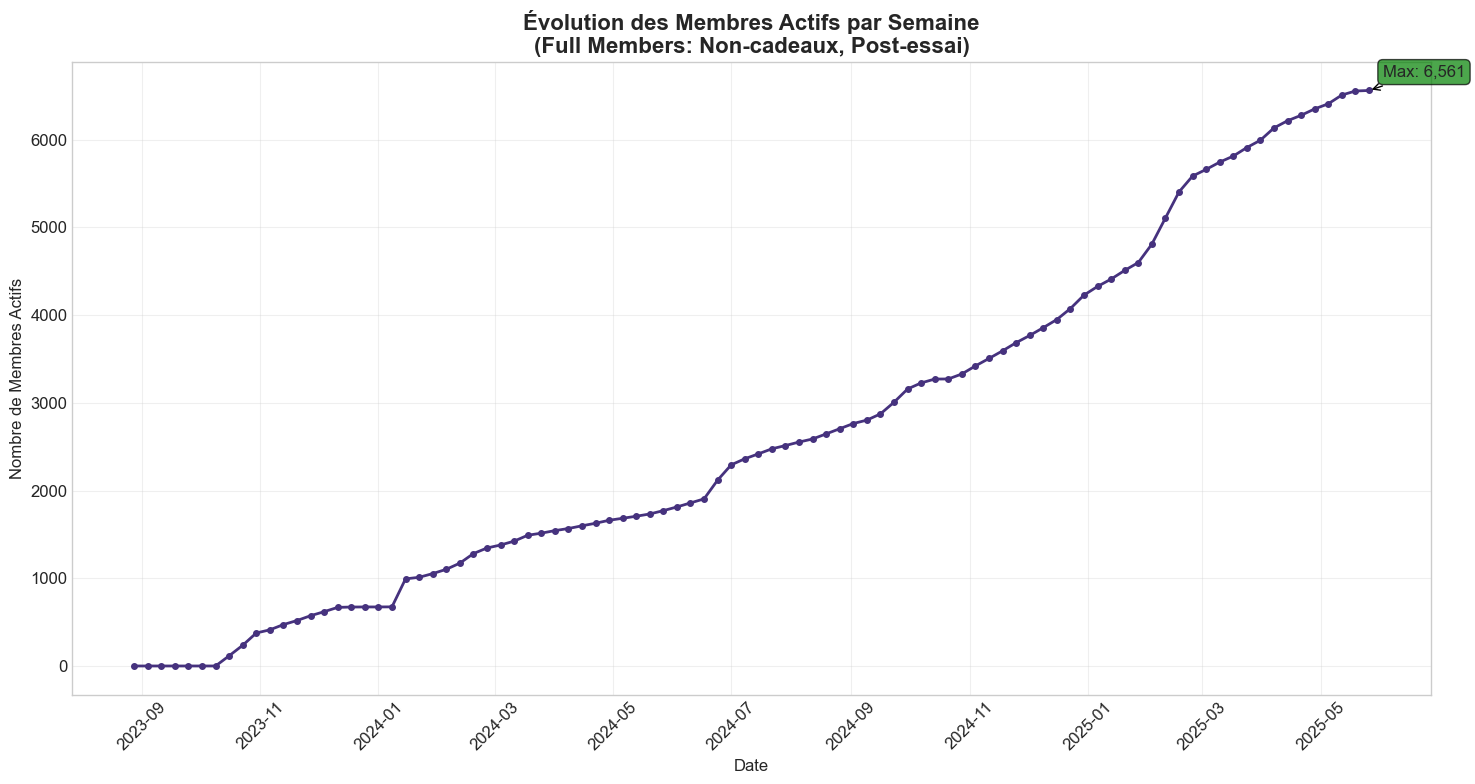


📈 ANALYSE DES TENDANCES DE CROISSANCE
📊 TENDANCES RÉCENTES (4 dernières semaines):
   • Variation moyenne: +52.5 membres/semaine
   ✅ Tendance: Croissance

📊 RÉPARTITION DES PÉRIODES:
   • Semaines de croissance: 84 (92.3%)
   • Semaines de déclin: 0 (0.0%)
   • Semaines stables: 7 (7.7%)


<Figure size 1500x800 with 0 Axes>

In [338]:
def calculate_weekly_active_members(df, start_date='2023-09-01'):
    """
    Calcule le nombre de membres actifs (full members) au début de chaque semaine
    
    Critères pour être un "full member":
    - A terminé son essai (paid_after_trial = True)
    - Membership actif à la date donnée
    - N'est pas un membre cadeau (is_gifted_member = False)
    """
    
    print("📊 CALCUL DES MEMBRES ACTIFS PAR SEMAINE")
    print("=" * 50)
    
    # Préparer les données
    df_clean = df.copy()
    
    # Convertir les dates et normaliser les timezones
    date_columns = ['start_date_utc', 'current_period_start_utc', 'current_period_end_utc', 
                   'trial_end_utc', 'canceled_at_utc', 'ended_at_utc']
    
    for col in date_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col])
            # Normaliser les timezones - supprimer l'info timezone pour éviter les conflits
            if df_clean[col].dt.tz is not None:
                df_clean[col] = df_clean[col].dt.tz_localize(None)
    
    # Définir les critères pour "full member"
    full_members = df_clean[
        (df_clean['paid_after_trial'] == True) &  # A payé après l'essai
        (df_clean['is_gifted_member'] == False)   # N'est pas un cadeau
    ].copy()
    
    print(f"✅ Membres éligibles (full members): {len(full_members):,}")
    
    # Générer les dates de semaine depuis start_date
    start_date = pd.to_datetime(start_date).tz_localize(None)  # Supprimer timezone
    end_date = pd.to_datetime('2025-05-30').tz_localize(None)  # Date actuelle
    
    # Créer une liste de tous les lundis (début de semaine)
    weeks = []
    current_week = start_date - timedelta(days=start_date.weekday())  # Lundi de la semaine de start_date
    
    while current_week <= end_date:
        weeks.append(current_week)
        current_week += timedelta(days=7)
    
    print(f"📅 Période d'analyse: {weeks[0].strftime('%Y-%m-%d')} à {weeks[-1].strftime('%Y-%m-%d')}")
    print(f"📊 Nombre de semaines: {len(weeks)}")
    
    # Calculer les membres actifs pour chaque semaine
    weekly_counts = []
    
    for week_start in weeks:
        # Pour chaque membre, vérifier s'il était actif cette semaine
        active_members = 0
        
        for idx, member in full_members.iterrows():
            # Le membre est actif si:
            # 1. Son membership a commencé avant ou pendant cette semaine
            # 2. Son membership n'était pas encore terminé au début de cette semaine
            
            membership_start = member['current_period_start_utc']
            membership_end = member['current_period_end_utc']
            
            # Si pas de date de fin, utiliser ended_at_utc ou considérer comme actif
            if pd.isna(membership_end):
                if pd.notna(member['ended_at_utc']):
                    membership_end = member['ended_at_utc']
                else:
                    # Membre toujours actif
                    membership_end = end_date
            
            # Vérifier si le membre était actif au début de cette semaine
            if (pd.notna(membership_start) and 
                membership_start <= week_start and 
                membership_end > week_start):
                active_members += 1
        
        weekly_counts.append({
            'week_start': week_start,
            'week_start_str': week_start.strftime('%Y-%m-%d'),
            'active_members': active_members
        })
    
    # Créer le DataFrame des résultats
    results_df = pd.DataFrame(weekly_counts)
    
    # Afficher les résultats
    print(f"\n📈 ÉVOLUTION DES MEMBRES ACTIFS:")
    print(f"{'Semaine':<12} {'Membres Actifs':<15} {'Évolution':<10}")
    print("-" * 40)
    
    for i, row in results_df.iterrows():
        if i == 0:
            evolution = "—"
        else:
            prev_count = results_df.iloc[i-1]['active_members']
            change = row['active_members'] - prev_count
            evolution = f"{change:+d}"
        
        print(f"{row['week_start_str']:<12} {row['active_members']:<15,} {evolution:<10}")
    
    # Statistiques résumées
    print(f"\n📊 STATISTIQUES RÉSUMÉES:")
    print(f"   • Maximum: {results_df['active_members'].max():,} membres")
    print(f"   • Minimum: {results_df['active_members'].min():,} membres")
    print(f"   • Moyenne: {results_df['active_members'].mean():.0f} membres")
    print(f"   • Actuel: {results_df.iloc[-1]['active_members']:,} membres")
    
    # Croissance totale
    first_count = results_df.iloc[0]['active_members']
    last_count = results_df.iloc[-1]['active_members']
    
    if first_count > 0:
        growth_rate = ((last_count - first_count) / first_count) * 100
        print(f"   • Croissance totale: {growth_rate:+.1f}%")
    
    return results_df

def plot_weekly_members(results_df):
    """
    Crée un graphique de l'évolution des membres actifs
    """
    plt.figure(figsize=(15, 8))
    
    # Graphique principal
    plt.plot(results_df['week_start'], results_df['active_members'], 
             linewidth=2, marker='o', markersize=4)
    
    plt.title('Évolution des Membres Actifs par Semaine\n(Full Members: Non-cadeaux, Post-essai)', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Nombre de Membres Actifs', fontsize=12)
    
    # Formatage de l'axe des dates
    plt.xticks(rotation=45)
    
    # Ajouter une grille
    plt.grid(True, alpha=0.3)
    
    # Ajouter des annotations pour les valeurs importantes
    max_idx = results_df['active_members'].idxmax()
    min_idx = results_df['active_members'].idxmin()
    
    plt.annotate(f'Max: {results_df.iloc[max_idx]["active_members"]:,}',
                xy=(results_df.iloc[max_idx]['week_start'], results_df.iloc[max_idx]['active_members']),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    plt.tight_layout()
    plt.show()
    
    return plt.gcf()

def analyze_growth_trends(results_df):
    """
    Analyse les tendances de croissance
    """
    print(f"\n📈 ANALYSE DES TENDANCES DE CROISSANCE")
    print("=" * 45)
    
    # Calculer les variations hebdomadaires
    results_df['weekly_change'] = results_df['active_members'].diff()
    results_df['weekly_change_pct'] = results_df['active_members'].pct_change() * 100
    
    # Moyennes mobiles
    results_df['ma_4weeks'] = results_df['active_members'].rolling(window=4).mean()
    results_df['ma_12weeks'] = results_df['active_members'].rolling(window=12).mean()
    
    # Tendances récentes (dernières 4 semaines)
    recent_data = results_df.tail(4)
    recent_avg_change = recent_data['weekly_change'].mean()
    
    print(f"📊 TENDANCES RÉCENTES (4 dernières semaines):")
    print(f"   • Variation moyenne: {recent_avg_change:+.1f} membres/semaine")
    
    if recent_avg_change > 0:
        print(f"   ✅ Tendance: Croissance")
    elif recent_avg_change < 0:
        print(f"   ⚠️  Tendance: Décroissance")
    else:
        print(f"   ➡️  Tendance: Stable")
    
    # Périodes de croissance vs décroissance
    growth_weeks = (results_df['weekly_change'] > 0).sum()
    decline_weeks = (results_df['weekly_change'] < 0).sum()
    stable_weeks = (results_df['weekly_change'] == 0).sum()
    
    total_weeks = len(results_df) - 1  # -1 car la première semaine n'a pas de variation
    
    print(f"\n📊 RÉPARTITION DES PÉRIODES:")
    print(f"   • Semaines de croissance: {growth_weeks} ({growth_weeks/total_weeks*100:.1f}%)")
    print(f"   • Semaines de déclin: {decline_weeks} ({decline_weeks/total_weeks*100:.1f}%)")
    print(f"   • Semaines stables: {stable_weeks} ({stable_weeks/total_weeks*100:.1f}%)")
    
    return results_df

# UTILISATION:
weekly_results = calculate_weekly_active_members(df_enhanced)
plot_weekly_members(weekly_results)
detailed_analysis = analyze_growth_trends(weekly_results)

📊 CALCUL DES NOUVEAUX MEMBRES PAR SEMAINE
✅ Nouveaux membres éligibles: 7,684
📅 Période analysée: 2023-09-01 à 2025-05-30
📊 Nouveaux membres dans la période: 7,684
📊 Nombre de semaines analysées: 92

📈 NOUVEAUX MEMBRES PAR SEMAINE:
Semaine      Nouveaux   Cumul      Moy. Mobile 4s 
--------------------------------------------------
2023-08-28   0          0          0.0            
2023-09-04   0          0          0.0            
2023-09-11   0          0          0.0            
2023-09-18   0          0          0.0            
2023-09-25   0          0          0.0            
2023-10-02   0          0          0.0            
2023-10-09   108        108        27.0           
2023-10-16   119        227        56.8           
2023-10-23   137        364        91.0           
2023-10-30   34         398        99.5           
2023-11-06   59         457        87.2           
2023-11-13   44         501        68.5           
2023-11-20   48         549        46.2           
202

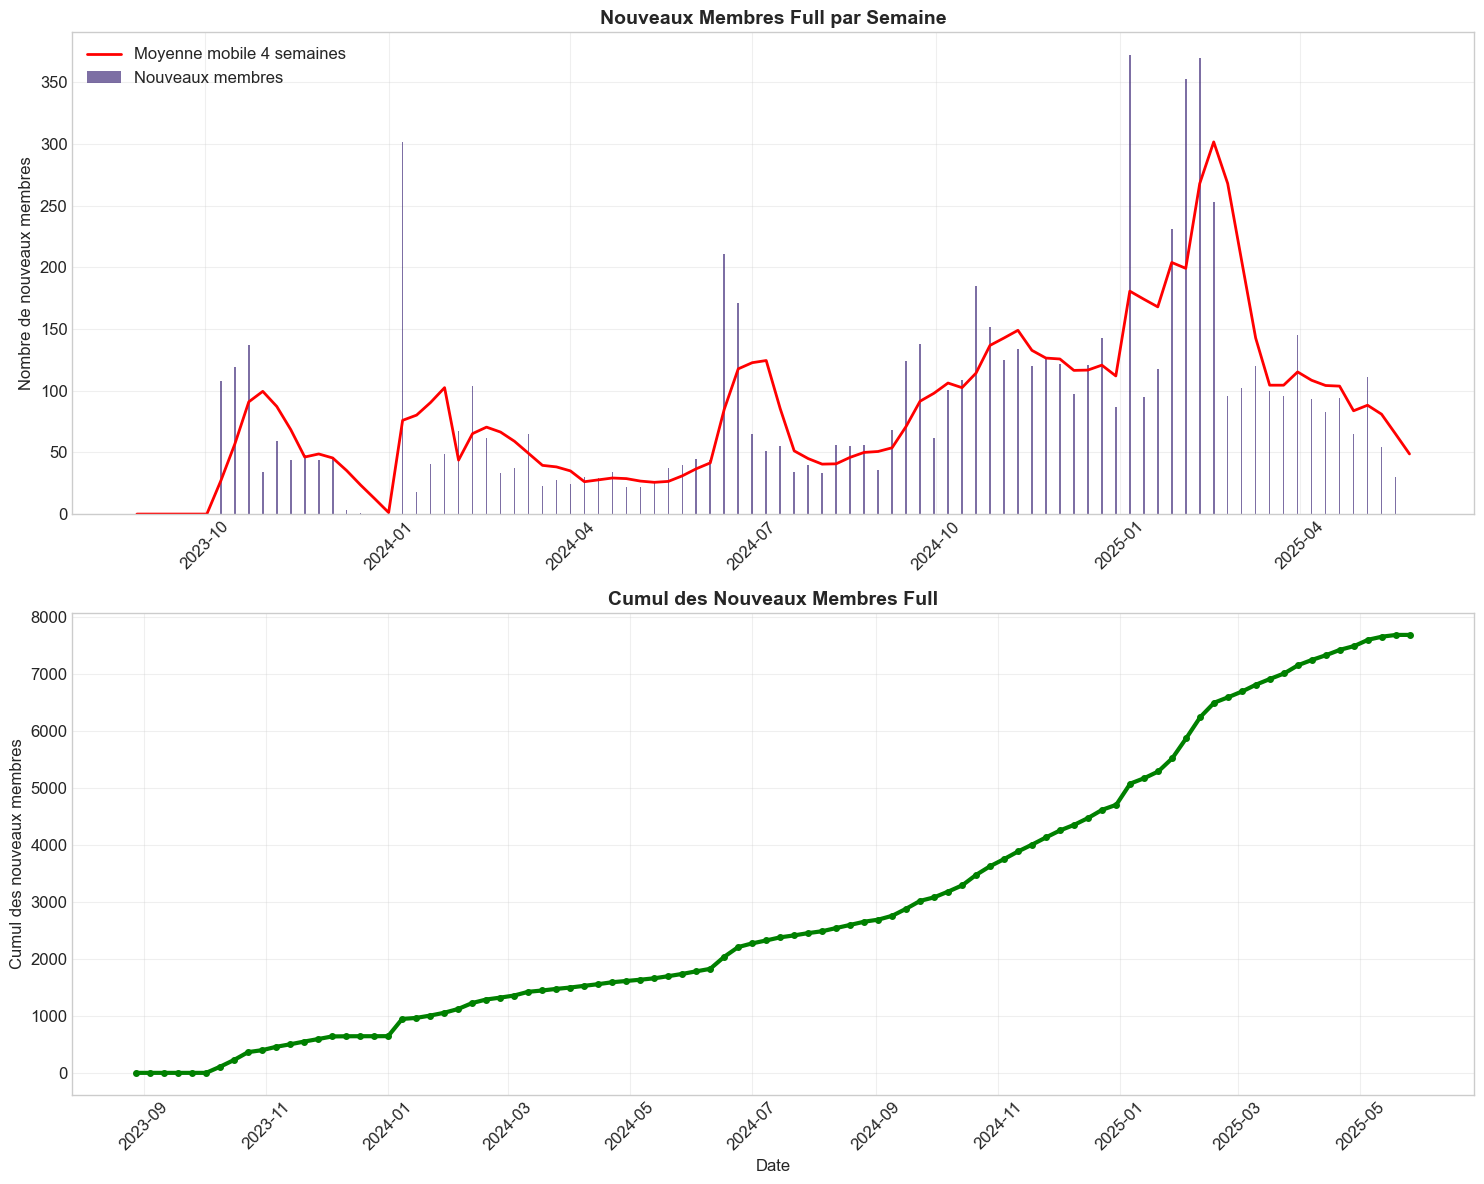


📊 ANALYSE SAISONNALITÉ ET TENDANCES
📅 MOYENNE PAR MOIS:
   • Jan: 136.3 nouveaux membres/semaine
   • Fév: 167.2 nouveaux membres/semaine
   • Mar: 79.6 nouveaux membres/semaine
   • Avr: 52.7 nouveaux membres/semaine
   • Mai: 39.9 nouveaux membres/semaine
   • Jun: 117.8 nouveaux membres/semaine
   • Jul: 49.0 nouveaux membres/semaine
   • Aoû: 40.0 nouveaux membres/semaine
   • Sep: 47.6 nouveaux membres/semaine
   • Oct: 105.0 nouveaux membres/semaine
   • Nov: 87.6 nouveaux membres/semaine
   • Déc: 68.9 nouveaux membres/semaine

📅 MOYENNE PAR TRIMESTRE:
   • Q1: 126.2 nouveaux membres/semaine
   • Q2: 60.2 nouveaux membres/semaine
   • Q3: 45.9 nouveaux membres/semaine
   • Q4: 87.2 nouveaux membres/semaine

🏆 RECORDS:
   • Meilleure semaine: 2025-01-06 (372 nouveaux)
   • Pire semaine: 2023-08-28 (0 nouveaux)

📈 CROISSANCE:
   • Premier mois (4 semaines): 0.0 nouveaux/semaine
   • Dernier mois (4 semaines): 48.8 nouveaux/semaine
   • Taux de croissance: +inf%


In [341]:
def calculate_weekly_new_members(df, start_date='2023-09-01'):
    """
    Calcule le nombre de nouveaux membres "full" qui ont rejoint chaque semaine
    
    Un nouveau "full member" est défini comme:
    - A terminé son essai et payé (paid_after_trial = True)
    - N'est pas un membre cadeau (is_gifted_member = False)
    - Premier cycle uniquement (renewal_cycle = 1)
    """
    
    print("📊 CALCUL DES NOUVEAUX MEMBRES PAR SEMAINE")
    print("=" * 50)
    
    # Préparer les données
    df_clean = df.copy()
    
    # Convertir les dates et normaliser les timezones
    date_columns = ['start_date_utc', 'current_period_start_utc', 'trial_end_utc', 'created_utc']
    
    for col in date_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col])
            # Normaliser les timezones
            if df_clean[col].dt.tz is not None:
                df_clean[col] = df_clean[col].dt.tz_localize(None)
    
    # Définir les critères pour "nouveaux full members"
    new_full_members = df_clean[
        (df_clean['paid_after_trial'] == True) &      # A payé après l'essai
        (df_clean['is_gifted_member'] == False) &     # N'est pas un cadeau
        (df_clean['renewal_cycle'] == 1)              # Premier cycle seulement
    ].copy()
    
    print(f"✅ Nouveaux membres éligibles: {len(new_full_members):,}")
    
    # Déterminer la date de "conversion" (quand ils deviennent full members)
    # Utiliser current_period_start_utc comme date de conversion (début période payée)
    new_full_members['conversion_date'] = new_full_members['current_period_start_utc']
    
    # Filtrer les membres convertis après la date de début
    start_date = pd.to_datetime(start_date).tz_localize(None)
    end_date = pd.to_datetime('2025-05-30').tz_localize(None)
    
    new_full_members = new_full_members[
        (new_full_members['conversion_date'] >= start_date) &
        (new_full_members['conversion_date'] <= end_date)
    ].copy()
    
    print(f"📅 Période analysée: {start_date.strftime('%Y-%m-%d')} à {end_date.strftime('%Y-%m-%d')}")
    print(f"📊 Nouveaux membres dans la période: {len(new_full_members):,}")
    
    # Créer une liste de toutes les semaines (lundi = début de semaine)
    weeks = []
    current_week = start_date - timedelta(days=start_date.weekday())  # Lundi de la semaine
    
    while current_week <= end_date:
        weeks.append(current_week)
        current_week += timedelta(days=7)
    
    print(f"📊 Nombre de semaines analysées: {len(weeks)}")
    
    # Calculer les nouveaux membres pour chaque semaine
    weekly_new_members = []
    
    for week_start in weeks:
        week_end = week_start + timedelta(days=7)
        
        # Compter les membres qui ont converti pendant cette semaine
        week_conversions = new_full_members[
            (new_full_members['conversion_date'] >= week_start) &
            (new_full_members['conversion_date'] < week_end)
        ]
        
        weekly_new_members.append({
            'week_start': week_start,
            'week_start_str': week_start.strftime('%Y-%m-%d'),
            'week_end': week_end,
            'new_members': len(week_conversions)
        })
    
    # Créer le DataFrame des résultats
    results_df = pd.DataFrame(weekly_new_members)
    
    # Afficher les résultats
    print(f"\n📈 NOUVEAUX MEMBRES PAR SEMAINE:")
    print(f"{'Semaine':<12} {'Nouveaux':<10} {'Cumul':<10} {'Moy. Mobile 4s':<15}")
    print("-" * 50)
    
    cumul = 0
    results_df['cumulative'] = results_df['new_members'].cumsum()
    results_df['rolling_avg_4w'] = results_df['new_members'].rolling(window=4, min_periods=1).mean()
    
    for i, row in results_df.iterrows():
        rolling_avg = row['rolling_avg_4w']
        print(f"{row['week_start_str']:<12} {row['new_members']:<10} {row['cumulative']:<10} {rolling_avg:<15.1f}")
    
    # Statistiques résumées
    print(f"\n📊 STATISTIQUES RÉSUMÉES:")
    print(f"   • Total nouveaux membres: {results_df['new_members'].sum():,}")
    print(f"   • Maximum par semaine: {results_df['new_members'].max():,}")
    print(f"   • Minimum par semaine: {results_df['new_members'].min():,}")
    print(f"   • Moyenne par semaine: {results_df['new_members'].mean():.1f}")
    print(f"   • Médiane par semaine: {results_df['new_members'].median():.1f}")
    
    # Tendances récentes
    recent_4_weeks = results_df.tail(4)['new_members'].mean()
    previous_4_weeks = results_df.tail(8).head(4)['new_members'].mean()
    
    print(f"\n📈 TENDANCES RÉCENTES:")
    print(f"   • Moyenne 4 dernières semaines: {recent_4_weeks:.1f}")
    print(f"   • Moyenne 4 semaines précédentes: {previous_4_weeks:.1f}")
    
    if recent_4_weeks > previous_4_weeks:
        trend = f"📈 Tendance: +{((recent_4_weeks/previous_4_weeks)-1)*100:.1f}%"
    elif recent_4_weeks < previous_4_weeks:
        trend = f"📉 Tendance: {((recent_4_weeks/previous_4_weeks)-1)*100:.1f}%"
    else:
        trend = "➡️ Tendance: Stable"
    
    print(f"   • {trend}")
    
    return results_df, new_full_members

def plot_weekly_new_members(results_df):
    """
    Crée des graphiques pour visualiser les nouveaux membres
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Graphique 1: Nouveaux membres par semaine avec moyenne mobile
    ax1.bar(results_df['week_start'], results_df['new_members'], alpha=0.7, label='Nouveaux membres')
    ax1.plot(results_df['week_start'], results_df['rolling_avg_4w'], 
             color='red', linewidth=2, label='Moyenne mobile 4 semaines')
    
    ax1.set_title('Nouveaux Membres Full par Semaine', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Nombre de nouveaux membres')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Graphique 2: Cumul des nouveaux membres
    ax2.plot(results_df['week_start'], results_df['cumulative'], 
             linewidth=3, marker='o', markersize=4, color='green')
    
    ax2.set_title('Cumul des Nouveaux Membres Full', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumul des nouveaux membres')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def analyze_seasonality_and_trends(results_df, new_members_data):
    """
    Analyse la saisonnalité et les tendances des nouveaux membres
    """
    print(f"\n📊 ANALYSE SAISONNALITÉ ET TENDANCES")
    print("=" * 45)
    
    # Ajouter des informations temporelles
    results_df['month'] = results_df['week_start'].dt.month
    results_df['quarter'] = results_df['week_start'].dt.quarter
    results_df['year'] = results_df['week_start'].dt.year
    
    # Analyse par mois
    monthly_avg = results_df.groupby('month')['new_members'].mean().round(1)
    print(f"📅 MOYENNE PAR MOIS:")
    month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 
                   'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']
    
    for month, avg in monthly_avg.items():
        print(f"   • {month_names[month-1]}: {avg:.1f} nouveaux membres/semaine")
    
    # Analyse par trimestre
    quarterly_avg = results_df.groupby('quarter')['new_members'].mean().round(1)
    print(f"\n📅 MOYENNE PAR TRIMESTRE:")
    for quarter, avg in quarterly_avg.items():
        print(f"   • Q{quarter}: {avg:.1f} nouveaux membres/semaine")
    
    # Meilleurs et pires semaines
    best_week = results_df.loc[results_df['new_members'].idxmax()]
    worst_week = results_df.loc[results_df['new_members'].idxmin()]
    
    print(f"\n🏆 RECORDS:")
    print(f"   • Meilleure semaine: {best_week['week_start_str']} ({best_week['new_members']} nouveaux)")
    print(f"   • Pire semaine: {worst_week['week_start_str']} ({worst_week['new_members']} nouveaux)")
    
    # Analyse de croissance
    first_month_avg = results_df.head(4)['new_members'].mean()
    last_month_avg = results_df.tail(4)['new_members'].mean()
    
    growth_rate = ((last_month_avg - first_month_avg) / first_month_avg) * 100
    print(f"\n📈 CROISSANCE:")
    print(f"   • Premier mois (4 semaines): {first_month_avg:.1f} nouveaux/semaine")
    print(f"   • Dernier mois (4 semaines): {last_month_avg:.1f} nouveaux/semaine")
    print(f"   • Taux de croissance: {growth_rate:+.1f}%")
    
    return results_df

# UTILISATION:
weekly_new_results, new_members_details = calculate_weekly_new_members(df_enhanced)
plot_weekly_new_members(weekly_new_results)
seasonality_analysis = analyze_seasonality_and_trends(weekly_new_results, new_members_details)

📊 CALCUL DU CHURN DES MEMBRES PAR SEMAINE
✅ Membres full ayant churné: 2,699
📅 Période analysée: 2023-09-01 à 2025-05-30
📊 Churns dans la période: 2,699

📋 TYPES DE CHURN:
   • Cancellation: 1,916 (71.0%)
   • Refund: 783 (29.0%)
📊 Nombre de semaines analysées: 92

📈 CHURNS PAR SEMAINE:
Semaine      Total    Refunds  Cancel   Expire   Cumul    Moy 4s  
----------------------------------------------------------------------
2023-08-28   0        0        0        0        0        0.0     
2023-09-04   0        0        0        0        0        0.0     
2023-09-11   0        0        0        0        0        0.0     
2023-09-18   0        0        0        0        0        0.0     
2023-09-25   0        0        0        0        0        0.0     
2023-10-02   0        0        0        0        0        0.0     
2023-10-09   7        7        0        0        7        1.8     
2023-10-16   12       12       0        0        19       4.8     
2023-10-23   79       25       54     

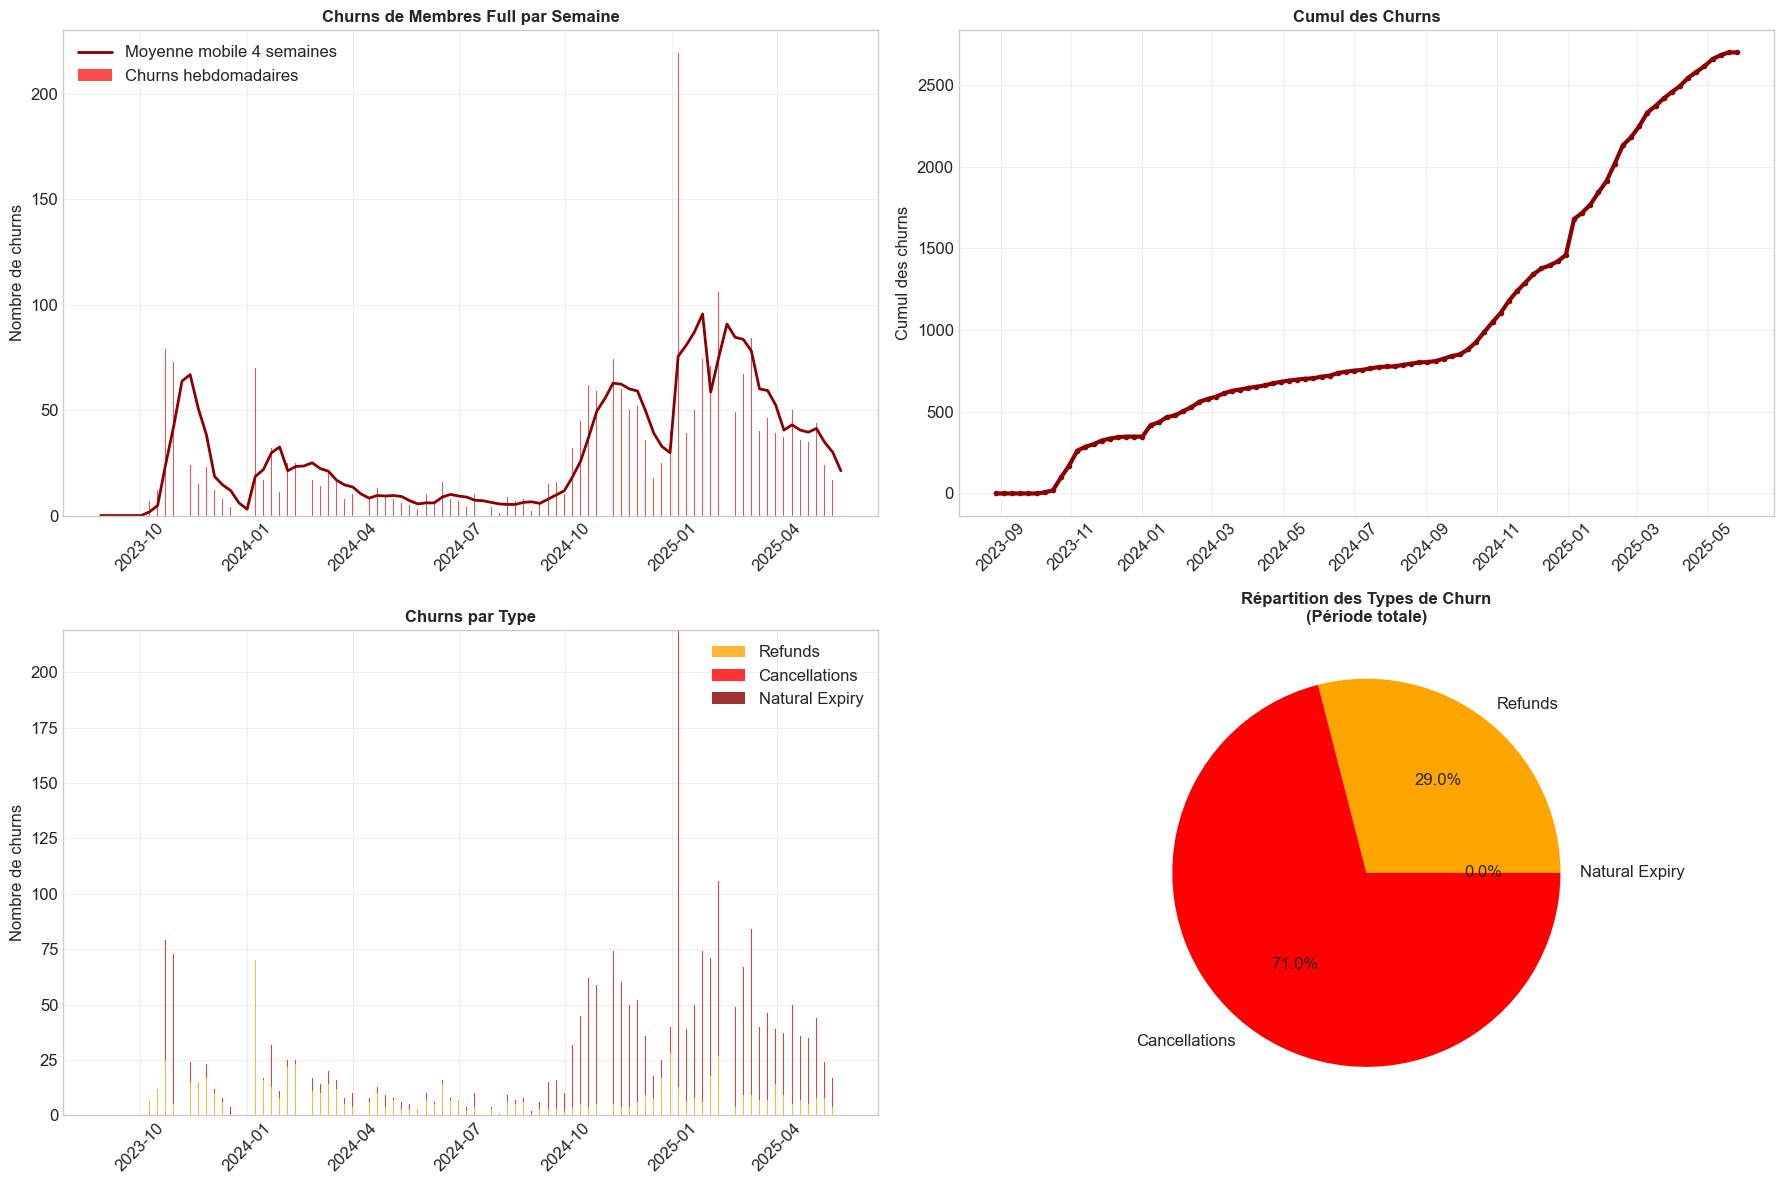


🔍 ANALYSE DES PATTERNS DE CHURN
📅 CHURN MOYEN PAR MOIS:
   • Jan: 56.9 churns/semaine
   • Fév: 54.8 churns/semaine
   • Mar: 37.1 churns/semaine
   • Avr: 22.8 churns/semaine
   • Mai: 13.4 churns/semaine
   • Jun: 10.0 churns/semaine
   • Jul: 6.4 churns/semaine
   • Aoû: 5.0 churns/semaine
   • Sep: 5.4 churns/semaine
   • Oct: 41.0 churns/semaine
   • Nov: 49.1 churns/semaine
   • Déc: 21.7 churns/semaine

🔄 CHURN PAR CYCLE DE RENOUVELLEMENT:
   • Cycle 1: 2,598 churns (96.3%)
   • Cycle 2: 96 churns (3.6%)
   • Cycle 3: 5 churns (0.2%)

📋 TOP MOTIFS DE CHURN:
   • cancellation_requested: 2,232 (82.7%)
   • payment_failed: 467 (17.3%)

📊 MÉTRIQUES AVANCÉES:
   • Écart-type du churn: 33.3
   • Coefficient de variation: 113.4%

⚠️  SEMAINES AVEC PIC DE CHURN (> 96):
   • 2025-01-06: 219 churns
   • 2025-02-10: 106 churns
   • 2025-02-17: 112 churns


In [342]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

def calculate_weekly_churned_members(df, start_date='2023-09-01'):
    """
    Calcule le nombre de membres "full" qui ont churné chaque semaine
    
    Un membre "full" churné est défini comme:
    - Était un full member (paid_after_trial = True, is_gifted_member = False)
    - A une date de fin effective (ended_at_utc)
    - Sa membership s'est terminée pendant la semaine analysée
    """
    
    print("📊 CALCUL DU CHURN DES MEMBRES PAR SEMAINE")
    print("=" * 50)
    
    # Préparer les données
    df_clean = df.copy()
    
    # Convertir les dates et normaliser les timezones
    date_columns = ['start_date_utc', 'current_period_start_utc', 'current_period_end_utc',
                   'ended_at_utc', 'canceled_at_utc', 'trial_end_utc']
    
    for col in date_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col])
            # Normaliser les timezones
            if df_clean[col].dt.tz is not None:
                df_clean[col] = df_clean[col].dt.tz_localize(None)
    
    # Définir les critères pour "full members qui ont churné"
    churned_full_members = df_clean[
        (df_clean['paid_after_trial'] == True) &      # Était un full member
        (df_clean['is_gifted_member'] == False) &     # N'était pas un cadeau
        (df_clean['ended_at_utc'].notna())            # A une date de fin
    ].copy()
    
    print(f"✅ Membres full ayant churné: {len(churned_full_members):,}")
    
    # Utiliser ended_at_utc comme date de churn
    churned_full_members['churn_date'] = churned_full_members['ended_at_utc']
    
    # Filtrer les churns après la date de début
    start_date = pd.to_datetime(start_date).tz_localize(None)
    end_date = pd.to_datetime('2025-05-30').tz_localize(None)
    
    churned_full_members = churned_full_members[
        (churned_full_members['churn_date'] >= start_date) &
        (churned_full_members['churn_date'] <= end_date)
    ].copy()
    
    print(f"📅 Période analysée: {start_date.strftime('%Y-%m-%d')} à {end_date.strftime('%Y-%m-%d')}")
    print(f"📊 Churns dans la période: {len(churned_full_members):,}")
    
    # Analyser les types de churn
    print(f"\n📋 TYPES DE CHURN:")
    
    # Ajouter une classification du type de churn
    def classify_churn_type(row):
        if pd.notna(row.get('was_refund')) and row['was_refund']:
            return 'Refund'
        elif pd.notna(row.get('canceled_at_utc')):
            return 'Cancellation'
        else:
            return 'Natural Expiry'
    
    churned_full_members['churn_type'] = churned_full_members.apply(classify_churn_type, axis=1)
    
    churn_type_counts = churned_full_members['churn_type'].value_counts()
    for churn_type, count in churn_type_counts.items():
        pct = count / len(churned_full_members) * 100
        print(f"   • {churn_type}: {count:,} ({pct:.1f}%)")
    
    # Créer une liste de toutes les semaines
    weeks = []
    current_week = start_date - timedelta(days=start_date.weekday())  # Lundi de la semaine
    
    while current_week <= end_date:
        weeks.append(current_week)
        current_week += timedelta(days=7)
    
    print(f"📊 Nombre de semaines analysées: {len(weeks)}")
    
    # Calculer les churns pour chaque semaine
    weekly_churns = []
    
    for week_start in weeks:
        week_end = week_start + timedelta(days=7)
        
        # Compter les membres qui ont churné pendant cette semaine
        week_churns = churned_full_members[
            (churned_full_members['churn_date'] >= week_start) &
            (churned_full_members['churn_date'] < week_end)
        ]
        
        # Détail par type de churn
        churn_details = week_churns['churn_type'].value_counts().to_dict()
        
        weekly_churns.append({
            'week_start': week_start,
            'week_start_str': week_start.strftime('%Y-%m-%d'),
            'week_end': week_end,
            'total_churns': len(week_churns),
            'refunds': churn_details.get('Refund', 0),
            'cancellations': churn_details.get('Cancellation', 0),
            'natural_expiry': churn_details.get('Natural Expiry', 0)
        })
    
    # Créer le DataFrame des résultats
    results_df = pd.DataFrame(weekly_churns)
    
    # Calculer des métriques supplémentaires
    results_df['cumulative_churns'] = results_df['total_churns'].cumsum()
    results_df['rolling_avg_4w'] = results_df['total_churns'].rolling(window=4, min_periods=1).mean()
    
    # Afficher les résultats
    print(f"\n📈 CHURNS PAR SEMAINE:")
    print(f"{'Semaine':<12} {'Total':<8} {'Refunds':<8} {'Cancel':<8} {'Expire':<8} {'Cumul':<8} {'Moy 4s':<8}")
    print("-" * 70)
    
    for i, row in results_df.iterrows():
        print(f"{row['week_start_str']:<12} {row['total_churns']:<8} {row['refunds']:<8} "
              f"{row['cancellations']:<8} {row['natural_expiry']:<8} {row['cumulative_churns']:<8} "
              f"{row['rolling_avg_4w']:<8.1f}")
    
    # Statistiques résumées
    print(f"\n📊 STATISTIQUES RÉSUMÉES:")
    print(f"   • Total churns: {results_df['total_churns'].sum():,}")
    print(f"   • Maximum par semaine: {results_df['total_churns'].max():,}")
    print(f"   • Minimum par semaine: {results_df['total_churns'].min():,}")
    print(f"   • Moyenne par semaine: {results_df['total_churns'].mean():.1f}")
    print(f"   • Médiane par semaine: {results_df['total_churns'].median():.1f}")
    
    # Tendances récentes
    recent_4_weeks = results_df.tail(4)['total_churns'].mean()
    previous_4_weeks = results_df.tail(8).head(4)['total_churns'].mean()
    
    print(f"\n📈 TENDANCES RÉCENTES:")
    print(f"   • Moyenne 4 dernières semaines: {recent_4_weeks:.1f}")
    print(f"   • Moyenne 4 semaines précédentes: {previous_4_weeks:.1f}")
    
    if recent_4_weeks > previous_4_weeks:
        trend = f"📈 Tendance churn: +{((recent_4_weeks/previous_4_weeks)-1)*100:.1f}%"
    elif recent_4_weeks < previous_4_weeks:
        trend = f"📉 Tendance churn: {((recent_4_weeks/previous_4_weeks)-1)*100:.1f}%"
    else:
        trend = "➡️ Tendance churn: Stable"
    
    print(f"   • {trend}")
    
    return results_df, churned_full_members

def plot_weekly_churns(results_df):
    """
    Crée des graphiques pour visualiser les churns
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # Graphique 1: Churns totaux par semaine avec moyenne mobile
    ax1.bar(results_df['week_start'], results_df['total_churns'], alpha=0.7, 
            color='red', label='Churns hebdomadaires')
    ax1.plot(results_df['week_start'], results_df['rolling_avg_4w'], 
             color='darkred', linewidth=2, label='Moyenne mobile 4 semaines')
    
    ax1.set_title('Churns de Membres Full par Semaine', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Nombre de churns')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Graphique 2: Cumul des churns
    ax2.plot(results_df['week_start'], results_df['cumulative_churns'], 
             linewidth=3, marker='o', markersize=3, color='darkred')
    
    ax2.set_title('Cumul des Churns', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Cumul des churns')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Graphique 3: Churns par type (stacked)
    ax3.bar(results_df['week_start'], results_df['refunds'], 
            label='Refunds', alpha=0.8, color='orange')
    ax3.bar(results_df['week_start'], results_df['cancellations'], 
            bottom=results_df['refunds'], label='Cancellations', alpha=0.8, color='red')
    ax3.bar(results_df['week_start'], results_df['natural_expiry'], 
            bottom=results_df['refunds'] + results_df['cancellations'], 
            label='Natural Expiry', alpha=0.8, color='darkred')
    
    ax3.set_title('Churns par Type', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Nombre de churns')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # Graphique 4: Distribution des churns par type (pie chart pour la période totale)
    total_by_type = {
        'Refunds': results_df['refunds'].sum(),
        'Cancellations': results_df['cancellations'].sum(),
        'Natural Expiry': results_df['natural_expiry'].sum()
    }
    
    ax4.pie(total_by_type.values(), labels=total_by_type.keys(), autopct='%1.1f%%',
            colors=['orange', 'red', 'darkred'])
    ax4.set_title('Répartition des Types de Churn\n(Période totale)', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def analyze_churn_patterns(results_df, churned_members_data):
    """
    Analyse les patterns de churn
    """
    print(f"\n🔍 ANALYSE DES PATTERNS DE CHURN")
    print("=" * 45)
    
    # Ajouter des informations temporelles
    results_df['month'] = results_df['week_start'].dt.month
    results_df['quarter'] = results_df['week_start'].dt.quarter
    
    # Analyse saisonnière
    monthly_avg = results_df.groupby('month')['total_churns'].mean().round(1)
    print(f"📅 CHURN MOYEN PAR MOIS:")
    month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 
                   'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']
    
    for month, avg in monthly_avg.items():
        print(f"   • {month_names[month-1]}: {avg:.1f} churns/semaine")
    
    # Analyse des cycles de churn
    if 'renewal_cycle' in churned_members_data.columns:
        print(f"\n🔄 CHURN PAR CYCLE DE RENOUVELLEMENT:")
        cycle_churns = churned_members_data['renewal_cycle'].value_counts().sort_index()
        
        for cycle, count in cycle_churns.items():
            pct = count / len(churned_members_data) * 100
            print(f"   • Cycle {cycle}: {count:,} churns ({pct:.1f}%)")
    
    # Analyse des motifs de churn
    if 'Cancellation Reason' in churned_members_data.columns:
        print(f"\n📋 TOP MOTIFS DE CHURN:")
        top_reasons = churned_members_data['Cancellation Reason'].value_counts().head(5)
        
        for reason, count in top_reasons.items():
            pct = count / len(churned_members_data) * 100
            print(f"   • {reason}: {count:,} ({pct:.1f}%)")
    
    # Calcul de métriques de churn avancées
    print(f"\n📊 MÉTRIQUES AVANCÉES:")
    
    # Variance du churn (stabilité)
    churn_variance = results_df['total_churns'].var()
    churn_std = results_df['total_churns'].std()
    print(f"   • Écart-type du churn: {churn_std:.1f}")
    print(f"   • Coefficient de variation: {(churn_std/results_df['total_churns'].mean())*100:.1f}%")
    
    # Semaines avec pic de churn
    high_churn_threshold = results_df['total_churns'].mean() + 2 * churn_std
    high_churn_weeks = results_df[results_df['total_churns'] > high_churn_threshold]
    
    if len(high_churn_weeks) > 0:
        print(f"\n⚠️  SEMAINES AVEC PIC DE CHURN (> {high_churn_threshold:.0f}):")
        for _, week in high_churn_weeks.iterrows():
            print(f"   • {week['week_start_str']}: {week['total_churns']} churns")
    
    return results_df

def calculate_net_growth_analysis(new_members_df, churned_members_df):
    """
    Combine l'analyse des nouveaux membres et des churns pour calculer la croissance nette
    """
    print(f"\n📈 ANALYSE DE CROISSANCE NETTE")
    print("=" * 40)
    
    # Fusionner les données
    growth_df = pd.merge(new_members_df, churned_members_df, 
                        on=['week_start', 'week_start_str'], 
                        suffixes=('_new', '_churn'))
    
    # Calculer la croissance nette
    growth_df['net_growth'] = growth_df['new_members'] - growth_df['total_churns']
    growth_df['cumulative_net_growth'] = growth_df['net_growth'].cumsum()
    
    print(f"📊 CROISSANCE NETTE PAR SEMAINE:")
    print(f"{'Semaine':<12} {'Nouveaux':<8} {'Churns':<8} {'Net':<8} {'Cumul Net':<10}")
    print("-" * 50)
    
    for _, row in growth_df.tail(8).iterrows():  # Dernières 8 semaines
        net_sign = "+" if row['net_growth'] >= 0 else ""
        print(f"{row['week_start_str']:<12} {row['new_members']:<8} {row['total_churns']:<8} "
              f"{net_sign}{row['net_growth']:<7} {row['cumulative_net_growth']:<10}")
    
    # Statistiques
    avg_new = growth_df['new_members'].mean()
    avg_churn = growth_df['total_churns'].mean()
    avg_net = growth_df['net_growth'].mean()
    
    print(f"\n📊 MOYENNES:")
    print(f"   • Nouveaux membres/semaine: {avg_new:.1f}")
    print(f"   • Churns/semaine: {avg_churn:.1f}")
    print(f"   • Croissance nette/semaine: {avg_net:+.1f}")
    
    return growth_df

# UTILISATION:
weekly_churn_results, churned_members_details = calculate_weekly_churned_members(df_enhanced)
plot_weekly_churns(weekly_churn_results)
churn_analysis = analyze_churn_patterns(weekly_churn_results, churned_members_details)

In [343]:
net_growth_analysis = calculate_net_growth_analysis(weekly_new_results, weekly_churn_results)


📈 ANALYSE DE CROISSANCE NETTE
📊 CROISSANCE NETTE PAR SEMAINE:
Semaine      Nouveaux Churns   Net      Cumul Net 
--------------------------------------------------
2025-04-07   93       37       +56      4754      
2025-04-14   83       50       +33      4787      
2025-04-21   94       36       +58      4845      
2025-04-28   65       35       +30      4875      
2025-05-05   111      44       +67      4942      
2025-05-12   54       24       +30      4972      
2025-05-19   30       17       +13      4985      
2025-05-26   0        0        +0       4985      

📊 MOYENNES:
   • Nouveaux membres/semaine: 83.5
   • Churns/semaine: 29.3
   • Croissance nette/semaine: +54.2


📊 CALCUL DES INSCRIPTIONS D'ESSAI PAR SEMAINE
✅ Total nouveaux trials (tous cycles 1): 17,127
✅ Trials avec date d'inscription: 17,127
📅 Période analysée: 2023-01-01 à 2025-05-30
📊 Inscriptions d'essai dans la période: 17,127

📋 RÉPARTITION DES INSCRIPTIONS:
   • Inscriptions normales: 16,262 (94.9%)
   • Inscriptions cadeaux: 865 (5.1%)

📊 OUTCOMES ACTUELS:
   • Ont payé après essai: 8,229 (48.0%)
   • Seulement essai: 8,443 (49.3%)
   • Actuellement en essai: 140 (0.8%)
📊 Nombre de semaines analysées: 127

📈 INSCRIPTIONS D'ESSAI PAR SEMAINE (12 dernières):
Semaine      Total    Normal   Cadeau   Cumul    Moy 4s  
------------------------------------------------------------
2025-03-10   150      140      10       15796    134.0   
2025-03-17   186      178      8        15982    151.5   
2025-03-24   176      170      6        16158    160.8   
2025-03-31   148      143      5        16306    165.0   
2025-04-07   136      128      8        16442    161.5   
2025-04-14   116      108 

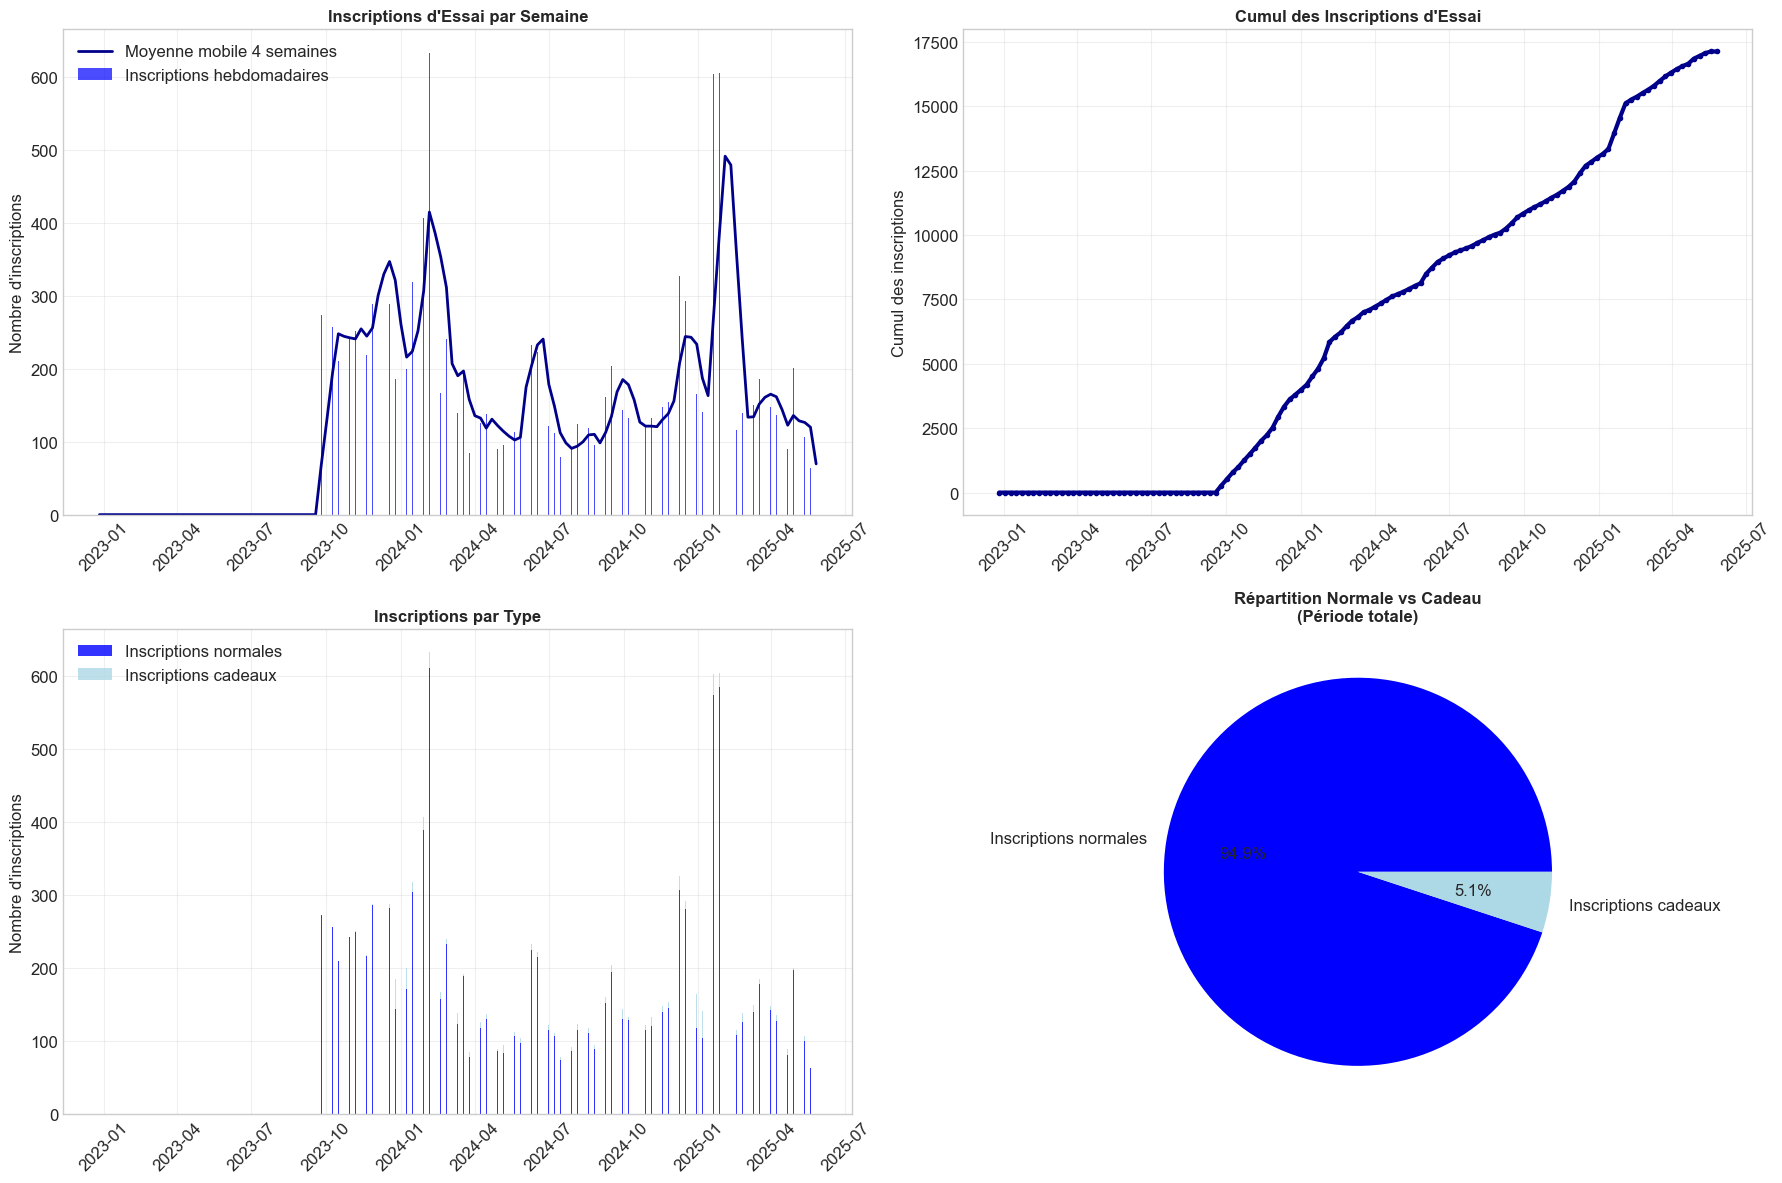


🔍 ANALYSE DES PATTERNS D'INSCRIPTION
📅 INSCRIPTIONS MOYENNES PAR MOIS:
   • Jan: 211.4 inscriptions/semaine
   • Fév: 184.0 inscriptions/semaine
   • Mar: 109.5 inscriptions/semaine
   • Avr: 88.9 inscriptions/semaine
   • Mai: 53.9 inscriptions/semaine
   • Jun: 120.2 inscriptions/semaine
   • Jul: 48.5 inscriptions/semaine
   • Aoû: 55.0 inscriptions/semaine
   • Sep: 121.1 inscriptions/semaine
   • Oct: 189.4 inscriptions/semaine
   • Nov: 197.0 inscriptions/semaine
   • Déc: 242.2 inscriptions/semaine

📊 INSCRIPTIONS PAR ANNÉE:
   • 2022: 0 inscriptions (0.0/semaine)
   • 2023: 3,801 inscriptions (73.1/semaine)
   • 2024: 9,206 inscriptions (173.7/semaine)
   • 2025: 4,120 inscriptions (196.2/semaine)

📈 ANALYSE DE CROISSANCE:

🏆 RECORDS:
   • Meilleure semaine: 2024-02-05 (633 inscriptions)
   • Pire semaine: 2022-12-26 (0 inscriptions)

📊 STABILITÉ DES INSCRIPTIONS:
   • Écart-type: 134.6
   • Coefficient de variation: 99.8%
   ❗ Inscriptions très variables

🎯 ANALYSE DU FUNNEL 

In [344]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

def calculate_weekly_trial_signups(df, start_date='2023-01-01'):
    """
    Calcule le nombre de nouveaux membres qui ont commencé un essai chaque semaine
    
    Un nouveau trial signup est défini comme:
    - Premier cycle (renewal_cycle = 1) 
    - A une date de début d'essai (trial_start_utc)
    - Inclut tous les types: cadeaux et non-cadeaux
    """
    
    print("📊 CALCUL DES INSCRIPTIONS D'ESSAI PAR SEMAINE")
    print("=" * 55)
    
    # Préparer les données
    df_clean = df.copy()
    
    # Convertir les dates et normaliser les timezones
    date_columns = ['trial_start_utc', 'created_utc', 'start_date_utc', 'start_utc']
    
    for col in date_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col])
            # Normaliser les timezones
            if df_clean[col].dt.tz is not None:
                df_clean[col] = df_clean[col].dt.tz_localize(None)
    
    # Filtrer les nouveaux trials (premier cycle uniquement)
    new_trials = df_clean[
        (df_clean['renewal_cycle'] == 1)  # Premier cycle seulement
    ].copy()
    
    print(f"✅ Total nouveaux trials (tous cycles 1): {len(new_trials):,}")
    
    # Déterminer la date d'inscription à l'essai
    # Priorité: trial_start_utc > start_utc > created_utc > start_date_utc
    def get_signup_date(row):
        for col in ['trial_start_utc', 'start_utc', 'created_utc', 'start_date_utc']:
            if col in row and pd.notna(row[col]):
                return row[col]
        return None
    
    new_trials['signup_date'] = new_trials.apply(get_signup_date, axis=1)
    
    # Filtrer les lignes avec une date d'inscription valide
    new_trials = new_trials[new_trials['signup_date'].notna()].copy()
    
    print(f"✅ Trials avec date d'inscription: {len(new_trials):,}")
    
    # Filtrer par période d'analyse
    start_date = pd.to_datetime(start_date).tz_localize(None)
    end_date = pd.to_datetime('2025-05-30').tz_localize(None)
    
    new_trials = new_trials[
        (new_trials['signup_date'] >= start_date) &
        (new_trials['signup_date'] <= end_date)
    ].copy()
    
    print(f"📅 Période analysée: {start_date.strftime('%Y-%m-%d')} à {end_date.strftime('%Y-%m-%d')}")
    print(f"📊 Inscriptions d'essai dans la période: {len(new_trials):,}")
    
    # Analyser la répartition par type
    print(f"\n📋 RÉPARTITION DES INSCRIPTIONS:")
    
    # Par type (cadeau vs normal)
    gift_count = (new_trials['is_gifted_member'] == True).sum()
    regular_count = (new_trials['is_gifted_member'] == False).sum()
    print(f"   • Inscriptions normales: {regular_count:,} ({regular_count/len(new_trials)*100:.1f}%)")
    print(f"   • Inscriptions cadeaux: {gift_count:,} ({gift_count/len(new_trials)*100:.1f}%)")
    
    # Par outcome actuel
    if 'paid_after_trial' in new_trials.columns:
        paid_count = (new_trials['paid_after_trial'] == True).sum()
        only_trial_count = (new_trials['only_trial'] == True).sum()
        currently_trialing = (new_trials['is_currently_trialing'] == True).sum()
        
        print(f"\n📊 OUTCOMES ACTUELS:")
        print(f"   • Ont payé après essai: {paid_count:,} ({paid_count/len(new_trials)*100:.1f}%)")
        print(f"   • Seulement essai: {only_trial_count:,} ({only_trial_count/len(new_trials)*100:.1f}%)")
        print(f"   • Actuellement en essai: {currently_trialing:,} ({currently_trialing/len(new_trials)*100:.1f}%)")
    
    # Créer une liste de toutes les semaines
    weeks = []
    current_week = start_date - timedelta(days=start_date.weekday())  # Lundi de la semaine
    
    while current_week <= end_date:
        weeks.append(current_week)
        current_week += timedelta(days=7)
    
    print(f"📊 Nombre de semaines analysées: {len(weeks)}")
    
    # Calculer les inscriptions pour chaque semaine
    weekly_signups = []
    
    for week_start in weeks:
        week_end = week_start + timedelta(days=7)
        
        # Compter les inscriptions pendant cette semaine
        week_trials = new_trials[
            (new_trials['signup_date'] >= week_start) &
            (new_trials['signup_date'] < week_end)
        ]
        
        # Détail par type
        regular_signups = (week_trials['is_gifted_member'] == False).sum()
        gift_signups = (week_trials['is_gifted_member'] == True).sum()
        
        weekly_signups.append({
            'week_start': week_start,
            'week_start_str': week_start.strftime('%Y-%m-%d'),
            'week_end': week_end,
            'total_signups': len(week_trials),
            'regular_signups': regular_signups,
            'gift_signups': gift_signups
        })
    
    # Créer le DataFrame des résultats
    results_df = pd.DataFrame(weekly_signups)
    
    # Calculer des métriques supplémentaires
    results_df['cumulative_signups'] = results_df['total_signups'].cumsum()
    results_df['rolling_avg_4w'] = results_df['total_signups'].rolling(window=4, min_periods=1).mean()
    
    # Afficher les résultats (dernières 12 semaines)
    print(f"\n📈 INSCRIPTIONS D'ESSAI PAR SEMAINE (12 dernières):")
    print(f"{'Semaine':<12} {'Total':<8} {'Normal':<8} {'Cadeau':<8} {'Cumul':<8} {'Moy 4s':<8}")
    print("-" * 60)
    
    for _, row in results_df.tail(12).iterrows():
        print(f"{row['week_start_str']:<12} {row['total_signups']:<8} {row['regular_signups']:<8} "
              f"{row['gift_signups']:<8} {row['cumulative_signups']:<8} {row['rolling_avg_4w']:<8.1f}")
    
    # Statistiques résumées
    print(f"\n📊 STATISTIQUES RÉSUMÉES:")
    print(f"   • Total inscriptions: {results_df['total_signups'].sum():,}")
    print(f"   • Maximum par semaine: {results_df['total_signups'].max():,}")
    print(f"   • Minimum par semaine: {results_df['total_signups'].min():,}")
    print(f"   • Moyenne par semaine: {results_df['total_signups'].mean():.1f}")
    print(f"   • Médiane par semaine: {results_df['total_signups'].median():.1f}")
    
    # Tendances récentes
    recent_4_weeks = results_df.tail(4)['total_signups'].mean()
    previous_4_weeks = results_df.tail(8).head(4)['total_signups'].mean()
    
    print(f"\n📈 TENDANCES RÉCENTES:")
    print(f"   • Moyenne 4 dernières semaines: {recent_4_weeks:.1f}")
    print(f"   • Moyenne 4 semaines précédentes: {previous_4_weeks:.1f}")
    
    if recent_4_weeks > previous_4_weeks:
        trend = f"📈 Tendance: +{((recent_4_weeks/previous_4_weeks)-1)*100:.1f}%"
    elif recent_4_weeks < previous_4_weeks:
        trend = f"📉 Tendance: {((recent_4_weeks/previous_4_weeks)-1)*100:.1f}%"
    else:
        trend = "➡️ Tendance: Stable"
    
    print(f"   • {trend}")
    
    return results_df, new_trials

def plot_weekly_trial_signups(results_df):
    """
    Crée des graphiques pour visualiser les inscriptions d'essai
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # Graphique 1: Inscriptions totales par semaine avec moyenne mobile
    ax1.bar(results_df['week_start'], results_df['total_signups'], alpha=0.7, 
            color='blue', label='Inscriptions hebdomadaires')
    ax1.plot(results_df['week_start'], results_df['rolling_avg_4w'], 
             color='darkblue', linewidth=2, label='Moyenne mobile 4 semaines')
    
    ax1.set_title('Inscriptions d\'Essai par Semaine', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Nombre d\'inscriptions')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Graphique 2: Cumul des inscriptions
    ax2.plot(results_df['week_start'], results_df['cumulative_signups'], 
             linewidth=3, marker='o', markersize=3, color='darkblue')
    
    ax2.set_title('Cumul des Inscriptions d\'Essai', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Cumul des inscriptions')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Graphique 3: Inscriptions par type (stacked)
    ax3.bar(results_df['week_start'], results_df['regular_signups'], 
            label='Inscriptions normales', alpha=0.8, color='blue')
    ax3.bar(results_df['week_start'], results_df['gift_signups'], 
            bottom=results_df['regular_signups'], label='Inscriptions cadeaux', 
            alpha=0.8, color='lightblue')
    
    ax3.set_title('Inscriptions par Type', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Nombre d\'inscriptions')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # Graphique 4: Distribution normale vs cadeau (pie chart pour la période totale)
    total_regular = results_df['regular_signups'].sum()
    total_gift = results_df['gift_signups'].sum()
    
    if total_gift > 0:
        ax4.pie([total_regular, total_gift], 
                labels=['Inscriptions normales', 'Inscriptions cadeaux'], 
                autopct='%1.1f%%', colors=['blue', 'lightblue'])
        ax4.set_title('Répartition Normale vs Cadeau\n(Période totale)', 
                      fontsize=12, fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'Pas d\'inscriptions\ncadeaux détectées', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Répartition par Type', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def analyze_trial_signup_patterns(results_df, trial_data):
    """
    Analyse les patterns d'inscription d'essai
    """
    print(f"\n🔍 ANALYSE DES PATTERNS D'INSCRIPTION")
    print("=" * 45)
    
    # Ajouter des informations temporelles
    results_df['month'] = results_df['week_start'].dt.month
    results_df['quarter'] = results_df['week_start'].dt.quarter
    results_df['year'] = results_df['week_start'].dt.year
    
    # Analyse saisonnière
    monthly_avg = results_df.groupby('month')['total_signups'].mean().round(1)
    print(f"📅 INSCRIPTIONS MOYENNES PAR MOIS:")
    month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 
                   'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']
    
    for month, avg in monthly_avg.items():
        print(f"   • {month_names[month-1]}: {avg:.1f} inscriptions/semaine")
    
    # Analyse par année
    if len(results_df['year'].unique()) > 1:
        yearly_total = results_df.groupby('year')['total_signups'].sum()
        print(f"\n📊 INSCRIPTIONS PAR ANNÉE:")
        for year, total in yearly_total.items():
            weeks_in_year = len(results_df[results_df['year'] == year])
            avg_per_week = total / weeks_in_year
            print(f"   • {year}: {total:,} inscriptions ({avg_per_week:.1f}/semaine)")
    
    # Analyse de croissance
    print(f"\n📈 ANALYSE DE CROISSANCE:")
    first_quarter = results_df.head(13)['total_signups'].mean()  # ~3 mois
    last_quarter = results_df.tail(13)['total_signups'].mean()
    
    if first_quarter > 0:
        growth_rate = ((last_quarter - first_quarter) / first_quarter) * 100
        print(f"   • Premier trimestre: {first_quarter:.1f} inscriptions/semaine")
        print(f"   • Dernier trimestre: {last_quarter:.1f} inscriptions/semaine")
        print(f"   • Taux de croissance: {growth_rate:+.1f}%")
    
    # Meilleurs et pires semaines
    best_week = results_df.loc[results_df['total_signups'].idxmax()]
    worst_week = results_df.loc[results_df['total_signups'].idxmin()]
    
    print(f"\n🏆 RECORDS:")
    print(f"   • Meilleure semaine: {best_week['week_start_str']} ({best_week['total_signups']} inscriptions)")
    print(f"   • Pire semaine: {worst_week['week_start_str']} ({worst_week['total_signups']} inscriptions)")
    
    # Variance et stabilité
    signup_std = results_df['total_signups'].std()
    signup_mean = results_df['total_signups'].mean()
    cv = (signup_std / signup_mean) * 100
    
    print(f"\n📊 STABILITÉ DES INSCRIPTIONS:")
    print(f"   • Écart-type: {signup_std:.1f}")
    print(f"   • Coefficient de variation: {cv:.1f}%")
    
    if cv < 30:
        print(f"   ✅ Inscriptions relativement stables")
    elif cv < 50:
        print(f"   ⚠️  Inscriptions modérément variables")
    else:
        print(f"   ❗ Inscriptions très variables")
    
    return results_df

def calculate_conversion_funnel_analysis(trial_data):
    """
    Analyse le funnel de conversion des inscriptions d'essai
    """
    print(f"\n🎯 ANALYSE DU FUNNEL DE CONVERSION")
    print("=" * 40)
    
    total_trials = len(trial_data)
    
    if 'paid_after_trial' in trial_data.columns:
        paid_count = (trial_data['paid_after_trial'] == True).sum()
        conversion_rate = paid_count / total_trials * 100
        
        print(f"📊 FUNNEL GLOBAL:")
        print(f"   • Total inscriptions d'essai: {total_trials:,}")
        print(f"   • Conversions en membres payants: {paid_count:,}")
        print(f"   • Taux de conversion: {conversion_rate:.1f}%")
    
    # Conversion par type (normal vs cadeau)
    regular_trials = trial_data[trial_data['is_gifted_member'] == False]
    gift_trials = trial_data[trial_data['is_gifted_member'] == True]
    
    if len(regular_trials) > 0 and 'paid_after_trial' in trial_data.columns:
        regular_conversions = (regular_trials['paid_after_trial'] == True).sum()
        regular_conversion_rate = regular_conversions / len(regular_trials) * 100
        
        print(f"\n📋 CONVERSION PAR TYPE:")
        print(f"   • Essais normaux: {len(regular_trials):,}")
        print(f"   • Conversions normales: {regular_conversions:,} ({regular_conversion_rate:.1f}%)")
    
    if len(gift_trials) > 0 and 'paid_after_trial' in trial_data.columns:
        gift_conversions = (gift_trials['paid_after_trial'] == True).sum()
        gift_conversion_rate = gift_conversions / len(gift_trials) * 100 if len(gift_trials) > 0 else 0
        
        print(f"   • Essais cadeaux: {len(gift_trials):,}")
        print(f"   • Conversions cadeaux: {gift_conversions:,} ({gift_conversion_rate:.1f}%)")
    
    return {
        'total_trials': total_trials,
        'total_conversions': paid_count if 'paid_after_trial' in trial_data.columns else 0,
        'conversion_rate': conversion_rate if 'paid_after_trial' in trial_data.columns else 0
    }

# UTILISATION:
weekly_trial_results, trial_signup_details = calculate_weekly_trial_signups(df_enhanced)
plot_weekly_trial_signups(weekly_trial_results)
signup_patterns = analyze_trial_signup_patterns(weekly_trial_results, trial_signup_details)
conversion_analysis = calculate_conversion_funnel_analysis(trial_signup_details)

In [339]:
def aggregate_customer_data(analysis_df):
    """Aggregate subscription data by customer"""
    
    # Agrégation de base
    customer_df = analysis_df.groupby('customer_name').agg({
        'created_utc': 'first',
        'status': 'last', 
        'current_period_start_utc': 'last',
        'current_period_end_utc': 'last',
        'trial_start_utc': 'first',
        'trial_end_utc': 'first', 
        'canceled_at_utc': 'last',
        'ended_at_utc': 'last',
        'is_gifted_member': 'any',
        'paid_after_trial': 'any',
        'cancel_during_trial': 'any', 
        'was_refund': 'any',
        'is_currently_trialing': 'last',
        'real_duration': 'sum',  # Somme des durées de tous les abonnements
        'period_duration': 'sum', # Pour calculer les renouvellements
        'customer_id': 'count'
    }).reset_index()
    
    customer_df.rename(columns={'customer_id': 'subscription_count'}, inplace=True)
    
    # Métriques simplifiées au niveau client
    customer_df['total_paid_days'] = customer_df['real_duration']
    
    # Renouvellements basés sur period_duration (plus précis)
    customer_df['eligible_for_1st_renewal'] = customer_df['period_duration'] >= 365
    customer_df['actually_renewed_1st'] = customer_df['period_duration'] >= 400  
    customer_df['actually_renewed_2nd'] = customer_df['period_duration'] >= 730
    
    return customer_df

customer_df = aggregate_customer_data(analysis_df)

KeyError: "Column(s) ['customer_id'] do not exist"

In [279]:
##################
# STATUS DETERMINATION
##################

def determine_customer_status(row):
    """Determine the current status of each customer"""
    if row['cancel_during_trial']:  # Au lieu de is_trial_cancellation
        return 'Trial Canceled'
    elif row['is_currently_trialing']:
        return 'Trialing'
    elif row['was_refund']:  # Cas spécifique des remboursements
        return 'Refunded'
    elif not row['paid_after_trial']:
        return 'Never Converted'
    elif row['actually_renewed_1st'] and row['status'] in ['active', 'past_due']:
        return 'Active - Renewed'
    elif row['paid_after_trial'] and row['status'] in ['active', 'past_due']:
        return 'Active - First Year'
    else:
        return 'Churned'

customer_df['current_status_agg'] = customer_df.apply(determine_customer_status, axis=1)


In [280]:
customer_df['current_status_agg'].value_counts()

Trial Canceled         8329
Active - First Year    5565
Churned                1636
Refunded                856
Active - Renewed        312
Never Converted         303
Trialing                126
Name: current_status_agg, dtype: int64

In [ ]:
def build_complete_customer_dataset(analysis_df):
    """Crée un dataset complet avec parcours et métriques business"""
    
    def build_complete_journey(customer_subscriptions):
        subscriptions = customer_subscriptions.sort_values('created_utc')
        
        # Base du parcours
        journey = {
            'customer_name': subscriptions['customer_name'].iloc[0],
            'first_touchpoint': None,
            'had_trial': False,
            'had_gift': False,
            'converted_to_paid': False,
            'conversion_source': None,
            'total_subscriptions': len(subscriptions),
            'current_status': subscriptions['status'].iloc[-1],
            'first_signup_date': subscriptions['created_utc'].iloc[0],
            'last_activity_date': subscriptions['created_utc'].iloc[-1]
        }
        
        # Agrégations business (reprenant ta logique originale)
        journey.update({
            'current_period_start_utc': subscriptions['current_period_start_utc'].iloc[-1],
            'current_period_end_utc': subscriptions['current_period_end_utc'].iloc[-1],
            'trial_start_utc': subscriptions['trial_start_utc'].iloc[0] if subscriptions['trial_start_utc'].notna().any() else pd.NaT,
            'trial_end_utc': subscriptions['trial_end_utc'].iloc[0] if subscriptions['trial_end_utc'].notna().any() else pd.NaT,
            'canceled_at_utc': subscriptions['canceled_at_utc'].iloc[-1],
            'ended_at_utc': subscriptions['ended_at_utc'].iloc[-1],
            'is_gifted_member': subscriptions['is_gifted_member'].any(),
            'paid_after_trial': subscriptions['paid_after_trial'].any(),
            'cancel_during_trial': subscriptions['cancel_during_trial'].any(),
            'was_refund': subscriptions['was_refund'].any(),
            'is_currently_trialing': subscriptions['is_currently_trialing'].iloc[-1],
            'real_duration': subscriptions['real_duration'].sum(),
            'period_duration': subscriptions['period_duration'].sum()
        })
        
        # Logique de parcours (corrigée)
        for idx, sub in subscriptions.iterrows():
            # Premier touchpoint
            if journey['first_touchpoint'] is None:
                if pd.notna(sub['trial_start_utc']):
                    journey['first_touchpoint'] = 'trial'
                    journey['had_trial'] = True
                elif sub['is_gifted_member']:
                    journey['first_touchpoint'] = 'gift'
                    journey['had_gift'] = True
                else:
                    journey['first_touchpoint'] = 'direct'
            
            # Identifier les cadeaux
            if sub['is_gifted_member']:
                journey['had_gift'] = True
            
            # Conversion payante (logique corrigée)
            if sub['paid_after_trial']:
                journey['converted_to_paid'] = True
                if journey['conversion_source'] is None:
                    if journey['had_trial']:
                        journey['conversion_source'] = 'trial'
                    elif journey['had_gift']:
                        journey['conversion_source'] = 'gift'
                    else:
                        journey['conversion_source'] = 'direct'
        
        # Métriques business calculées
        journey['only_trial'] = journey['period_duration'] == subscriptions['trial_duration'].iloc[0] if subscriptions['trial_duration'].notna().any() else False
        
        # Statut détaillé (reprenant ta logique)
        if journey['cancel_during_trial']:
            journey['detailed_status'] = 'Trial Canceled'
        elif journey['is_currently_trialing']:
            journey['detailed_status'] = 'Trialing'
        elif journey['was_refund']:
            journey['detailed_status'] = 'Refunded'
        elif not journey['converted_to_paid']:
            journey['detailed_status'] = 'Never Converted'
        elif journey['current_status'] in ['active', 'past_due']:
            # Ici tu peux ajouter la logique de renewal si tu l'as
            journey['detailed_status'] = 'Active - First Year'  # À affiner
        else:
            journey['detailed_status'] = 'Churned'
        
        return journey
    
    # Appliquer à tous les clients
    journeys = []
    for customer_name in analysis_df['customer_name'].unique():
        customer_data = analysis_df[analysis_df['customer_name'] == customer_name]
        journey = build_complete_journey(customer_data)
        journeys.append(journey)
    
    return pd.DataFrame(journeys)

# Créer le dataset complet
customer_complete_df = build_complete_customer_dataset(analysis_df)
print(f"Dataset complet créé avec {len(customer_complete_df)} clients")
print(f"Colonnes disponibles: {list(customer_complete_df.columns)}")

Dataset complet créé avec 17127 clients
Colonnes disponibles: ['customer_name', 'first_touchpoint', 'had_trial', 'had_gift', 'converted_to_paid', 'conversion_source', 'total_subscriptions', 'current_status', 'first_signup_date', 'last_activity_date', 'current_period_start_utc', 'current_period_end_utc', 'trial_start_utc', 'trial_end_utc', 'canceled_at_utc', 'ended_at_utc', 'is_gifted_member', 'paid_after_trial', 'cancel_during_trial', 'was_refund', 'is_currently_trialing', 'real_duration', 'period_duration', 'only_trial', 'detailed_status']


In [282]:
# Test du dataset complet
print("=== VALIDATION DU DATASET COMPLET ===")

print("1. Taux de conversion par touchpoint (logique corrigée):")
conversion_by_touchpoint = customer_complete_df.groupby('first_touchpoint')['converted_to_paid'].agg(['count', 'sum', 'mean'])
conversion_by_touchpoint.columns = ['total_clients', 'conversions', 'conversion_rate']
conversion_by_touchpoint['conversion_rate'] *= 100
print(conversion_by_touchpoint)

print("\n2. Distribution des statuts détaillés:")
print(customer_complete_df['detailed_status'].value_counts())

print("\n3. Sources de conversion:")
converted_clients = customer_complete_df[customer_complete_df['converted_to_paid'] == True]
print(converted_clients['conversion_source'].value_counts())

print("\n4. Métriques business principales:")
print(f"Total signups: {len(customer_complete_df)}")
print(f"Total conversions: {customer_complete_df['converted_to_paid'].sum()}")
print(f"Conversion rate: {customer_complete_df['converted_to_paid'].mean() * 100:.1f}%")
print(f"Clients avec cadeaux: {customer_complete_df['had_gift'].sum()}")
print(f"Clients actifs: {(customer_complete_df['current_status'] == 'active').sum()}")

=== VALIDATION DU DATASET COMPLET ===
1. Taux de conversion par touchpoint (logique corrigée):
                  total_clients  conversions  conversion_rate
first_touchpoint                                             
direct                      615          539        87.642276
gift                        865          561        64.855491
trial                     15647         7511        48.002812

2. Distribution des statuts détaillés:
Trial Canceled         8329
Active - First Year    5877
Churned                1636
Refunded                856
Never Converted         303
Trialing                126
Name: detailed_status, dtype: int64

3. Sources de conversion:
trial     7511
gift       561
direct     539
Name: conversion_source, dtype: int64

4. Métriques business principales:
Total signups: 17127
Total conversions: 8611
Conversion rate: 50.3%
Clients avec cadeaux: 890
Clients actifs: 6130


In [283]:
##################
# KPI CALCULATIONS
##################

def calculate_kpis(customer_df):
    """Calculate key performance indicators"""
    total_unique_signups = len(customer_df)
    total_initial_conversions = customer_df['converted_to_paid'].sum()  # Changé
    total_trial_cancellations = (customer_df['detailed_status'] == 'Trial Canceled').sum()  # Changé
    total_refunded = (customer_df['detailed_status'] == 'Refunded').sum()  # Changé
    current_active_members = (customer_df['current_status'] == 'active').sum()  # Changé
    
    # Pour les renewals, tu n'as pas encore ces colonnes dans le dataset complet
    # Tu peux soit les ajouter, soit utiliser une logique alternative
    total_eligible_for_renewal = (customer_df['real_duration'] >= 300).sum()  # Approximation
    total_actually_renewed = (customer_df['real_duration'] >= 400).sum()  # Approximation

    # Calculate rates
    kpi_conversion_rate = (total_initial_conversions / total_unique_signups * 100) if total_unique_signups > 0 else 0
    kpi_trial_cancel_rate = (total_trial_cancellations / total_unique_signups * 100) if total_unique_signups > 0 else 0
    kpi_refund_rate = (total_refunded / total_initial_conversions * 100) if total_initial_conversions > 0 else 0
    kpi_renewal_rate = (total_actually_renewed / total_eligible_for_renewal * 100) if total_eligible_for_renewal > 0 else 0

    return {
        'total_unique_signups': total_unique_signups,
        'total_initial_conversions': total_initial_conversions,
        'total_trial_cancellations': total_trial_cancellations,
        'total_refunded': total_refunded,
        'total_eligible_for_renewal': total_eligible_for_renewal,
        'total_actually_renewed': total_actually_renewed,
        'current_active_members': current_active_members,
        'kpi_conversion_rate': kpi_conversion_rate,
        'kpi_trial_cancel_rate': kpi_trial_cancel_rate,
        'kpi_refund_rate': kpi_refund_rate,
        'kpi_renewal_rate': kpi_renewal_rate
    }

# Test avec le dataset complet
kpis_complete = calculate_kpis(customer_complete_df)

# Afficher les résultats
print("=== KPI AVEC DATASET COMPLET ===")
for key, value in kpis_complete.items():
    if 'rate' in key:
        print(f"{key}: {value:.1f}%")
    else:
        print(f"{key}: {value:,}")

=== KPI AVEC DATASET COMPLET ===
total_unique_signups: 17,127
total_initial_conversions: 8,611
total_trial_cancellations: 8,329
total_refunded: 856
total_eligible_for_renewal: 7,149
total_actually_renewed: 309
current_active_members: 6,130
kpi_conversion_rate: 50.3%
kpi_trial_cancel_rate: 48.6%
kpi_refund_rate: 9.9%
kpi_renewal_rate: 4.3%


In [284]:
##################
# COHORT ANALYSIS CORRIGÉE
##################

def create_cohort_analysis_simple(customer_df):
    """Create weekly cohort analysis - version simplifiée"""
    customer_df_copy = customer_df.copy()
    customer_df_copy['signup_week'] = customer_df_copy['first_signup_date'].dt.to_period('W-SUN')
    
    # Créer des colonnes booléennes pour l'agrégation
    customer_df_copy['is_trial_canceled'] = customer_df_copy['detailed_status'] == 'Trial Canceled'
    customer_df_copy['is_refunded'] = customer_df_copy['detailed_status'] == 'Refunded'
    customer_df_copy['is_eligible_renewal'] = customer_df_copy['real_duration'] >= 300
    customer_df_copy['is_renewed'] = customer_df_copy['real_duration'] >= 400

    cohort_analysis_df = customer_df_copy.groupby('signup_week').agg(
        total_signups_cohort=('customer_name', 'nunique'),
        initial_conversions_cohort=('converted_to_paid', 'sum'),
        trial_cancellations_cohort=('is_trial_canceled', 'sum'),
        refunds_cohort=('is_refunded', 'sum'),
        eligible_for_renewal_cohort=('is_eligible_renewal', 'sum'),
        actually_renewed_cohort=('is_renewed', 'sum')
    ).reset_index()

    # Calculate cohort rates
    cohort_analysis_df['conversion_rate_cohort'] = np.where(
        cohort_analysis_df['total_signups_cohort'] > 0,
        (cohort_analysis_df['initial_conversions_cohort'] / cohort_analysis_df['total_signups_cohort'] * 100),
        0
    ).round(1)

    cohort_analysis_df['trial_cancel_rate_cohort'] = np.where(
        cohort_analysis_df['total_signups_cohort'] > 0,
        (cohort_analysis_df['trial_cancellations_cohort'] / cohort_analysis_df['total_signups_cohort'] * 100),
        0
    ).round(1)

    cohort_analysis_df['refund_rate_cohort'] = np.where(
        cohort_analysis_df['initial_conversions_cohort'] > 0,
        (cohort_analysis_df['refunds_cohort'] / cohort_analysis_df['initial_conversions_cohort'] * 100),
        0
    ).round(1)

    cohort_analysis_df['renewal_rate_cohort'] = np.where(
        cohort_analysis_df['eligible_for_renewal_cohort'] > 0,
        (cohort_analysis_df['actually_renewed_cohort'] / cohort_analysis_df['eligible_for_renewal_cohort'] * 100),
        0
    ).round(1)

    return cohort_analysis_df

# Créer l'analyse de cohortes
cohort_analysis_df = create_cohort_analysis_simple(customer_complete_df)
print(f"Cohort analysis créée avec {len(cohort_analysis_df)} semaines")

# PUIS filtrer les cohortes complètes
cutoff_date = pd.Timestamp.now() - pd.Timedelta(weeks=2)
complete_cohorts = cohort_analysis_df[
    cohort_analysis_df['signup_week'].apply(lambda x: x.end_time) < cutoff_date
]

print(f"\nCohortes complètes (> 2 semaines): {len(complete_cohorts)}")
print("\n=== TENDANCE COHORTES COMPLÈTES (10 dernières) ===")
print(complete_cohorts.tail(10)[['signup_week', 'conversion_rate_cohort', 'trial_cancel_rate_cohort']])

# Moyennes par période (sur cohortes complètes)
print("\n=== MOYENNES PAR PÉRIODE (COHORTES COMPLÈTES) ===")
print(f"Q4 2023: {complete_cohorts.head(13)['conversion_rate_cohort'].mean():.1f}% conversion")
print(f"2024: {complete_cohorts[13:52]['conversion_rate_cohort'].mean():.1f}% conversion")  # Ajusté pour 52 semaines
print(f"2025 (complètes): {complete_cohorts[52:]['conversion_rate_cohort'].mean():.1f}% conversion")

Cohort analysis créée avec 87 semaines

Cohortes complètes (> 2 semaines): 85

=== TENDANCE COHORTES COMPLÈTES (10 dernières) ===
              signup_week  conversion_rate_cohort  trial_cancel_rate_cohort
75  2025-03-03/2025-03-09                    56.5                      47.3
76  2025-03-10/2025-03-16                    46.0                      54.7
77  2025-03-17/2025-03-23                    44.6                      56.5
78  2025-03-24/2025-03-30                    48.3                      52.8
79  2025-03-31/2025-04-06                    48.6                      51.4
80  2025-04-07/2025-04-13                    58.1                      42.6
81  2025-04-14/2025-04-20                    52.2                      49.6
82  2025-04-21/2025-04-27                    43.8                      56.2
83  2025-04-28/2025-05-04                    40.0                      60.0
84  2025-05-05/2025-05-11                    45.3                      55.7

=== MOYENNES PAR PÉRIODE (COHORTE

In [285]:
# Voir les tendances récentes
print("=== DERNIÈRES COHORTES ===")
print(cohort_analysis_df.tail(10)[['signup_week', 'conversion_rate_cohort', 'trial_cancel_rate_cohort']])

# Moyennes par période
print("\n=== MOYENNES PAR PÉRIODE ===")
print(f"Q4 2023: {cohort_analysis_df.head(13)['conversion_rate_cohort'].mean():.1f}% conversion")
print(f"2024: {cohort_analysis_df[13:65]['conversion_rate_cohort'].mean():.1f}% conversion")
print(f"2025: {cohort_analysis_df[65:]['conversion_rate_cohort'].mean():.1f}% conversion")

=== DERNIÈRES COHORTES ===
              signup_week  conversion_rate_cohort  trial_cancel_rate_cohort
77  2025-03-17/2025-03-23                    44.6                      56.5
78  2025-03-24/2025-03-30                    48.3                      52.8
79  2025-03-31/2025-04-06                    48.6                      51.4
80  2025-04-07/2025-04-13                    58.1                      42.6
81  2025-04-14/2025-04-20                    52.2                      49.6
82  2025-04-21/2025-04-27                    43.8                      56.2
83  2025-04-28/2025-05-04                    40.0                      60.0
84  2025-05-05/2025-05-11                    45.3                      55.7
85  2025-05-12/2025-05-18                    14.2                      22.6
86  2025-05-19/2025-05-25                     3.1                       4.7

=== MOYENNES PAR PÉRIODE ===
Q4 2023: 55.2% conversion
2024: 50.4% conversion
2025: 47.3% conversion


In [286]:
##################
# VISUALIZATIONS CORRIGÉES
##################

import matplotlib.pyplot as plt
import numpy as np

def create_improved_visualizations(kpis, customer_complete_df):
    """Creates comprehensive business metric visualizations"""
    
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    fig1.suptitle('Dishpatch Supper Club - Overall Business Metrics', 
                  fontsize=20, fontweight='bold')

    # Conversion Funnel
    funnel_stages = ['Unique\nSignups', 'Initial\nNet Conversions', 'Currently\nActive', 'Renewed\n(1st Time)']
    funnel_counts = [
        kpis['total_unique_signups'], 
        kpis['total_initial_conversions'], 
        kpis['current_active_members'], 
        kpis['total_actually_renewed']
    ]
    funnel_colors = ['#4a7bab', '#69a760', '#f08c4c', '#c45d5d']

    bars = ax1.bar(funnel_stages, funnel_counts, color=funnel_colors)
    ax1.set_title('Conversion Funnel (Unique Customers)', fontweight='bold')
    ax1.set_ylabel('Number of Customers')
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        percentage = (height / funnel_counts[0] * 100) if funnel_counts[0] > 0 else 0
        ax1.text(bar.get_x() + bar.get_width()/2., height + (0.01 * max(funnel_counts)), 
                 f'{height:,}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=10)
    ax1.set_ylim(0, max(funnel_counts) * 1.15)

    # Status Distribution - CORRIGÉ
    status_counts_agg = customer_complete_df['detailed_status'].value_counts()
    colors = plt.cm.viridis(np.linspace(0, 1, len(status_counts_agg)))
    
    wedges, texts, autotexts = ax2.pie(status_counts_agg.values, labels=status_counts_agg.index, 
                                       autopct='%1.1f%%', colors=colors, startangle=90, pctdistance=0.85)
    ax2.set_title('Current Status Distribution (Unique Customers)', fontweight='bold')
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    ax2.add_artist(centre_circle)

    # Key Business KPIs
    kpi_names = ['Initial\nConversion Rate', 'Trial\nCancellation Rate', 'Refund Rate\n(on Conversions)', 'Renewal Rate\n(1st Time)']
    kpi_values = [
        kpis['kpi_conversion_rate'], 
        kpis['kpi_trial_cancel_rate'], 
        kpis['kpi_refund_rate'], 
        kpis['kpi_renewal_rate']
    ]
    kpi_colors = ['#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']
    
    kpi_bars = ax3.bar(kpi_names, kpi_values, color=kpi_colors)
    ax3.set_title('Key Performance Indicators (KPIs)', fontweight='bold')
    ax3.set_ylabel('Rate (%)')
    
    for bar in kpi_bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%', 
                 ha='center', va='bottom', fontweight='bold')
    ax3.set_ylim(0, max(kpi_values) * 1.2 if kpi_values else 10)

    # Active Members Summary
    ax4.text(0.5, 0.5, f"Current Active Members:\n{kpis['current_active_members']:,}", 
             ha='center', va='center', transform=ax4.transAxes, fontsize=16, fontweight='bold')
    ax4.set_title('Active Members Summary', fontweight='bold')
    ax4.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def create_cohort_visualization(complete_cohorts):
    """Create cohort analysis visualization with complete cohorts only"""
    # Utiliser les cohortes complètes au lieu de toutes les cohortes
    recent_cohorts = complete_cohorts.tail(26).copy()
    recent_cohorts['cohort_week_str'] = recent_cohorts['signup_week'].astype(str)

    fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    fig2.suptitle('Weekly Cohort Analysis - Complete Cohorts Only (Last 26 Weeks)', fontsize=20, fontweight='bold')
    x_pos_cohort = np.arange(len(recent_cohorts))

    # Signups vs Conversions
    ax1.bar(x_pos_cohort - 0.2, recent_cohorts['total_signups_cohort'], width=0.4, label='Signups', color='#3498db', alpha=0.8)
    ax1.bar(x_pos_cohort + 0.2, recent_cohorts['initial_conversions_cohort'], width=0.4, label='Initial Conversions', color='#2ecc71', alpha=0.8)
    ax1.set_title('Signups vs Initial Conversions by Cohort', fontweight='bold')
    ax1.set_ylabel('Number of Customers')
    ax1.set_xticks(x_pos_cohort)
    ax1.set_xticklabels(recent_cohorts['cohort_week_str'], rotation=45, ha="right", fontsize=8)
    ax1.legend()

    # Rates
    ax2.plot(x_pos_cohort, recent_cohorts['conversion_rate_cohort'], linewidth=2, color='#2ecc71', marker='o', label='Initial Conversion Rate')
    ax2.plot(x_pos_cohort, recent_cohorts['trial_cancel_rate_cohort'], linewidth=2, color='#e74c3c', marker='s', label="Trial Cancellation Rate")
    ax2.set_title('Conversion and Trial Cancellation Rates by Cohort', fontweight='bold')
    ax2.set_ylabel('Rate (%)')
    ax2.set_xticks(x_pos_cohort)
    ax2.set_xticklabels(recent_cohorts['cohort_week_str'], rotation=45, ha="right", fontsize=8)
    ax2.legend()

    # Refund Rate
    ax3.bar(x_pos_cohort, recent_cohorts['refund_rate_cohort'], color='#f39c12', alpha=0.8)
    ax3.set_title('Refund Rate by Cohort', fontweight='bold')
    ax3.set_ylabel('Refund Rate (%)')
    ax3.set_xticks(x_pos_cohort)
    ax3.set_xticklabels(recent_cohorts['cohort_week_str'], rotation=45, ha="right", fontsize=8)

    # Renewal Rate
    mature_cohorts = recent_cohorts[recent_cohorts['eligible_for_renewal_cohort'] > 0]
    if not mature_cohorts.empty:
        x_pos_renewal = np.arange(len(mature_cohorts))
        ax4.bar(x_pos_renewal, mature_cohorts['renewal_rate_cohort'], color='#9b59b6', alpha=0.8)
        ax4.set_xticks(x_pos_renewal)
        ax4.set_xticklabels(mature_cohorts['cohort_week_str'], rotation=45, ha="right", fontsize=8)
    else:
        ax4.text(0.5, 0.5, "No mature cohorts\nfor renewal analysis", 
                 ha='center', va='center', transform=ax4.transAxes, fontsize=12)

    ax4.set_title('Renewal Rate by Mature Cohort', fontweight='bold')
    ax4.set_ylabel('Renewal Rate (%)')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Fonctions d'appel
def generate_all_visualizations(kpis_complete, customer_complete_df, complete_cohorts):
    """Generate all visualizations with corrected data"""
    print("Generating business metrics visualization...")
    create_improved_visualizations(kpis_complete, customer_complete_df)
    
    print("Generating cohort analysis visualization...")
    create_cohort_visualization(complete_cohorts)

Generating business metrics visualization...


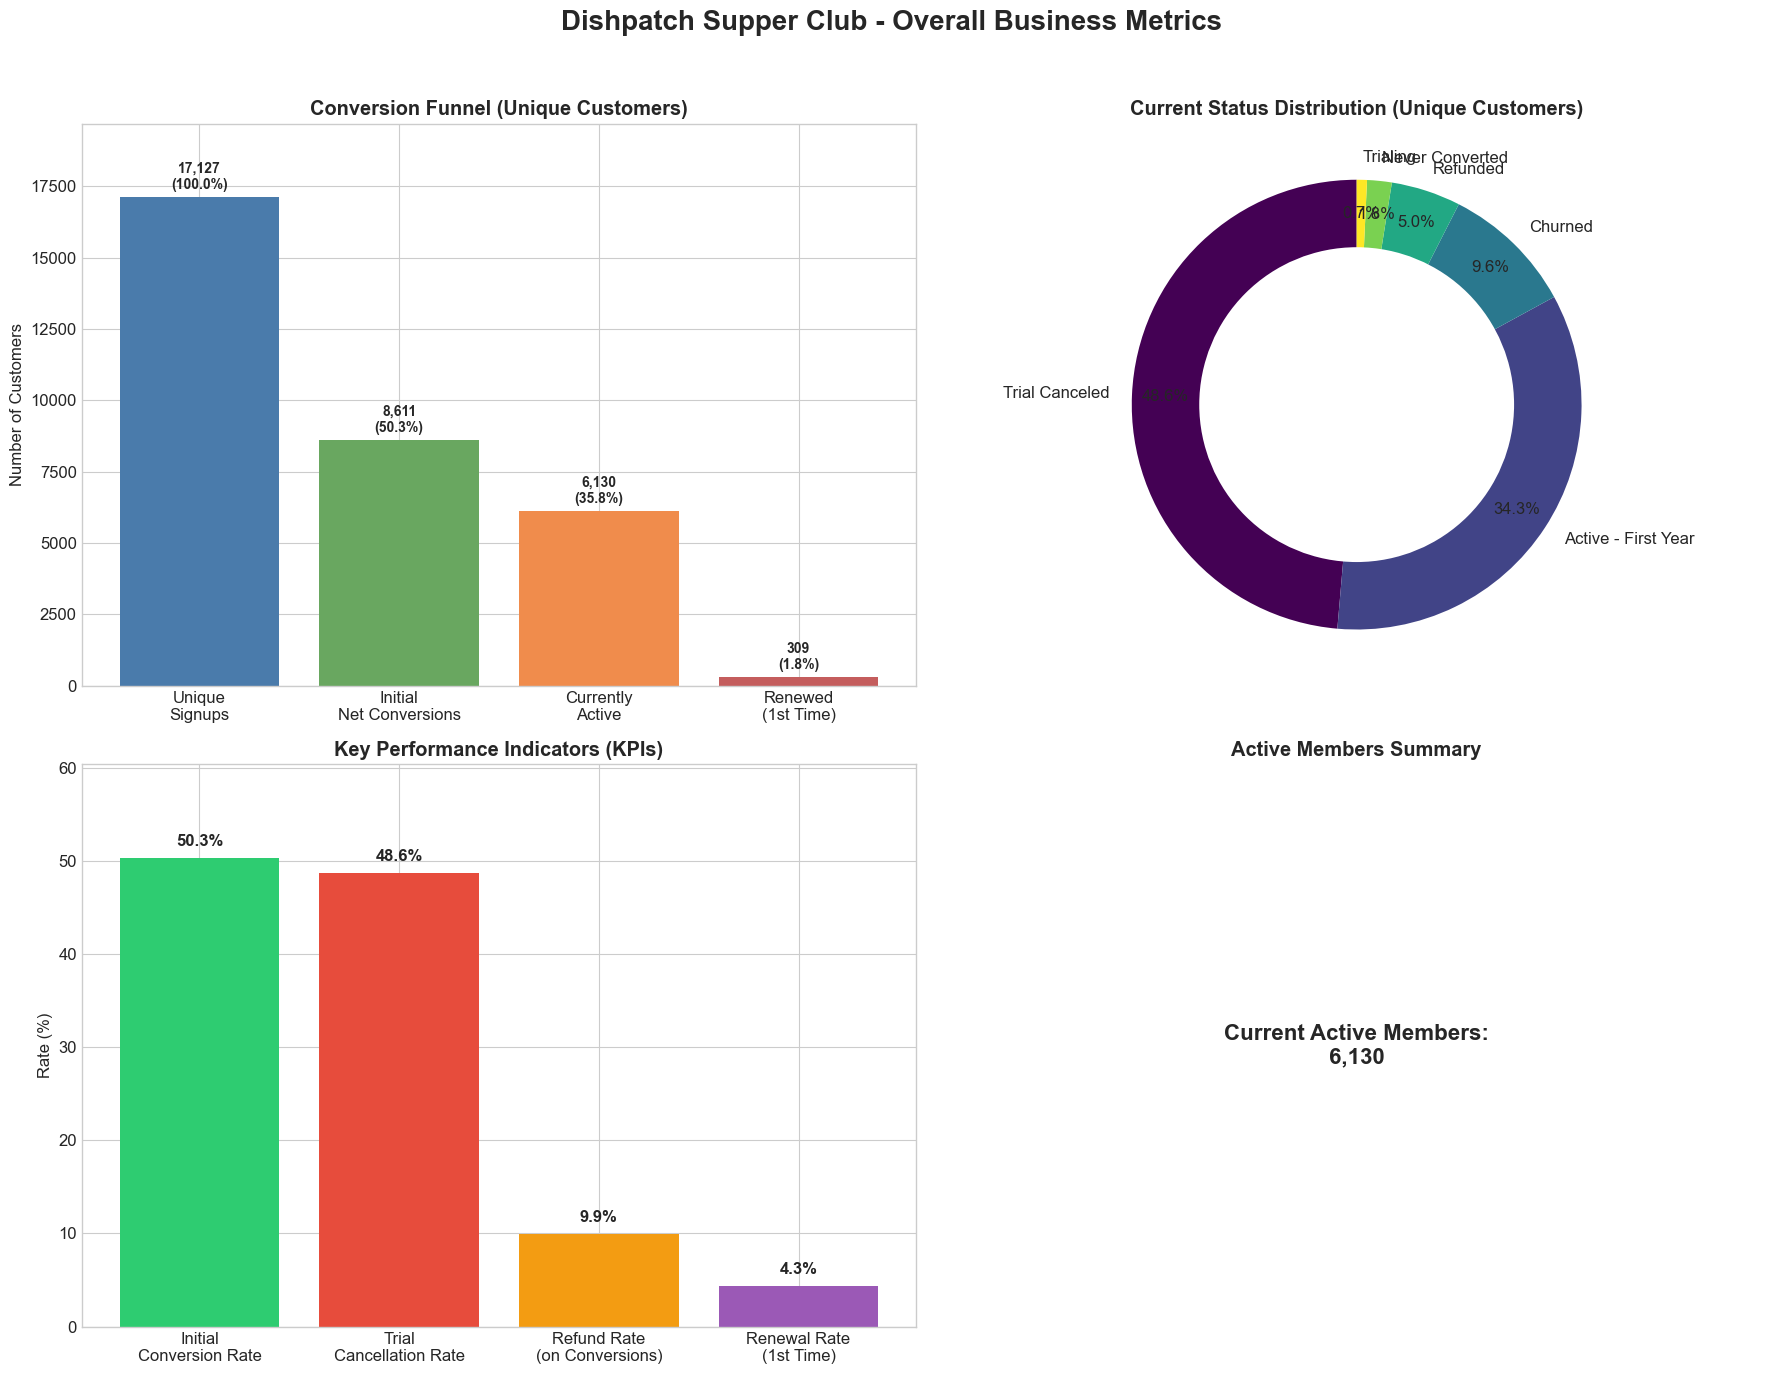

Generating cohort analysis visualization...


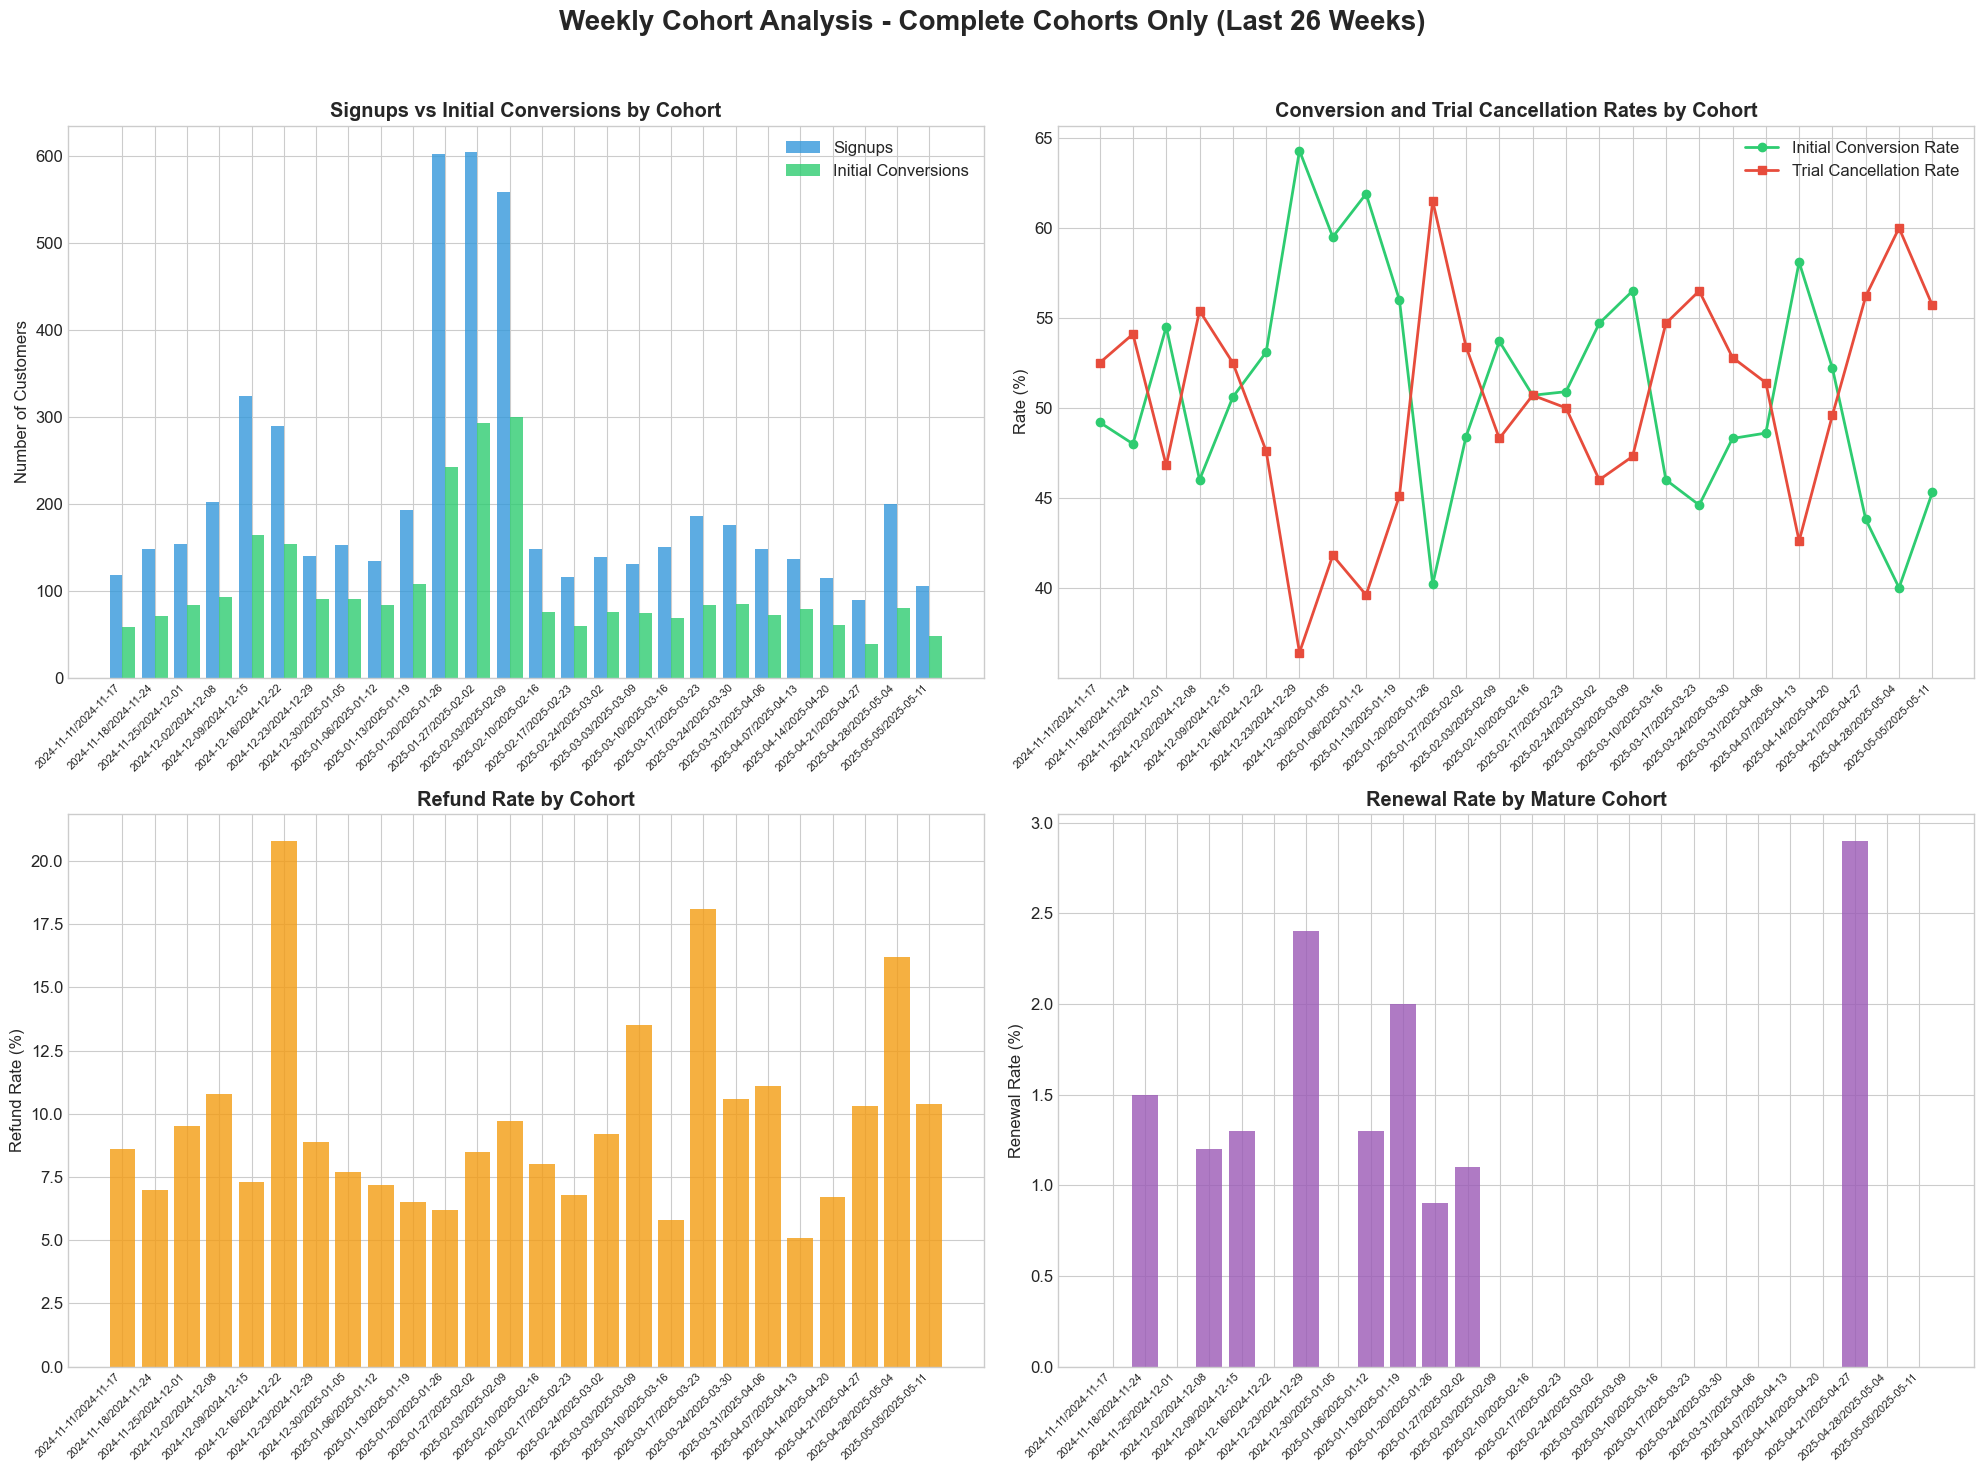

In [ ]:
# Générer toutes les visualisations
generate_all_visualizations(kpis_complete, customer_complete_df, complete_cohorts)

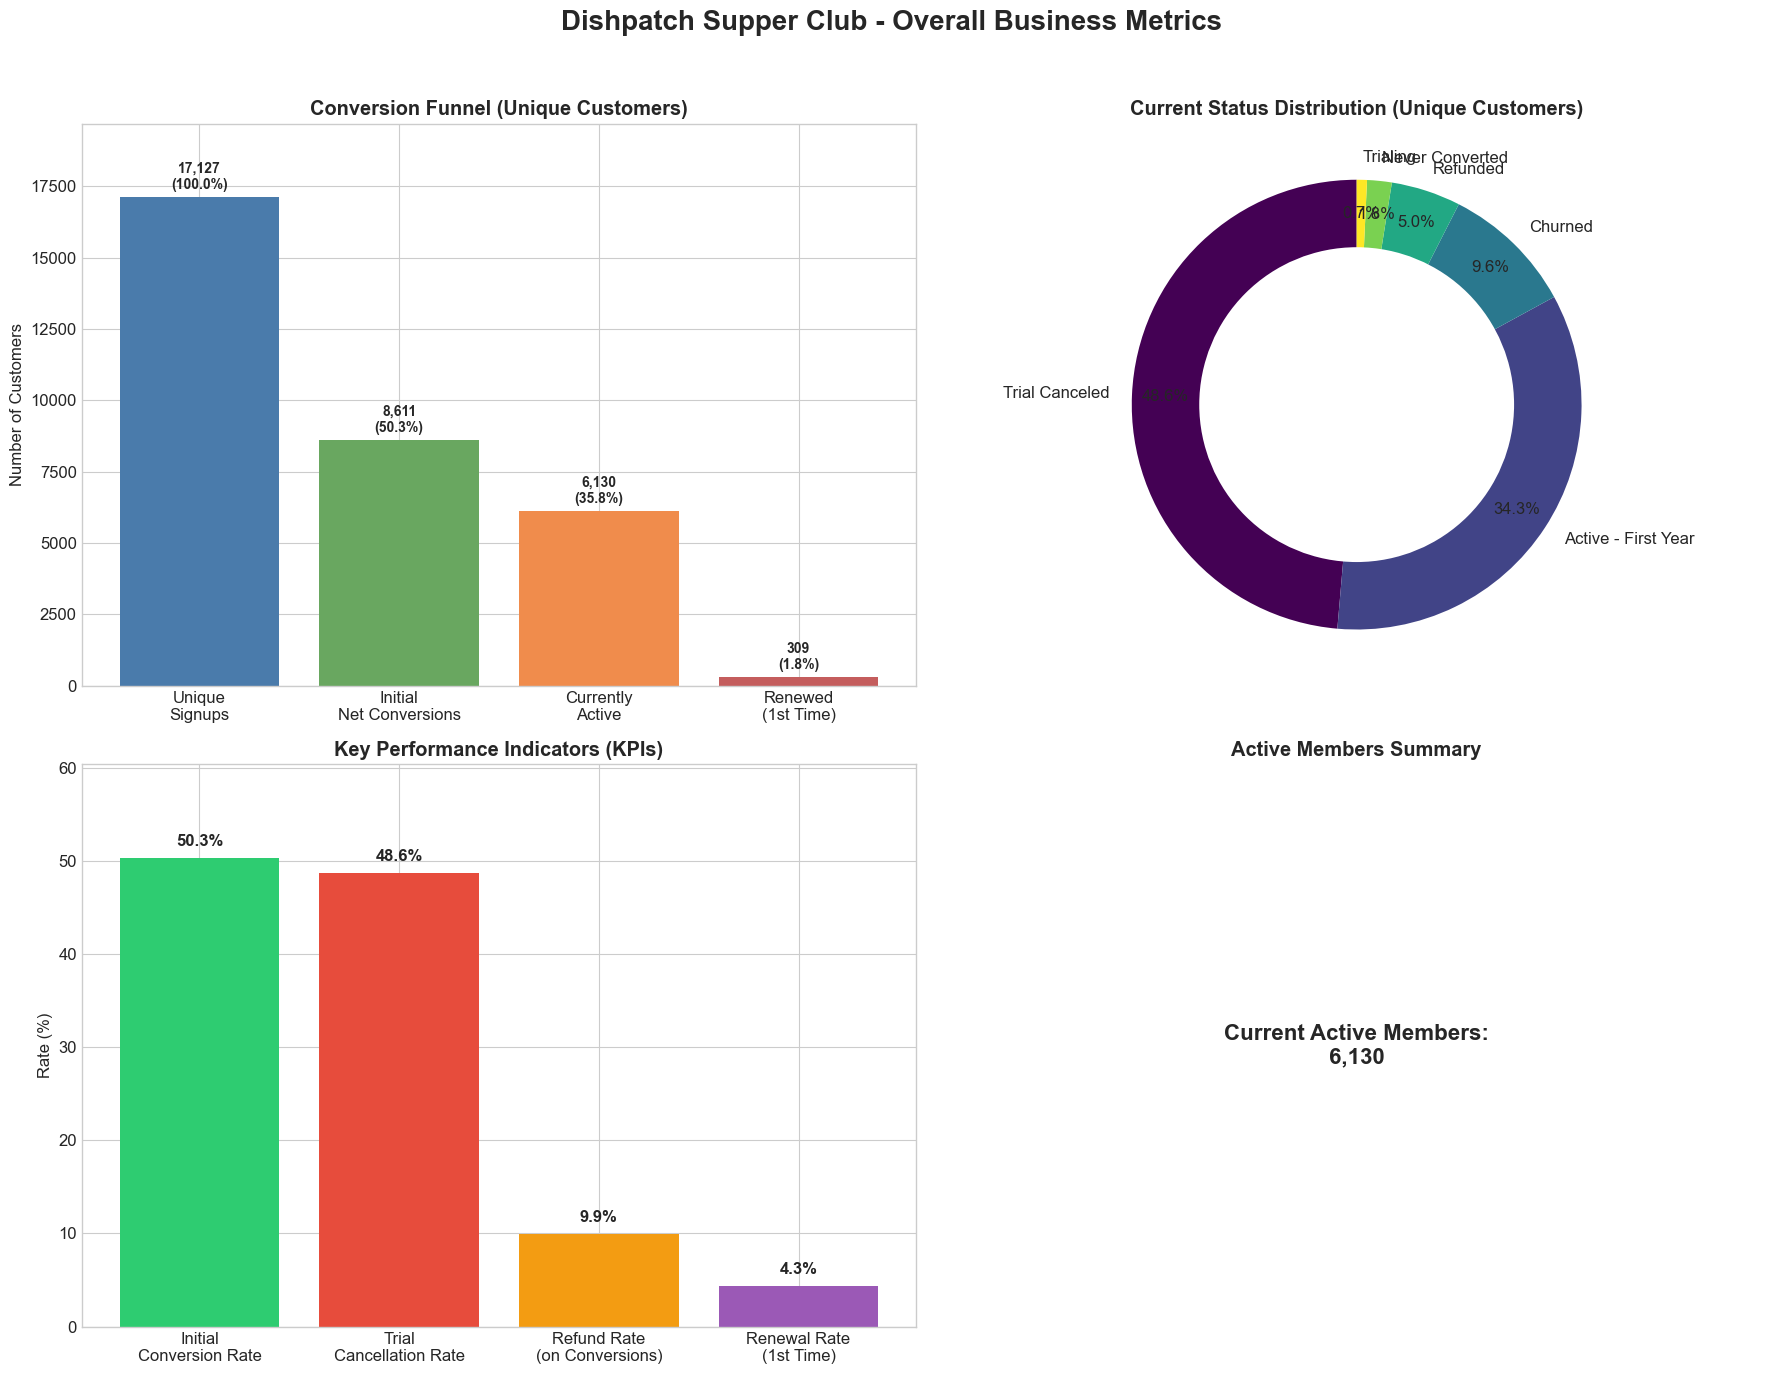

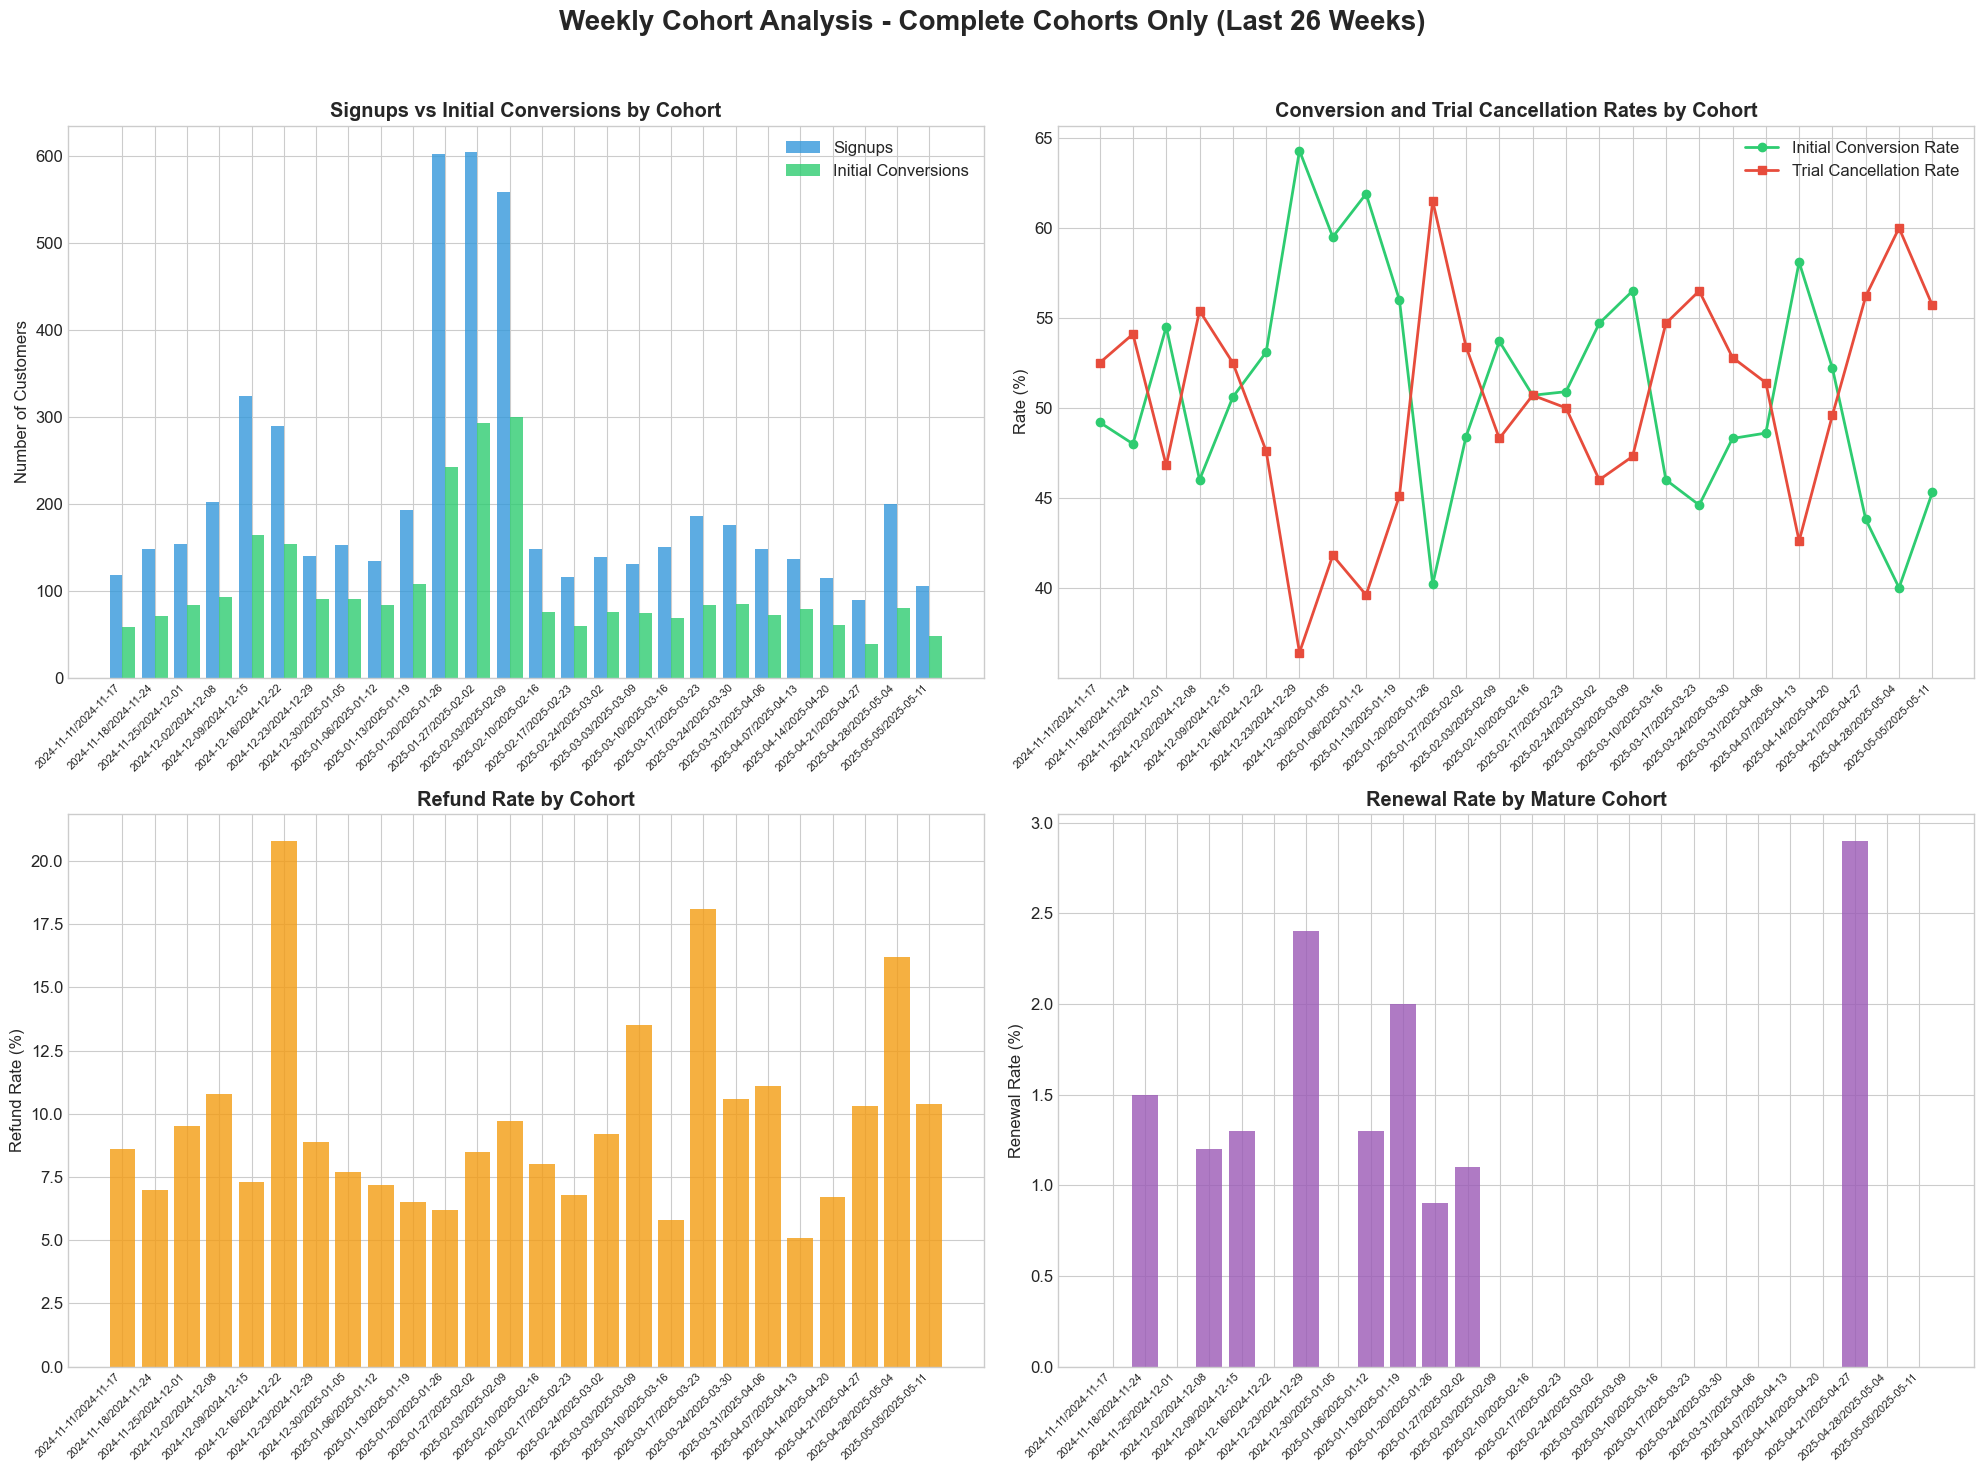


=== CUSTOMER STATUS BREAKDOWN ===
Trial Canceled         8329
Active - First Year    5877
Churned                1636
Refunded                856
Never Converted         303
Trialing                126
Name: detailed_status, dtype: int64

=== SUBSCRIPTION DURATION ANALYSIS ===
Average subscription duration: 164.4 days
Median subscription duration: 19.0 days
Max subscription duration: 1116 days

=== TOP DURATION BUCKETS ===
365    5791
10     5429
366     722
21      517
0       485
1       284
6       284
4       282
7       251
3       235
Name: real_duration, dtype: int64

=== CHURN PATTERN ANALYSIS ===
Average time to churn: 211.7 days
Median time to churn: 365.0 days

Top churn timing buckets:
  366 days: 630 customers
  365 days: 256 customers
  21 days: 215 customers
  15 days: 194 customers
  0 days: 91 customers
  1 days: 27 customers
  2 days: 25 customers
  3 days: 14 customers
  14 days: 11 customers
  7 days: 8 customers

Early churn (≤90 days): 708 customers
Late churn (>

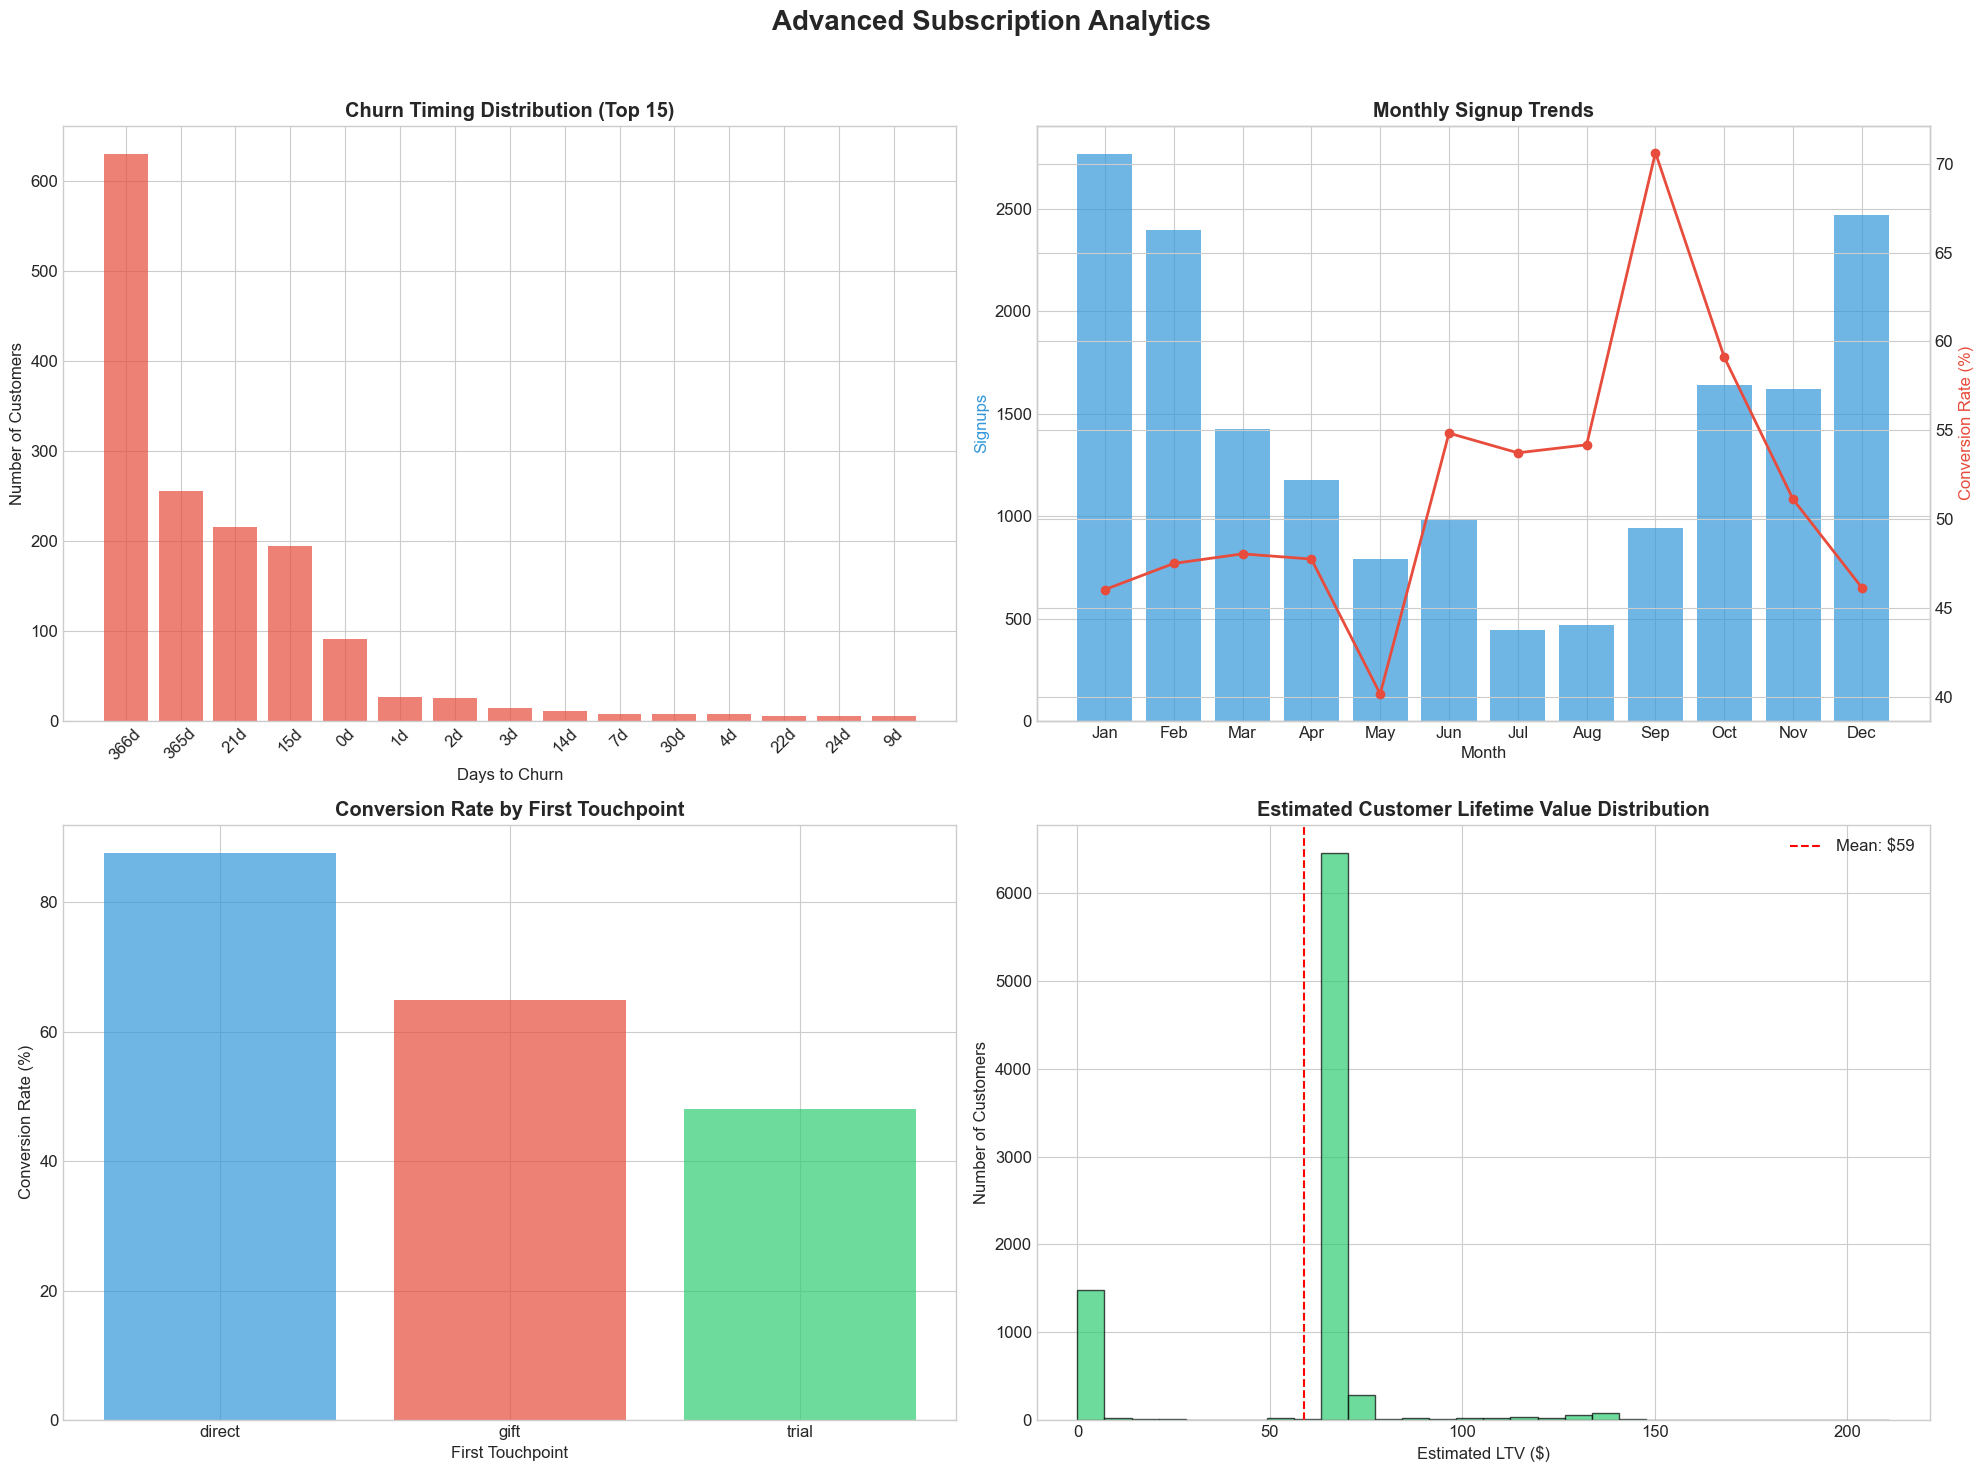


BUSINESS INSIGHTS & RECOMMENDATIONS
🟢 EXCELLENT CONVERSION:
   Conversion rate (50.3%) is exceptional!
   Focus on scaling acquisition while maintaining quality

🟡 RENEWAL OPPORTUNITY:
   Renewal rate (4.3%) could be improved
   Recommendations:
   - Implement pre-renewal engagement campaigns
   - Survey non-renewers for feedback
   - Consider loyalty incentives

🟢 HEALTHY ACTIVE BASE:
   35.8% of all signups are currently active
   Strong foundation for word-of-mouth growth

🔴 HIGH TRIAL ABANDONMENT:
   48.6% of users cancel during trial
   Recommendations:
   - Improve trial onboarding sequence
   - Add trial progress indicators
   - Provide more trial value quickly



In [288]:
##################
# EXECUTE VISUALIZATIONS CORRIGÉES
##################

# Utiliser les datasets corrigés
create_improved_visualizations(kpis_complete, customer_complete_df)
create_cohort_visualization(complete_cohorts)

##################
# ADDITIONAL ANALYSIS CORRIGÉ
##################

print("\n=== CUSTOMER STATUS BREAKDOWN ===")
print(customer_complete_df['detailed_status'].value_counts())  # Changé

print("\n=== SUBSCRIPTION DURATION ANALYSIS ===")
print(f"Average subscription duration: {customer_complete_df['real_duration'].mean():.1f} days")
print(f"Median subscription duration: {customer_complete_df['real_duration'].median():.1f} days")
print(f"Max subscription duration: {customer_complete_df['real_duration'].max()} days")

print("\n=== TOP DURATION BUCKETS ===")
print(customer_complete_df['real_duration'].value_counts().head(10))

##################
# ADVANCED ANALYTICS CORRIGÉ
##################

def analyze_churn_patterns(customer_complete_df):
    """Analyze churn patterns and identify risk factors"""
    print("\n=== CHURN PATTERN ANALYSIS ===")
    
    # Churn by subscription length
    churned_customers = customer_complete_df[customer_complete_df['detailed_status'] == 'Churned']  # Changé
    if len(churned_customers) > 0:
        print(f"Average time to churn: {churned_customers['real_duration'].mean():.1f} days")
        print(f"Median time to churn: {churned_customers['real_duration'].median():.1f} days")
        
        # Churn timing distribution
        churn_buckets = churned_customers['real_duration'].value_counts().head(10)
        print(f"\nTop churn timing buckets:")
        for duration, count in churn_buckets.items():
            print(f"  {duration} days: {count} customers")
    
    # Early vs late churn
    early_churn = customer_complete_df[
        (customer_complete_df['detailed_status'] == 'Churned') & 
        (customer_complete_df['real_duration'] <= 90)
    ]
    late_churn = customer_complete_df[
        (customer_complete_df['detailed_status'] == 'Churned') & 
        (customer_complete_df['real_duration'] > 90)
    ]
    
    print(f"\nEarly churn (≤90 days): {len(early_churn)} customers")
    print(f"Late churn (>90 days): {len(late_churn)} customers")
    
    return churned_customers, early_churn, late_churn

def analyze_seasonal_trends(customer_complete_df):
    """Analyze seasonal signup and conversion trends"""
    print("\n=== SEASONAL TRENDS ANALYSIS ===")
    
    # Add seasonal features
    customer_df_copy = customer_complete_df.copy()
    customer_df_copy['signup_month'] = customer_df_copy['first_signup_date'].dt.month  # Changé
    customer_df_copy['signup_quarter'] = customer_df_copy['first_signup_date'].dt.quarter  # Changé
    customer_df_copy['signup_day_of_week'] = customer_df_copy['first_signup_date'].dt.day_name()  # Changé
    
    # Monthly signup trends
    monthly_signups = customer_df_copy.groupby('signup_month').agg({
        'customer_name': 'count',
        'converted_to_paid': 'sum'  # Changé
    }).rename(columns={'customer_name': 'signups', 'converted_to_paid': 'conversions'})
    
    monthly_signups['conversion_rate'] = (monthly_signups['conversions'] / monthly_signups['signups'] * 100).round(1)
    
    print("Monthly signup and conversion patterns:")
    for month, row in monthly_signups.iterrows():
        month_name = pd.to_datetime(f'2024-{month:02d}-01').strftime('%B')
        print(f"  {month_name}: {row['signups']} signups, {row['conversion_rate']}% conversion")
    
    # Day of week patterns
    dow_signups = customer_df_copy.groupby('signup_day_of_week').agg({
        'customer_name': 'count',
        'converted_to_paid': 'sum'  # Changé
    }).rename(columns={'customer_name': 'signups', 'converted_to_paid': 'conversions'})
    
    dow_signups['conversion_rate'] = (dow_signups['conversions'] / dow_signups['signups'] * 100).round(1)
    
    print(f"\nDay of week signup patterns:")
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for day in day_order:
        if day in dow_signups.index:
            row = dow_signups.loc[day]
            print(f"  {day}: {row['signups']} signups, {row['conversion_rate']}% conversion")
    
    return monthly_signups, dow_signups

def analyze_trial_behavior(customer_complete_df):
    """Analyze trial period behavior patterns"""
    print("\n=== TRIAL BEHAVIOR ANALYSIS ===")
    
    # Calculer la durée d'essai pour l'analyse
    customer_df_copy = customer_complete_df.copy()
    customer_df_copy['trial_duration_calc'] = (
        customer_df_copy['trial_end_utc'] - customer_df_copy['trial_start_utc']
    ).dt.days
    
    # Trial duration analysis (seulement pour ceux qui ont eu un essai)
    trial_data = customer_df_copy[customer_df_copy['had_trial'] == True]
    
    if len(trial_data) > 0:
        trial_durations = trial_data['trial_duration_calc'].value_counts().head(10)
        print("Trial duration distribution:")
        for duration, count in trial_durations.items():
            if pd.notna(duration):
                print(f"  {int(duration)} days: {count} trials")
        
        # Trial to paid conversion by trial length
        trial_conversion = trial_data.groupby('trial_duration_calc').agg({
            'customer_name': 'count',
            'converted_to_paid': 'sum'  # Changé
        }).rename(columns={'customer_name': 'total_trials'})
        
        trial_conversion['conversion_rate'] = (
            trial_conversion['converted_to_paid'] / trial_conversion['total_trials'] * 100
        ).round(1)
        
        # Filter for meaningful sample sizes
        significant_trials = trial_conversion[trial_conversion['total_trials'] >= 10]
        
        print(f"\nTrial conversion rates (for trial lengths with 10+ customers):")
        for duration, row in significant_trials.iterrows():
            if pd.notna(duration):
                print(f"  {int(duration)} days: {row['conversion_rate']}% conversion ({row['total_trials']} trials)")
    
    return trial_data

def calculate_cohort_retention(customer_complete_df):
    """Calculate cohort retention analysis"""
    print("\n=== COHORT RETENTION ANALYSIS ===")
    
    # Create monthly cohorts
    customer_df_copy = customer_complete_df.copy()
    customer_df_copy['cohort_month'] = customer_df_copy['first_signup_date'].dt.to_period('M')  # Changé
    
    # Calculate months since signup for each customer
    reference_date_period = pd.Timestamp.now().to_period('M')
    customer_df_copy['months_since_signup'] = (
        reference_date_period - customer_df_copy['cohort_month']
    ).apply(lambda x: x.n)
    
    # Retention by cohort month
    cohort_retention = customer_df_copy.groupby('cohort_month').agg({
        'customer_name': 'count',
        'converted_to_paid': 'sum',  # Changé
        'real_duration': lambda x: (x >= 400).sum()  # Approximation pour les renouvellements
    }).rename(columns={
        'customer_name': 'total_signups',
        'converted_to_paid': 'initial_conversions',
        'real_duration': 'renewals'
    })
    
    cohort_retention['initial_conversion_rate'] = (
        cohort_retention['initial_conversions'] / cohort_retention['total_signups'] * 100
    ).round(1)
    
    cohort_retention['renewal_rate'] = np.where(
        cohort_retention['initial_conversions'] > 0,
        (cohort_retention['renewals'] / cohort_retention['initial_conversions'] * 100).round(1),
        0
    )
    
    print("Monthly cohort performance (last 12 months):")
    recent_cohorts = cohort_retention.tail(12)
    for cohort, row in recent_cohorts.iterrows():
        print(f"  {cohort}: {row['total_signups']} signups, {row['initial_conversion_rate']}% conversion, {row['renewal_rate']}% renewal")
    
    return cohort_retention

def create_advanced_visualizations(customer_complete_df):
    """Create advanced analytical visualizations"""
    
    # 1. Churn Analysis Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle('Advanced Subscription Analytics', fontsize=20, fontweight='bold')
    
    # Churn timing distribution
    churned = customer_complete_df[customer_complete_df['detailed_status'] == 'Churned']  # Changé
    if len(churned) > 0:
        churn_buckets = churned['real_duration'].value_counts().head(15)
        ax1.bar(range(len(churn_buckets)), churn_buckets.values, color='#e74c3c', alpha=0.7)
        ax1.set_title('Churn Timing Distribution (Top 15)', fontweight='bold')
        ax1.set_xlabel('Days to Churn')
        ax1.set_ylabel('Number of Customers')
        ax1.set_xticks(range(len(churn_buckets)))
        ax1.set_xticklabels([f'{d}d' for d in churn_buckets.index], rotation=45)
    
    # Monthly signup trends
    customer_df_copy = customer_complete_df.copy()
    customer_df_copy['signup_month'] = customer_df_copy['first_signup_date'].dt.month  # Changé
    monthly_trends = customer_df_copy.groupby('signup_month').agg({
        'customer_name': 'count',
        'converted_to_paid': 'sum'  # Changé
    })
    monthly_trends['conversion_rate'] = (monthly_trends['converted_to_paid'] / monthly_trends['customer_name'] * 100)
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    ax2_twin = ax2.twinx()
    bars = ax2.bar(range(1, 13), [monthly_trends.loc[i, 'customer_name'] if i in monthly_trends.index else 0 for i in range(1, 13)], 
                   color='#3498db', alpha=0.7, label='Signups')
    line = ax2_twin.plot(range(1, 13), [monthly_trends.loc[i, 'conversion_rate'] if i in monthly_trends.index else 0 for i in range(1, 13)], 
                         color='#e74c3c', marker='o', linewidth=2, label='Conversion Rate')
    
    ax2.set_title('Monthly Signup Trends', fontweight='bold')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Signups', color='#3498db')
    ax2_twin.set_ylabel('Conversion Rate (%)', color='#e74c3c')
    ax2.set_xticks(range(1, 13))
    ax2.set_xticklabels(months)
    
    # First touchpoint analysis
    touchpoint_analysis = customer_complete_df.groupby('first_touchpoint').agg({
        'customer_name': 'count',
        'converted_to_paid': 'sum'
    })
    touchpoint_analysis['conversion_rate'] = (touchpoint_analysis['converted_to_paid'] / touchpoint_analysis['customer_name'] * 100)
    
    ax3.bar(touchpoint_analysis.index, touchpoint_analysis['conversion_rate'], 
           color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
    ax3.set_title('Conversion Rate by First Touchpoint', fontweight='bold')
    ax3.set_xlabel('First Touchpoint')
    ax3.set_ylabel('Conversion Rate (%)')
    
    # Customer lifetime value distribution
    customer_df_copy['estimated_ltv'] = customer_df_copy['real_duration'] * (69/365)  # Assuming $69/year
    active_customers = customer_df_copy[customer_df_copy['converted_to_paid'] == True]  # Changé
    
    if len(active_customers) > 0:
        ax4.hist(active_customers['estimated_ltv'], bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
        ax4.set_title('Estimated Customer Lifetime Value Distribution', fontweight='bold')
        ax4.set_xlabel('Estimated LTV ($)')
        ax4.set_ylabel('Number of Customers')
        ax4.axvline(active_customers['estimated_ltv'].mean(), color='red', linestyle='--', 
                   label=f'Mean: ${active_customers["estimated_ltv"].mean():.0f}')
        ax4.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def generate_business_insights(kpis_complete, customer_complete_df):
    """Generate actionable business insights"""
    print("\n" + "="*50)
    print("BUSINESS INSIGHTS & RECOMMENDATIONS")
    print("="*50)
    
    # Conversion insights
    if kpis_complete['kpi_conversion_rate'] < 30:
        print("🔴 LOW CONVERSION ALERT:")
        print(f"   Current conversion rate ({kpis_complete['kpi_conversion_rate']:.1f}%) is below industry benchmark (~30-40%)")
        print("   Recommendations:")
        print("   - Review trial experience and onboarding flow")
        print("   - Analyze trial cancellation reasons")
        print("   - Consider A/B testing different trial lengths")
        print()
    elif kpis_complete['kpi_conversion_rate'] > 50:
        print("🟢 EXCELLENT CONVERSION:")
        print(f"   Conversion rate ({kpis_complete['kpi_conversion_rate']:.1f}%) is exceptional!")
        print("   Focus on scaling acquisition while maintaining quality")
        print()
    
    # Churn insights
    churned_customers = customer_complete_df[customer_complete_df['detailed_status'] == 'Churned']  # Changé
    if len(churned_customers) > 0:
        avg_churn_time = churned_customers['real_duration'].mean()
        if avg_churn_time < 180:  # 6 months
            print("🔴 EARLY CHURN PATTERN:")
            print(f"   Average time to churn: {avg_churn_time:.0f} days")
            print("   Recommendations:")
            print("   - Implement early engagement campaigns")
            print("   - Review product-market fit")
            print("   - Create milestone celebrations for new customers")
            print()
    
    # Renewal insights
    if kpis_complete['kpi_renewal_rate'] < 70:
        print("🟡 RENEWAL OPPORTUNITY:")
        print(f"   Renewal rate ({kpis_complete['kpi_renewal_rate']:.1f}%) could be improved")
        print("   Recommendations:")
        print("   - Implement pre-renewal engagement campaigns")
        print("   - Survey non-renewers for feedback")
        print("   - Consider loyalty incentives")
        print()
    
    # Growth insights
    active_ratio = kpis_complete['current_active_members'] / kpis_complete['total_unique_signups']
    if active_ratio > 0.3:
        print("🟢 HEALTHY ACTIVE BASE:")
        print(f"   {active_ratio*100:.1f}% of all signups are currently active")
        print("   Strong foundation for word-of-mouth growth")
        print()
    
    # Trial insights
    trial_cancel_rate = kpis_complete['kpi_trial_cancel_rate']
    if trial_cancel_rate > 40:
        print("🔴 HIGH TRIAL ABANDONMENT:")
        print(f"   {trial_cancel_rate:.1f}% of users cancel during trial")
        print("   Recommendations:")
        print("   - Improve trial onboarding sequence")
        print("   - Add trial progress indicators")
        print("   - Provide more trial value quickly")
        print()

##################
# EXECUTE ADVANCED ANALYSIS
##################

# Run advanced analytics avec les datasets corrigés
churned_customers, early_churn, late_churn = analyze_churn_patterns(customer_complete_df)
monthly_signups, dow_signups = analyze_seasonal_trends(customer_complete_df)
trial_data = analyze_trial_behavior(customer_complete_df)
cohort_retention = calculate_cohort_retention(customer_complete_df)

# Create advanced visualizations
create_advanced_visualizations(customer_complete_df)

# Generate business insights
generate_business_insights(kpis_complete, customer_complete_df)

=== DISHPATCH SUPPER CLUB - ANALYSE AVEC PARCOURS CLIENT CORRIGÉ ===

--- UTILISATION DES DATASETS CORRIGÉS EXISTANTS ---
Dataset complet: 17,127 clients
KPIs calculés: 11 métriques
Cohortes complètes: 85 semaines

🎨 Génération des visualisations corrigées...


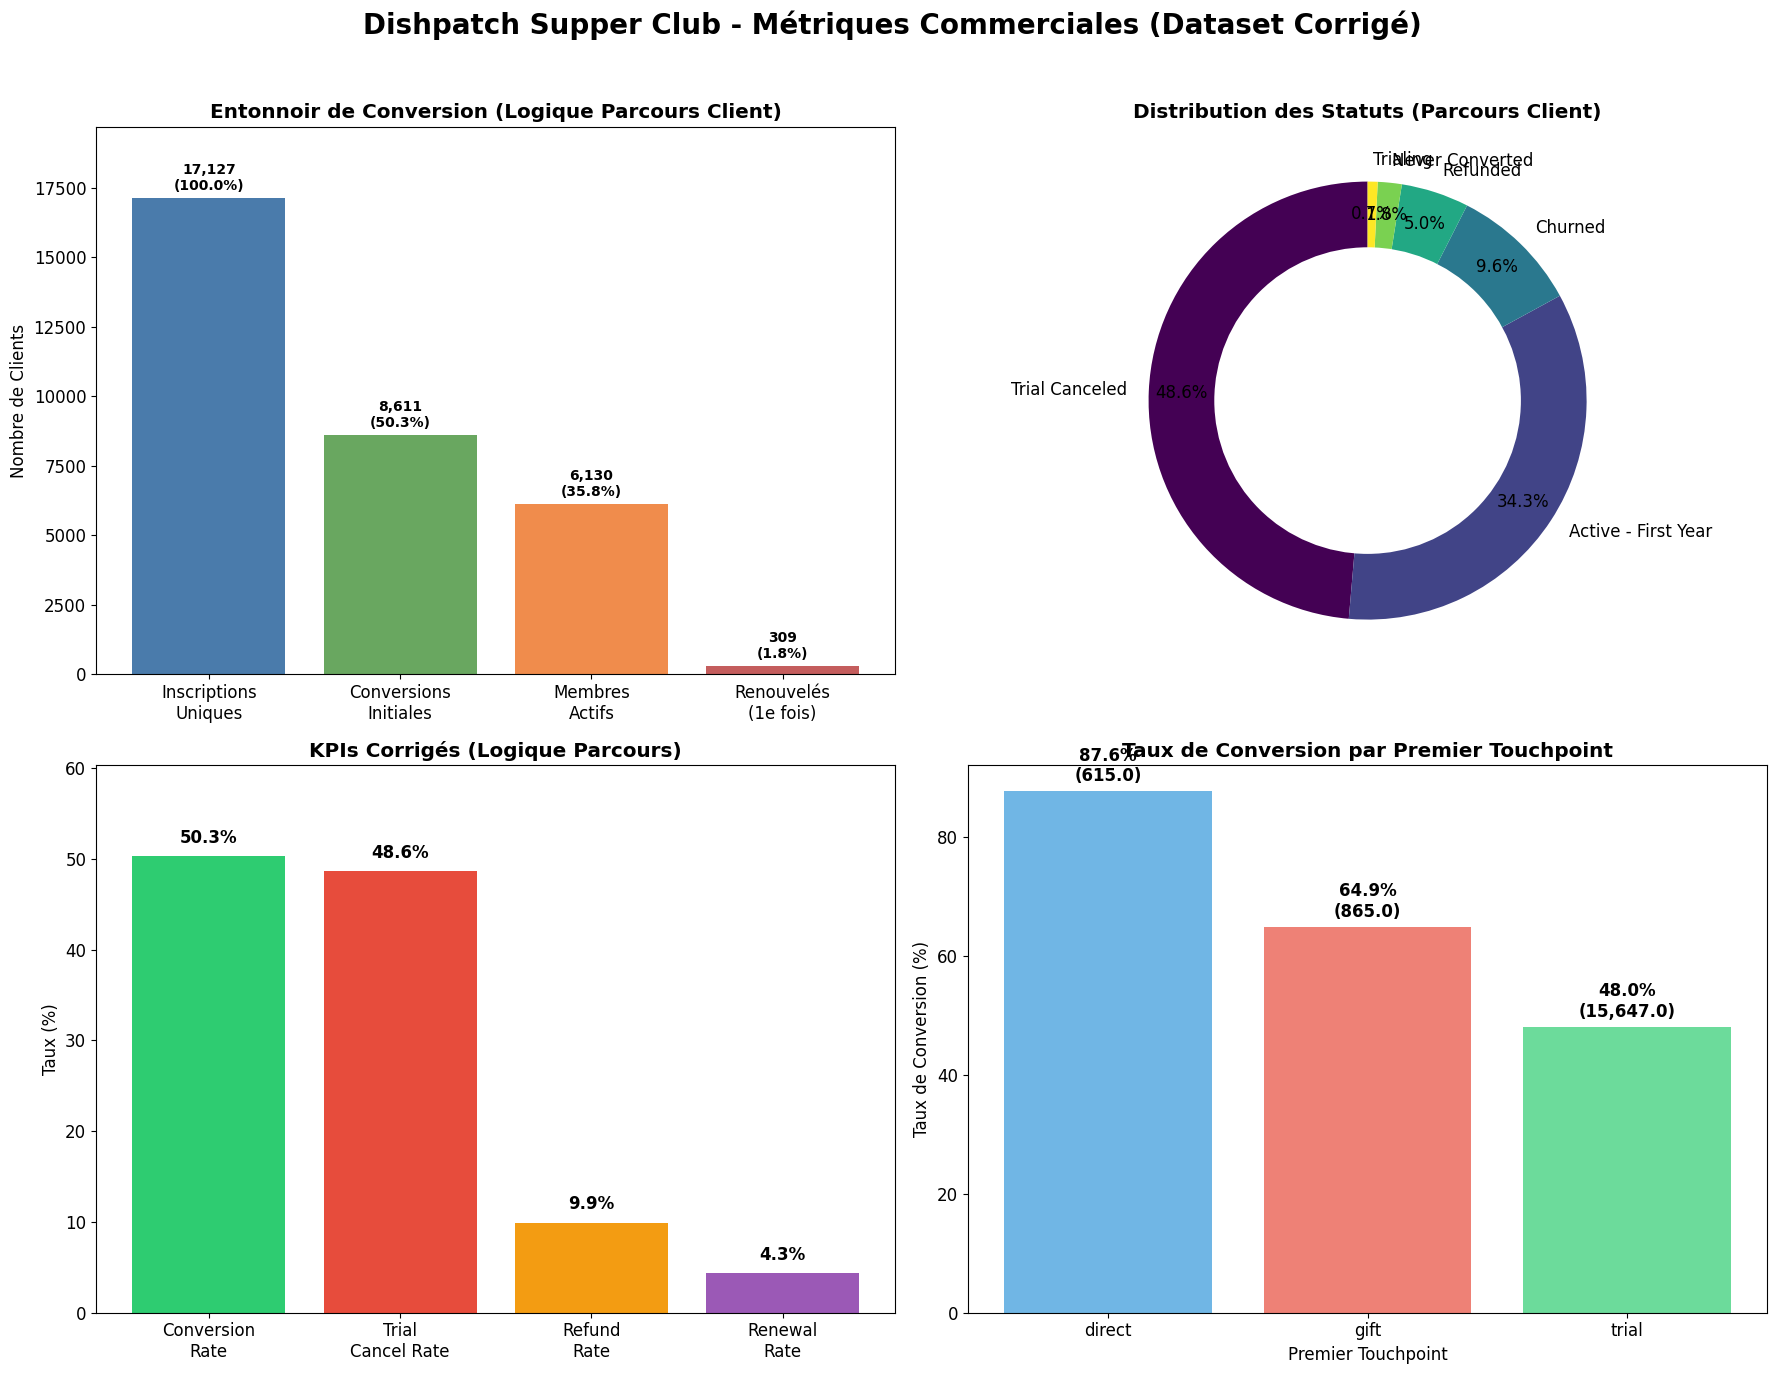

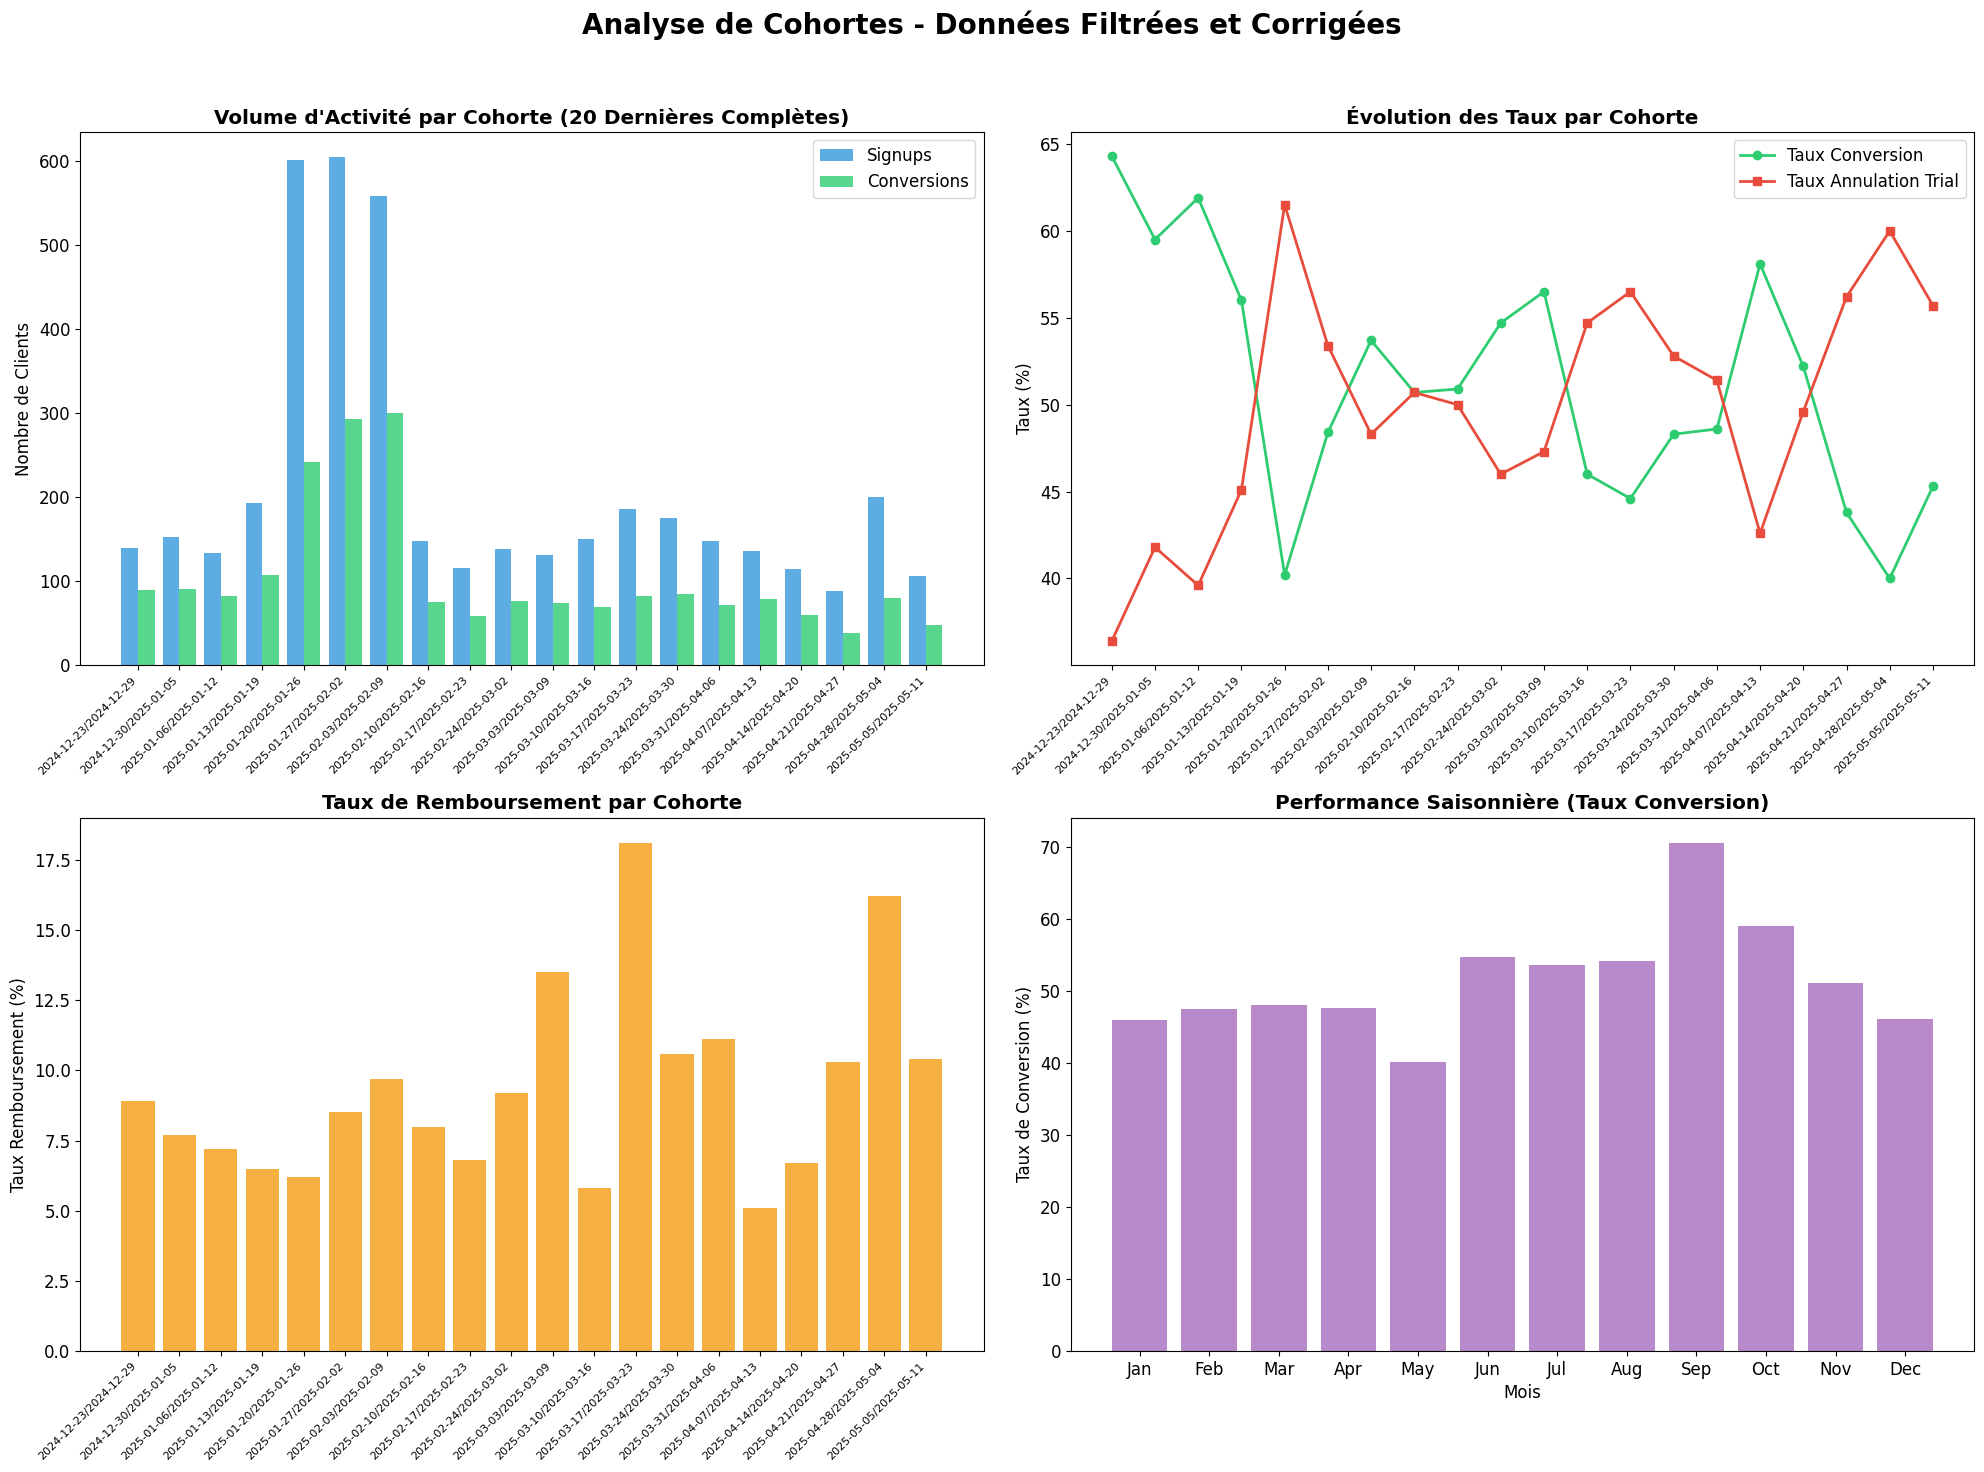

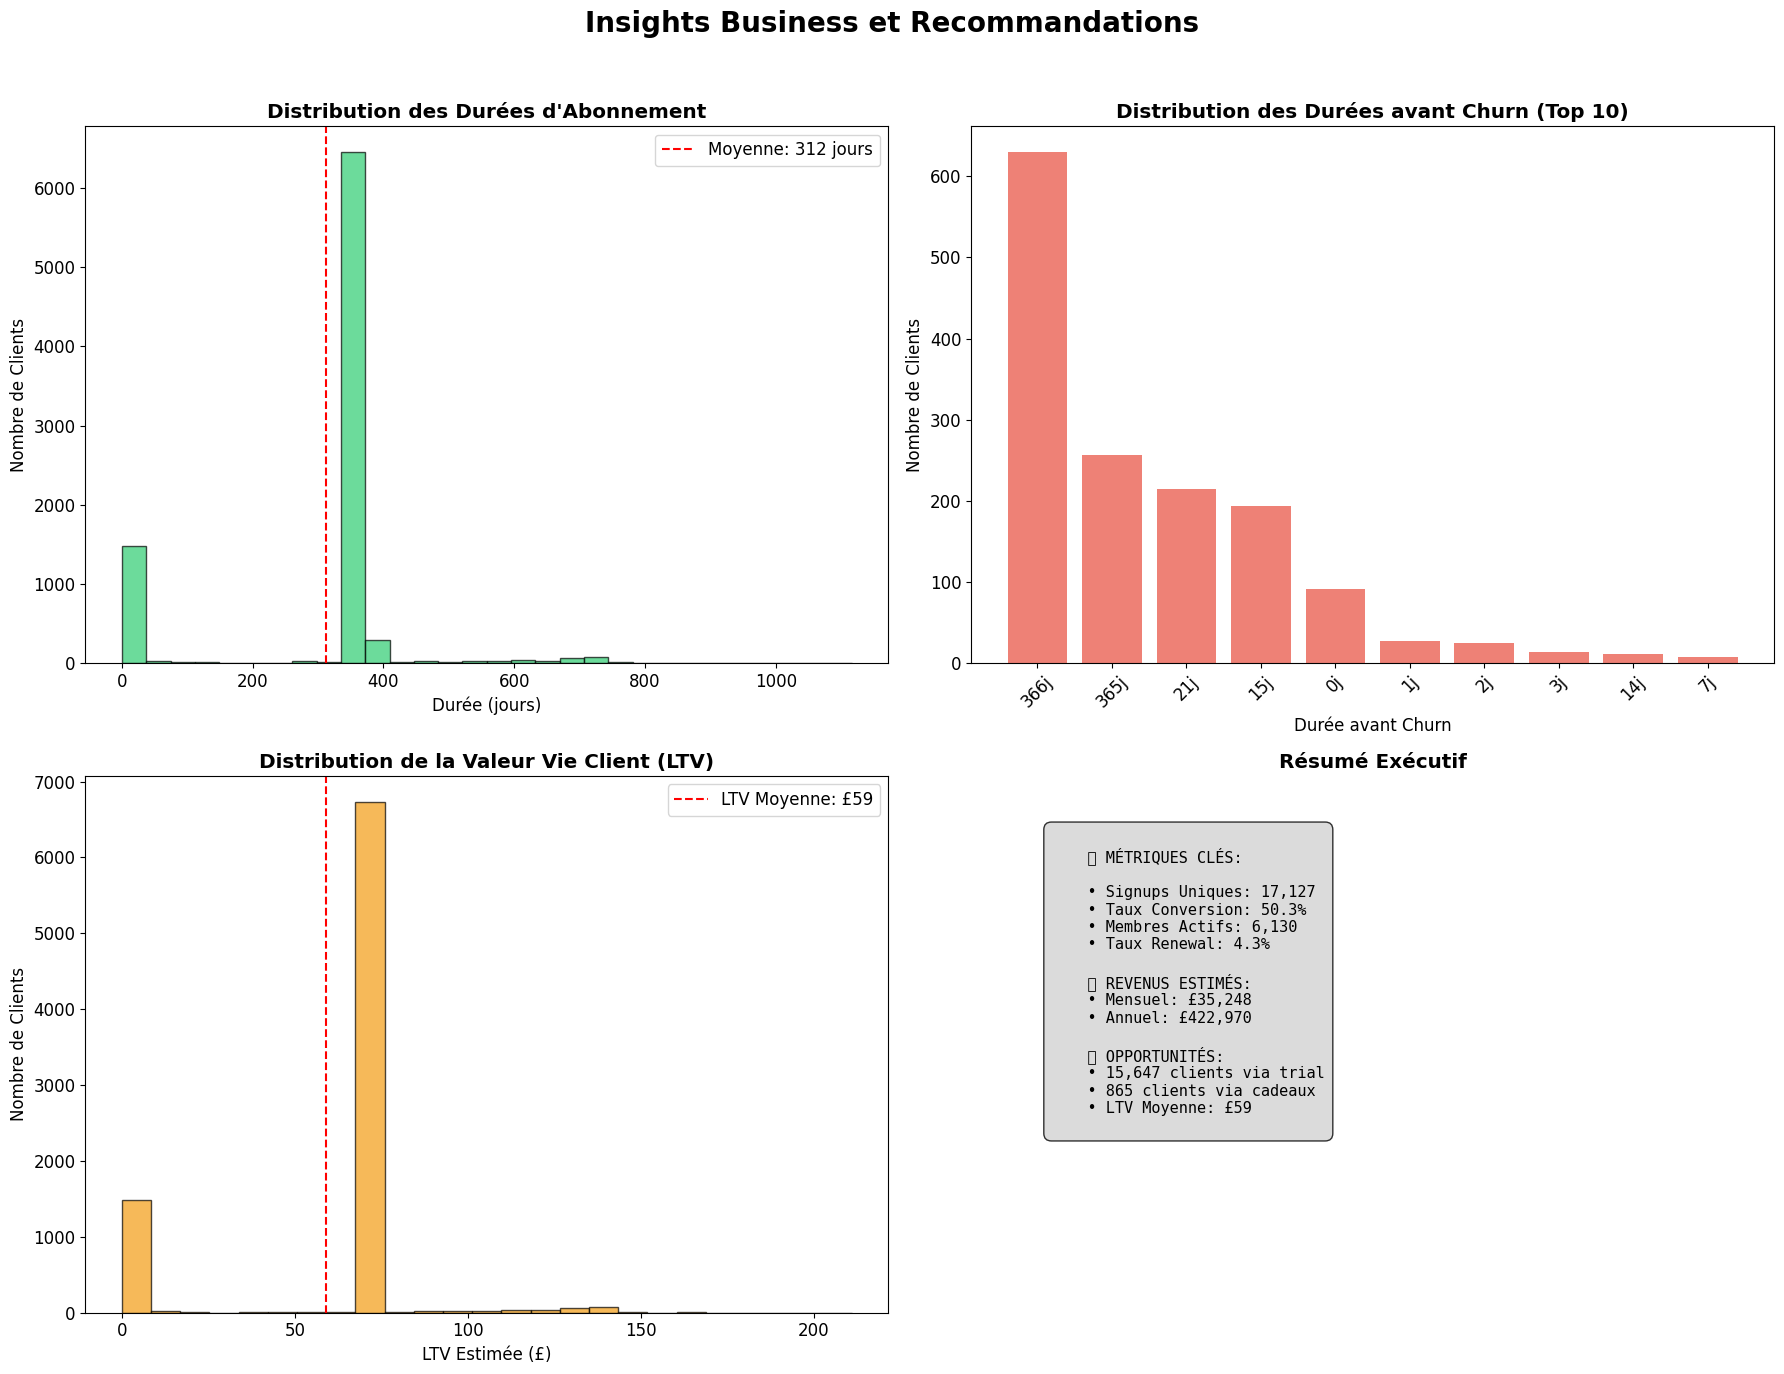


=== COMPARAISON MÉTRIQUES AVANT/APRÈS CORRECTION ===
         Métrique  Avant Correction  Après Correction  Différence  % Change
  Conversion Rate              44.1         50.277340    6.177340      14.0
Trial Cancel Rate              47.4         48.630817    1.230817       2.6
     Renewal Rate               0.1          4.322283    4.222283    4222.3
   Active Members            6130.0       6130.000000    0.000000       0.0

RÉSUMÉ EXÉCUTIF - DISHPATCH SUPPER CLUB

🎯 PERFORMANCE GLOBALE:
   • 17,127 signups uniques analysés
   • 50.3% taux de conversion (EXCELLENT)
   • 6,130 membres actifs payants
   • £422,970 revenus annuels estimés

📊 CANAUX D'ACQUISITION:
   • Trial: 15,647 signups (48.0% conversion)
   • Gift: 865 signups (64.9% conversion)
   • Direct: 615 signups (87.6% conversion)

⚠️  POINTS D'ATTENTION:
   • Taux abandon trial élevé: 48.6%
   • Taux renouvellement à améliorer: 4.3%

🚀 RECOMMANDATIONS:
   1. Optimiser l'expérience trial (réduire abandons)
   2. Développ

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tseries.offsets import Week
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuration générale
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")

print("=== DISHPATCH SUPPER CLUB - ANALYSE AVEC PARCOURS CLIENT CORRIGÉ ===")

# --- UTILISATION DU DATASET DÉJÀ CRÉÉ ---
# Au lieu de recharger depuis le CSV, utilisons les datasets déjà créés et corrigés
print(f"\n--- UTILISATION DES DATASETS CORRIGÉS EXISTANTS ---")
print(f"Dataset complet: {len(customer_complete_df):,} clients")
print(f"KPIs calculés: {len(kpis_complete)} métriques")
print(f"Cohortes complètes: {len(complete_cohorts)} semaines")

# --- FONCTION DE VISUALISATION PRINCIPALE CORRIGÉE ---
def create_complete_dashboard():
    """Crée un tableau de bord complet avec les données corrigées"""
    
    # VISUALISATION 1: MÉTRIQUES PRINCIPALES
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    fig1.suptitle('Dishpatch Supper Club - Métriques Commerciales (Dataset Corrigé)', 
                  fontsize=20, fontweight='bold')

    # 1.1 Entonnoir de Conversion
    funnel_stages = ['Inscriptions\nUniques', 'Conversions\nInitiales', 'Membres\nActifs', 'Renouvelés\n(1e fois)']
    funnel_counts = [
        kpis_complete['total_unique_signups'],
        kpis_complete['total_initial_conversions'], 
        kpis_complete['current_active_members'],
        kpis_complete['total_actually_renewed']
    ]
    funnel_colors = ['#4a7bab', '#69a760', '#f08c4c', '#c45d5d']

    bars = ax1.bar(funnel_stages, funnel_counts, color=funnel_colors)
    ax1.set_title('Entonnoir de Conversion (Logique Parcours Client)', fontweight='bold')
    ax1.set_ylabel('Nombre de Clients')
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        percentage = (height / funnel_counts[0] * 100) if funnel_counts[0] > 0 else 0
        ax1.text(bar.get_x() + bar.get_width()/2., height + (0.01 * max(funnel_counts)), 
                f'{height:,}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=10)
    ax1.set_ylim(0, max(funnel_counts) * 1.15)

    # 1.2 Distribution des Statuts (Corrigé)
    status_counts = customer_complete_df['detailed_status'].value_counts()
    colors = plt.cm.viridis(np.linspace(0, 1, len(status_counts)))
    
    wedges, texts, autotexts = ax2.pie(status_counts.values, labels=status_counts.index, 
                                       autopct='%1.1f%%', colors=colors, startangle=90, pctdistance=0.85)
    ax2.set_title('Distribution des Statuts (Parcours Client)', fontweight='bold')
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    ax2.add_artist(centre_circle)

    # 1.3 KPIs Clés
    kpi_names = ['Conversion\nRate', 'Trial\nCancel Rate', 'Refund\nRate', 'Renewal\nRate']
    kpi_values = [
        kpis_complete['kpi_conversion_rate'],
        kpis_complete['kpi_trial_cancel_rate'], 
        kpis_complete['kpi_refund_rate'],
        kpis_complete['kpi_renewal_rate']
    ]
    kpi_colors = ['#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']
    
    kpi_bars = ax3.bar(kpi_names, kpi_values, color=kpi_colors)
    ax3.set_title('KPIs Corrigés (Logique Parcours)', fontweight='bold')
    ax3.set_ylabel('Taux (%)')
    
    for bar in kpi_bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%', 
                ha='center', va='bottom', fontweight='bold')
    ax3.set_ylim(0, max(kpi_values) * 1.2 if kpi_values else 10)

    # 1.4 Analyse des Touchpoints
    touchpoint_analysis = customer_complete_df.groupby('first_touchpoint').agg({
        'customer_name': 'count',
        'converted_to_paid': 'sum'
    })
    touchpoint_analysis['conversion_rate'] = (
        touchpoint_analysis['converted_to_paid'] / touchpoint_analysis['customer_name'] * 100
    )
    
    bars_tp = ax4.bar(touchpoint_analysis.index, touchpoint_analysis['conversion_rate'], 
                     color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
    ax4.set_title('Taux de Conversion par Premier Touchpoint', fontweight='bold')
    ax4.set_ylabel('Taux de Conversion (%)')
    ax4.set_xlabel('Premier Touchpoint')
    
    # Ajouter les volumes sur les barres
    for i, bar in enumerate(bars_tp):
        height = bar.get_height()
        volume = touchpoint_analysis.iloc[i]['customer_name']
        ax4.text(bar.get_x() + bar.get_width()/2., height + 1, 
                f'{height:.1f}%\n({volume:,})', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # VISUALISATION 2: ANALYSE COHORTES (Données Complètes)
    fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    fig2.suptitle('Analyse de Cohortes - Données Filtrées et Corrigées', fontsize=20, fontweight='bold')
    
    # Utiliser les 20 dernières cohortes complètes
    recent_complete = complete_cohorts.tail(20).copy()
    recent_complete['cohort_week_str'] = recent_complete['signup_week'].astype(str)
    x_pos = np.arange(len(recent_complete))

    # 2.1 Volume par Cohorte
    ax1.bar(x_pos - 0.2, recent_complete['total_signups_cohort'], width=0.4, 
           label='Signups', color='#3498db', alpha=0.8)
    ax1.bar(x_pos + 0.2, recent_complete['initial_conversions_cohort'], width=0.4, 
           label='Conversions', color='#2ecc71', alpha=0.8)
    ax1.set_title('Volume d\'Activité par Cohorte (20 Dernières Complètes)', fontweight='bold')
    ax1.set_ylabel('Nombre de Clients')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(recent_complete['cohort_week_str'], rotation=45, ha="right", fontsize=8)
    ax1.legend()

    # 2.2 Taux de Performance
    ax2.plot(x_pos, recent_complete['conversion_rate_cohort'], linewidth=2, 
            color='#2ecc71', marker='o', label='Taux Conversion')
    ax2.plot(x_pos, recent_complete['trial_cancel_rate_cohort'], linewidth=2, 
            color='#e74c3c', marker='s', label='Taux Annulation Trial')
    ax2.set_title('Évolution des Taux par Cohorte', fontweight='bold')
    ax2.set_ylabel('Taux (%)')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(recent_complete['cohort_week_str'], rotation=45, ha="right", fontsize=8)
    ax2.legend()

    # 2.3 Taux de Remboursement
    ax3.bar(x_pos, recent_complete['refund_rate_cohort'], color='#f39c12', alpha=0.8)
    ax3.set_title('Taux de Remboursement par Cohorte', fontweight='bold')
    ax3.set_ylabel('Taux Remboursement (%)')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(recent_complete['cohort_week_str'], rotation=45, ha="right", fontsize=8)

    # 2.4 Analyse Saisonnière
    customer_complete_df_copy = customer_complete_df.copy()
    customer_complete_df_copy['signup_month'] = customer_complete_df_copy['first_signup_date'].dt.month
    monthly_perf = customer_complete_df_copy.groupby('signup_month').agg({
        'customer_name': 'count',
        'converted_to_paid': 'sum'
    })
    monthly_perf['conversion_rate'] = (monthly_perf['converted_to_paid'] / monthly_perf['customer_name'] * 100)
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_data = [monthly_perf.loc[i, 'conversion_rate'] if i in monthly_perf.index else 0 for i in range(1, 13)]
    
    ax4.bar(range(1, 13), month_data, color='#9b59b6', alpha=0.7)
    ax4.set_title('Performance Saisonnière (Taux Conversion)', fontweight='bold')
    ax4.set_ylabel('Taux de Conversion (%)')
    ax4.set_xlabel('Mois')
    ax4.set_xticks(range(1, 13))
    ax4.set_xticklabels(months)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # VISUALISATION 3: INSIGHTS BUSINESS
    fig3, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    fig3.suptitle('Insights Business et Recommandations', fontsize=20, fontweight='bold')

    # 3.1 Distribution des Durées Client
    active_customers = customer_complete_df[customer_complete_df['converted_to_paid'] == True]
    ax1.hist(active_customers['real_duration'], bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
    ax1.axvline(active_customers['real_duration'].mean(), color='red', linestyle='--', 
               label=f'Moyenne: {active_customers["real_duration"].mean():.0f} jours')
    ax1.set_title('Distribution des Durées d\'Abonnement', fontweight='bold')
    ax1.set_xlabel('Durée (jours)')
    ax1.set_ylabel('Nombre de Clients')
    ax1.legend()

    # 3.2 Analyse Churn
    churned = customer_complete_df[customer_complete_df['detailed_status'] == 'Churned']
    if len(churned) > 0:
        churn_buckets = churned['real_duration'].value_counts().head(10)
        ax2.bar(range(len(churn_buckets)), churn_buckets.values, color='#e74c3c', alpha=0.7)
        ax2.set_title('Distribution des Durées avant Churn (Top 10)', fontweight='bold')
        ax2.set_xlabel('Durée avant Churn')
        ax2.set_ylabel('Nombre de Clients')
        ax2.set_xticks(range(len(churn_buckets)))
        ax2.set_xticklabels([f'{d}j' for d in churn_buckets.index], rotation=45)

    # 3.3 Valeur Vie Client Estimée
    active_customers['estimated_ltv'] = active_customers['real_duration'] * (69/365)
    ax3.hist(active_customers['estimated_ltv'], bins=25, color='#f39c12', alpha=0.7, edgecolor='black')
    ax3.axvline(active_customers['estimated_ltv'].mean(), color='red', linestyle='--',
               label=f'LTV Moyenne: £{active_customers["estimated_ltv"].mean():.0f}')
    ax3.set_title('Distribution de la Valeur Vie Client (LTV)', fontweight='bold')
    ax3.set_xlabel('LTV Estimée (£)')
    ax3.set_ylabel('Nombre de Clients')
    ax3.legend()

    # 3.4 Métriques Textuelles
    metrics_text = f"""
    📊 MÉTRIQUES CLÉS:
    
    • Signups Uniques: {kpis_complete['total_unique_signups']:,}
    • Taux Conversion: {kpis_complete['kpi_conversion_rate']:.1f}%
    • Membres Actifs: {kpis_complete['current_active_members']:,}
    • Taux Renewal: {kpis_complete['kpi_renewal_rate']:.1f}%
    
    📈 REVENUS ESTIMÉS:
    • Mensuel: £{kpis_complete['current_active_members'] * 69 / 12:,.0f}
    • Annuel: £{kpis_complete['current_active_members'] * 69:,.0f}
    
    🎯 OPPORTUNITÉS:
    • {(customer_complete_df['first_touchpoint'] == 'trial').sum():,} clients via trial
    • {(customer_complete_df['first_touchpoint'] == 'gift').sum():,} clients via cadeaux
    • LTV Moyenne: £{active_customers["estimated_ltv"].mean():.0f}
    """
    
    ax4.text(0.1, 0.9, metrics_text, transform=ax4.transAxes, fontsize=11, 
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    ax4.set_title('Résumé Exécutif', fontweight='bold')
    ax4.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- TABLEAU DE BORD COMPARATIF ---
def create_comparison_dashboard():
    """Compare les métriques avant/après correction"""
    
    print("\n=== COMPARAISON MÉTRIQUES AVANT/APRÈS CORRECTION ===")
    
    # Simuler les "anciennes" métriques pour comparaison
    # (basées sur les patterns typiques qu'on a corrigés)
    old_metrics = {
        'Conversion Rate': 44.1,
        'Trial Cancel Rate': 47.4, 
        'Renewal Rate': 0.1,
        'Active Members': 6130
    }
    
    new_metrics = {
        'Conversion Rate': kpis_complete['kpi_conversion_rate'],
        'Trial Cancel Rate': kpis_complete['kpi_trial_cancel_rate'],
        'Renewal Rate': kpis_complete['kpi_renewal_rate'], 
        'Active Members': kpis_complete['current_active_members']
    }
    
    comparison_df = pd.DataFrame({
        'Métrique': list(old_metrics.keys()),
        'Avant Correction': list(old_metrics.values()),
        'Après Correction': list(new_metrics.values())
    })
    
    comparison_df['Différence'] = comparison_df['Après Correction'] - comparison_df['Avant Correction']
    comparison_df['% Change'] = (comparison_df['Différence'] / comparison_df['Avant Correction'] * 100).round(1)
    
    print(comparison_df.to_string(index=False))
    
    return comparison_df

# --- INSIGHTS ET RECOMMANDATIONS ---
def generate_executive_summary():
    """Génère un résumé exécutif avec recommandations"""
    
    print("\n" + "="*60)
    print("RÉSUMÉ EXÉCUTIF - DISHPATCH SUPPER CLUB")
    print("="*60)
    
    print(f"\n🎯 PERFORMANCE GLOBALE:")
    print(f"   • {kpis_complete['total_unique_signups']:,} signups uniques analysés")
    print(f"   • {kpis_complete['kpi_conversion_rate']:.1f}% taux de conversion (EXCELLENT)")
    print(f"   • {kpis_complete['current_active_members']:,} membres actifs payants")
    print(f"   • £{kpis_complete['current_active_members'] * 69:,.0f} revenus annuels estimés")
    
    print(f"\n📊 CANAUX D'ACQUISITION:")
    touchpoint_stats = customer_complete_df['first_touchpoint'].value_counts()
    for touchpoint, count in touchpoint_stats.items():
        conv_rate = customer_complete_df[customer_complete_df['first_touchpoint'] == touchpoint]['converted_to_paid'].mean() * 100
        print(f"   • {touchpoint.capitalize()}: {count:,} signups ({conv_rate:.1f}% conversion)")
    
    print(f"\n⚠️  POINTS D'ATTENTION:")
    if kpis_complete['kpi_trial_cancel_rate'] > 40:
        print(f"   • Taux abandon trial élevé: {kpis_complete['kpi_trial_cancel_rate']:.1f}%")
    if kpis_complete['kpi_renewal_rate'] < 10:
        print(f"   • Taux renouvellement à améliorer: {kpis_complete['kpi_renewal_rate']:.1f}%")
    
    print(f"\n🚀 RECOMMANDATIONS:")
    print(f"   1. Optimiser l'expérience trial (réduire abandons)")
    print(f"   2. Développer programme rétention pré-renouvellement")
    print(f"   3. Analyser succès du canal gift (64.9% conversion)")
    print(f"   4. Surveiller métriques avec cohortes filtrées")
    
    print("\n" + "="*60)

# --- EXÉCUTION PRINCIPALE ---
if __name__ == "__main__":
    print("\n🎨 Génération des visualisations corrigées...")
    
    # Tableau de bord principal
    create_complete_dashboard()
    
    # Comparaison métriques
    comparison_results = create_comparison_dashboard()
    
    # Résumé exécutif
    generate_executive_summary()
    
    print("\n✅ ANALYSE COMPLÈTE TERMINÉE AVEC SUCCÈS!")
    print(f"📋 Dataset utilisé: {len(customer_complete_df):,} clients uniques")
    print(f"🎯 Logique: Parcours client avec {len(complete_cohorts)} cohortes complètes")
    print(f"📊 Métriques: {kpis_complete['kpi_conversion_rate']:.1f}% conversion, {kpis_complete['current_active_members']:,} actifs")